# **Nettoyage des données**


In [106]:
!pip install -r requirements.txt

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import statsmodels.graphics.tsaplots as tsaplots

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from scipy import stats #(pour le calcul des fonctions de répartition)
from scipy.signal import savgol_filter

from Codes.scrpits_visualisations import (
    tracer_evolution,
    camembert,
    comparer_periodes
)



Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\enriq\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [107]:
#Fonction pour tester tous les ARIMA possibles (somme dans le TD 4 du cours de STL)
from itertools import product

def evaluate_all_models(data, pmax=5, qmax=5, max_lag=15):
    """
    Teste automatiquement tous les ARIMA(p,0,q) pour p <= pmax et q <= qmax
    et retient ceux qui passent les critères :
    - Dernier AR significatif
    - Dernier MA significatif
    - Résidus ≈ bruit blanc (test de Ljung-Box)
    
    Paramètres:
    - data (pd.Series): série temporelle
    - pmax (int): ordre max pour p
    - qmax (int): ordre max pour q
    - max_lag (int): nombre de lags pour le test Ljung-Box
    
    Retourne:
    - modèles_valides (list): couples (p,q) qui passent les critères
    """
    modèles_valides = []
    
    # Générer toutes les combinaisons (p, q)
    all_pq = list(product(range(pmax+1), range(qmax+1)))

    for (p, q) in all_pq:
        if p == 0 and q == 0:
            continue  # Ne pas tester ARIMA(0,0,0)

        print(f"\nTest du modèle ARIMA({p},0,{q})")
        try:
            # Estimation du modèle
            model = ARIMA(data, order=(p, 0, q))
            fit = model.fit()

            # Résumé des coefficients
            coef = fit.params
            std_errors = fit.bse
            t_stats = coef / std_errors
            p_values = 2 * (1 - stats.norm.cdf(np.abs(t_stats)))
            summary = pd.DataFrame({
                'Coef': coef,
                'Std Err': std_errors,
                't-stat': t_stats,
                'p-value': p_values
            })

            # Vérification des p-values du dernier AR et MA
            ar_key = f'ar.L{p}'
            ma_key = f'ma.L{q}'
            
            ar_significatif = (p > 0 and ar_key in summary.index and summary.loc[ar_key, 'p-value'] < 0.05) or (p == 0)
            ma_significatif = (q > 0 and ma_key in summary.index and summary.loc[ma_key, 'p-value'] < 0.05) or (q == 0)
            
            # Test Ljung-Box global
            ljung = acorr_ljungbox(fit.resid, lags=[max_lag], return_df=True)
            ljung_pvalue = ljung.iloc[0]['lb_pvalue']
            ljung_test_ok = ljung_pvalue > 0.05

            # Résumé
            print(f" - Dernier AR significatif: {ar_significatif}")
            print(f" - Dernier MA significatif: {ma_significatif}")
            print(f" - Ljung-Box p-value = {ljung_pvalue:.4f} -> {'OK' if ljung_test_ok else 'Problème'}")

            if ar_significatif and ma_significatif and ljung_test_ok:
                print(" Modèle retenu.")
                modèles_valides.append((p, q))
            else:
                print(" Modèle rejeté.")

        except Exception as e:
            print(f" Problème sur ARIMA({p},0,{q}): {e}")
    
    print("\nRésumé : modèles retenus")
    print(modèles_valides)

    return modèles_valides


In [108]:
#Fonction pour calculer les AIC et BIC des modèles retenus par la fonction précédente
def compute_aic_bic(data, modèles, d=0):
    """
    Calcule AIC et BIC pour une liste de modèles ARIMA(p,d,q) donnés.

    Paramètres:
    - data (pd.Series): série temporelle
    - modèles (list of tuples): liste des (p,q) retenus
    - d (int): degré de différenciation (par défaut 0)
    
    Retourne:
    - results (pd.DataFrame): tableau AIC et BIC par modèle
    """
    résultats = []

    for (p, q) in modèles:
        try:
            model = ARIMA(data, order=(p, d, q)).fit()
            résultats.append({
                'p': p,
                'd': d,
                'q': q,
                'AIC': model.aic,
                'BIC': model.bic
            })
        except Exception as e:
            print(f" Problème pour ARIMA({p},{d},{q}): {e}")

    résultats_df = pd.DataFrame(résultats)
    résultats_df = résultats_df.sort_values(by='BIC').reset_index(drop=True)

    print("\nTableau AIC et BIC :")
    print(résultats_df)

    return résultats_df


In [109]:
def backcast_arima(df, col, order, trend=None):
    """
    Backcasting : prédit les valeurs manquantes au début de la série,
    en laissant le choix du trend (intercept/drift).

    Args
    ----
    df     : pd.DataFrame contenant la colonne à backcaster.
    col    : str, nom de la colonne (avec NaN au début).
    order  : tuple (p, d, q), ordre ARIMA.
    trend  : {'n', 'c', 't', 'ct'} ou None
             - None  : 'n' si d>0, sinon 'c' (ancien comportement)
             - 'n'   : pas d’intercept
             - 'c'   : intercept en niveaux
             - 't'   : drift (constante dans les différences)
             - 'ct'  : intercept + drift

    Returns
    -------
    pd.Series des valeurs backcastées alignées sur les NaN initiales.
    """
    y = df[col]
    first_valid_ix = y.first_valid_index()
    if first_valid_ix is None:
        raise ValueError("La série est entièrement NaN.")
    n_missing = y.index.get_loc(first_valid_ix)

    # Partie observée et inversion
    y_obs = y.iloc[n_missing:]
    y_rev = y_obs.iloc[::-1]

    # Choix automatique du trend si non précisé
    p, d, q = order
    if trend is None:
        trend = 'n' if d > 0 else 'c'

    # Ajustement et forecast
    model = ARIMA(y_rev, order=order, trend=trend)
    res   = model.fit()
    fc_rev = res.forecast(steps=n_missing)

    # Ré-inversion et alignement
    backcast = pd.Series(
        fc_rev.values[::-1],
        index=y.iloc[:n_missing].index,
        name=f'backcast_{col}'
    )
    return backcast


In [233]:
#Fonction de forecast!
def forecast_arima(df, col, order, trend=None):
    """
    Forecast ARIMA : prédit les valeurs futures manquantes en fin de série.

    Args
    ----
    df     : pd.DataFrame contenant la colonne à prédire.
    col    : str, nom de la colonne.
    order  : tuple (p, d, q), ordre ARIMA.
    trend  : {'n', 'c', 't', 'ct'} ou None
             - None  : 'n' si d>0, sinon 'c'

    Returns
    -------
    pd.Series des valeurs forecastées alignées sur les NaN de fin de série.
    """
    y = df[col]
    last_valid_ix = y.last_valid_index()

    n_missing = len(y) - y.index.get_loc(last_valid_ix) - 1

    y_obs = y.loc[:last_valid_ix].dropna()

    p, d, q = order
    if trend is None:
        trend = 'n' if d > 0 else 'c'

    model = ARIMA(y_obs, order=order, trend=trend)
    res = model.fit()
    fc = res.forecast(steps=n_missing)

    forecast_index = y.index[-n_missing:]
    forecast = pd.Series(fc.values, index=forecast_index, name=f'forecast_{col}')
    return forecast


In [110]:
# Importation des données
df = pd.read_excel("Données_produites/base_de_données_v1.xlsx")


# Indexation
df = df.set_index('Unnamed: 0')

#Fonction qui construit un vecteur contenant le nom des variables
def variables_pays(pays):
    variable_pays=[f'CPI_{pays}',f'PIB_{pays}',f'LT_IR_{pays}',f'ST_IR_{pays}',f'WH_{pays}',f'P_Growth_{pays}']
    return(variable_pays)



## Etape 1: Eliminer les variables ayant trop de valeurs manquantes <a class="anchor" id="partie1"></a>

In [111]:
#On élimine l'année 1995 pour éviter de faire du "backcasting" du CPI de tous les pays
df_clean=df.copy()
df_clean=df_clean.drop(["1995-Q1","1995-Q2","1995-Q3","1995-Q4"])

#On élimine l'Estonie de notre dataset
Estonia=variables_pays("Estonia")
df_clean=df_clean.drop(Estonia, axis=1)
df_clean

CPI_Austria  PIB_Austria  LT_IR_Austria  ST_IR_Austria  \
Unnamed: 0                                                           
1996-Q1       71.553333      44641.2       6.396633       3.476667   
1996-Q2       71.716667      46885.1       6.505600       3.266667   
1996-Q3       71.763333      46969.6       6.430133       3.420000   
1996-Q4       72.053333      47418.5       5.953500       3.330000   
1997-Q1       72.463333      44369.0       5.709800       3.323333   
...                 ...          ...            ...            ...   
2023-Q4      132.593333     122280.3       3.125533       3.957456   
2024-Q1      133.326667     117154.2       2.835333       3.923615   
2024-Q2      134.366667     120629.4       3.013533       3.808172   
2024-Q3      133.950000     118597.7       2.809900       3.555377   
2024-Q4      135.183333     125558.8       2.712067       2.996487   

            WH_Austria  P_Growth_Austria  CPI_Belgium  PIB_Belgium  \
Unnamed: 0                                                           
1996-Q1           39.8          2.573010    70.003333      54240.0   
1996-Q2           39.9          2.577419    70.516667      55590.7   
1996-Q3           40.0          2.580149    70.446667      53541.2   
1996-Q4           40.1          2.581239    70.936667      56570.4   
1997-Q1           40.2          2.580730    71.246667      53907.0   
...                ...               ...          ...          ...   
2023-Q4           32.9               NaN   127.550000     158085.7   
2024-Q1           34.0               NaN   129.700000     147812.8   
2024-Q2           32.9               NaN   131.086667     154840.7   
2024-Q3           34.5               NaN   131.900000     147978.8   
2024-Q4           33.9               NaN   133.383333     163905.7   

            LT_IR_Belgium  ST_IR_Belgium  ...  inflation_Norway  \
Unnamed: 0                                ...                     
1996-Q1          6.640000       3.350000  ...               NaN   
1996-Q2          6.713333       3.243333  ...               NaN   
1996-Q3          6.616667       3.230000  ...               NaN   
1996-Q4          6.000000       3.043333  ...               NaN   
1997-Q1          5.796667       3.203333  ...          3.269231   
...                   ...            ...  ...               ...   
2023-Q4          3.150000       3.957456  ...          4.289056   
2024-Q1          2.890000       3.923615  ...          4.220611   
2024-Q2          3.063333       3.808172  ...          2.754612   
2024-Q3          2.893333       3.555377  ...          2.446406   
2024-Q4          2.853333       2.996487  ...          1.944167   

            inflation_Poland  inflation_Portugal  inflation_Romania  \
Unnamed: 0                                                            
1996-Q1                  NaN                 NaN                NaN   
1996-Q2                  NaN                 NaN                NaN   
1996-Q3                  NaN                 NaN                NaN   
1996-Q4                  NaN                 NaN                NaN   
1997-Q1            17.188694            2.534330         116.062802   
...                      ...                 ...                ...   
2023-Q4             6.285155            2.445435           7.408689   
2024-Q1             3.638082            2.463167           7.051174   
2024-Q2             2.915992            3.074050           5.784928   
2024-Q3             4.102921            2.334026           5.302571   
2024-Q4             4.003682            2.805354           5.284833   

            inflation_Slovakia  inflation_Slovenia  inflation_Spain  \
Unnamed: 0                                                            
1996-Q1                    NaN                 NaN              NaN   
1996-Q2                    NaN                 NaN              NaN   
1996-Q3                    NaN                 NaN              NaN   
1996-Q4                    NaN         

In [112]:
# Les données de l'OCDE pour le CPI de la Suisse (méthodologie proche à celle d'Eurostat)
cpi_suisse = pd.read_csv(r"Données_extraites\CPI_Suisse_OCDE.csv")
cpi_suisse = cpi_suisse.pivot_table(index='TIME_PERIOD', columns='Reference area', values='OBS_VALUE')
cpi_suisse = cpi_suisse.drop(cpi_suisse.index[:4])


#On recopie ces données dans df_clean
df_clean['CPI_Switzerland']= cpi_suisse['Switzerland'].values
df_clean


CPI_Austria  PIB_Austria  LT_IR_Austria  ST_IR_Austria  \
Unnamed: 0                                                           
1996-Q1       71.553333      44641.2       6.396633       3.476667   
1996-Q2       71.716667      46885.1       6.505600       3.266667   
1996-Q3       71.763333      46969.6       6.430133       3.420000   
1996-Q4       72.053333      47418.5       5.953500       3.330000   
1997-Q1       72.463333      44369.0       5.709800       3.323333   
...                 ...          ...            ...            ...   
2023-Q4      132.593333     122280.3       3.125533       3.957456   
2024-Q1      133.326667     117154.2       2.835333       3.923615   
2024-Q2      134.366667     120629.4       3.013533       3.808172   
2024-Q3      133.950000     118597.7       2.809900       3.555377   
2024-Q4      135.183333     125558.8       2.712067       2.996487   

            WH_Austria  P_Growth_Austria  CPI_Belgium  PIB_Belgium  \
Unnamed: 0                                                           
1996-Q1           39.8          2.573010    70.003333      54240.0   
1996-Q2           39.9          2.577419    70.516667      55590.7   
1996-Q3           40.0          2.580149    70.446667      53541.2   
1996-Q4           40.1          2.581239    70.936667      56570.4   
1997-Q1           40.2          2.580730    71.246667      53907.0   
...                ...               ...          ...          ...   
2023-Q4           32.9               NaN   127.550000     158085.7   
2024-Q1           34.0               NaN   129.700000     147812.8   
2024-Q2           32.9               NaN   131.086667     154840.7   
2024-Q3           34.5               NaN   131.900000     147978.8   
2024-Q4           33.9               NaN   133.383333     163905.7   

            LT_IR_Belgium  ST_IR_Belgium  ...  inflation_Norway  \
Unnamed: 0                                ...                     
1996-Q1          6.640000       3.350000  ...               NaN   
1996-Q2          6.713333       3.243333  ...               NaN   
1996-Q3          6.616667       3.230000  ...               NaN   
1996-Q4          6.000000       3.043333  ...               NaN   
1997-Q1          5.796667       3.203333  ...          3.269231   
...                   ...            ...  ...               ...   
2023-Q4          3.150000       3.957456  ...          4.289056   
2024-Q1          2.890000       3.923615  ...          4.220611   
2024-Q2          3.063333       3.808172  ...          2.754612   
2024-Q3          2.893333       3.555377  ...          2.446406   
2024-Q4          2.853333       2.996487  ...          1.944167   

            inflation_Poland  inflation_Portugal  inflation_Romania  \
Unnamed: 0                                                            
1996-Q1                  NaN                 NaN                NaN   
1996-Q2                  NaN                 NaN                NaN   
1996-Q3                  NaN                 NaN                NaN   
1996-Q4                  NaN                 NaN                NaN   
1997-Q1            17.188694            2.534330         116.062802   
...                      ...                 ...                ...   
2023-Q4             6.285155            2.445435           7.408689   
2024-Q1             3.638082            2.463167           7.051174   
2024-Q2             2.915992            3.074050           5.784928   
2024-Q3             4.102921            2.334026           5.302571   
2024-Q4             4.003682            2.805354           5.284833   

            inflation_Slovakia  inflation_Slovenia  inflation_Spain  \
Unnamed: 0                                                            
1996-Q1                    NaN                 NaN              NaN   
1996-Q2                    NaN                 NaN              NaN   
1996-Q3                    NaN                 NaN              NaN   
1996-Q4                    NaN         

## Etape 2: détermination des modèles (ARMA et compagnie) pour nettoyer les données manquantes  <a class="anchor" id="partie2"></a>

In [113]:
# Clean values: format time series
df_clean_TS=df_clean.copy()
df_clean_TS.index = pd.PeriodIndex(df_clean.index, freq='Q')  #conversion en PeriodIndex
df_clean_TS.index = df_clean_TS.index.to_timestamp() #Conversion en DateTime

df_clean_TS


CPI_Austria  PIB_Austria  LT_IR_Austria  ST_IR_Austria  \
Unnamed: 0                                                           
1996-01-01    71.553333      44641.2       6.396633       3.476667   
1996-04-01    71.716667      46885.1       6.505600       3.266667   
1996-07-01    71.763333      46969.6       6.430133       3.420000   
1996-10-01    72.053333      47418.5       5.953500       3.330000   
1997-01-01    72.463333      44369.0       5.709800       3.323333   
...                 ...          ...            ...            ...   
2023-10-01   132.593333     122280.3       3.125533       3.957456   
2024-01-01   133.326667     117154.2       2.835333       3.923615   
2024-04-01   134.366667     120629.4       3.013533       3.808172   
2024-07-01   133.950000     118597.7       2.809900       3.555377   
2024-10-01   135.183333     125558.8       2.712067       2.996487   

            WH_Austria  P_Growth_Austria  CPI_Belgium  PIB_Belgium  \
Unnamed: 0                                                           
1996-01-01        39.8          2.573010    70.003333      54240.0   
1996-04-01        39.9          2.577419    70.516667      55590.7   
1996-07-01        40.0          2.580149    70.446667      53541.2   
1996-10-01        40.1          2.581239    70.936667      56570.4   
1997-01-01        40.2          2.580730    71.246667      53907.0   
...                ...               ...          ...          ...   
2023-10-01        32.9               NaN   127.550000     158085.7   
2024-01-01        34.0               NaN   129.700000     147812.8   
2024-04-01        32.9               NaN   131.086667     154840.7   
2024-07-01        34.5               NaN   131.900000     147978.8   
2024-10-01        33.9               NaN   133.383333     163905.7   

            LT_IR_Belgium  ST_IR_Belgium  ...  inflation_Norway  \
Unnamed: 0                                ...                     
1996-01-01       6.640000       3.350000  ...               NaN   
1996-04-01       6.713333       3.243333  ...               NaN   
1996-07-01       6.616667       3.230000  ...               NaN   
1996-10-01       6.000000       3.043333  ...               NaN   
1997-01-01       5.796667       3.203333  ...          3.269231   
...                   ...            ...  ...               ...   
2023-10-01       3.150000       3.957456  ...          4.289056   
2024-01-01       2.890000       3.923615  ...          4.220611   
2024-04-01       3.063333       3.808172  ...          2.754612   
2024-07-01       2.893333       3.555377  ...          2.446406   
2024-10-01       2.853333       2.996487  ...          1.944167   

            inflation_Poland  inflation_Portugal  inflation_Romania  \
Unnamed: 0                                                            
1996-01-01               NaN                 NaN                NaN   
1996-04-01               NaN                 NaN                NaN   
1996-07-01               NaN                 NaN                NaN   
1996-10-01               NaN                 NaN                NaN   
1997-01-01         17.188694            2.534330         116.062802   
...                      ...                 ...                ...   
2023-10-01          6.285155            2.445435           7.408689   
2024-01-01          3.638082            2.463167           7.051174   
2024-04-01          2.915992            3.074050           5.784928   
2024-07-01          4.102921            2.334026           5.302571   
2024-10-01          4.003682            2.805354           5.284833   

            inflation_Slovakia  inflation_Slovenia  inflation_Spain  \
Unnamed: 0                                                            
1996-01-01                 NaN                 NaN              NaN   
1996-04-01                 NaN                 NaN              NaN   
1996-07-01                 NaN                 NaN              NaN   
1996-10-01                 NaN         

### LT_IR <a class="anchor" id="partie21"></a>

#### LT_IR_Latvia<a class="anchor" id="partie211"></a>

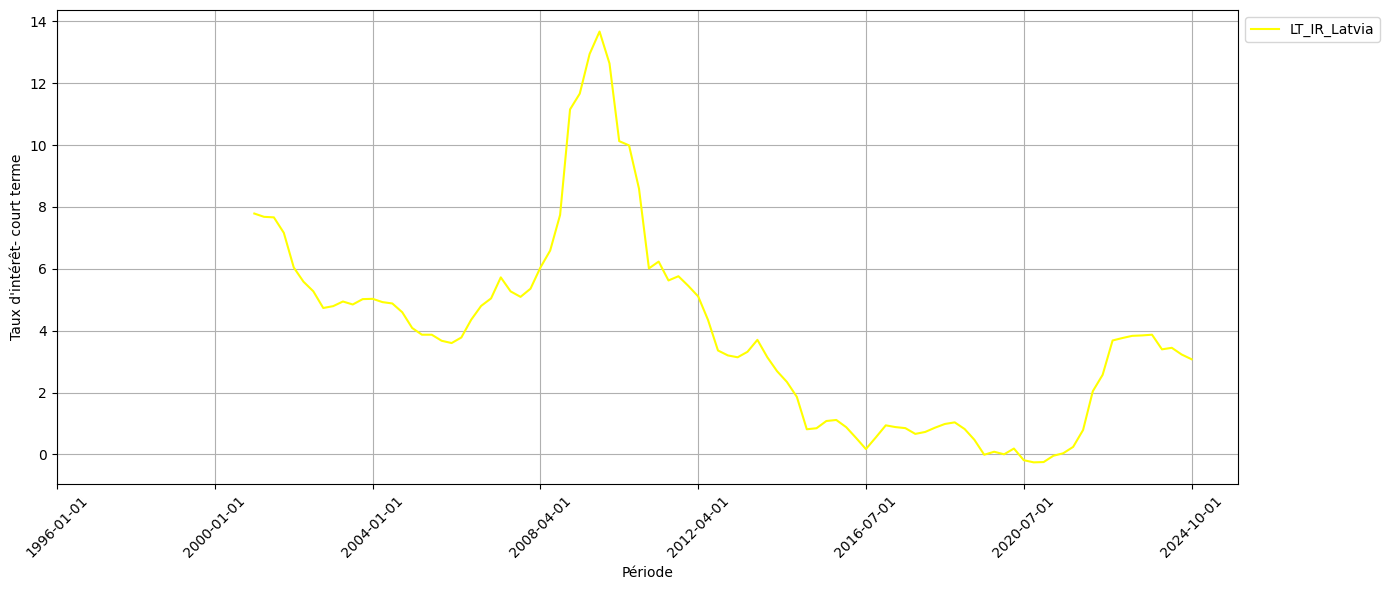

In [114]:
#Le code qui suit sert uniquement à visualiser les ST
# syntaxe: tracer_evolution(df, columns=None, xlabel= None, ylabel=None, start_date=None, end_date=None, log=False, base=None, lissage=False):
tracer_evolution(df_clean_TS,["LT_IR_Latvia"], xlabel ="Période",ylabel = "Taux d'intérêt- court terme")


In [115]:
#Pour le moment la série ne semble avoir ni tendance ni saisonalité, essayons d'appliquer un test ADF
result = adfuller(df_clean_TS["LT_IR_Latvia"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

#La série n'est pas stationnaire
#essayons de faire une différenciation

ADF Statistic: -1.8849115861464936
p-value: 0.339192126932768


In [116]:
LT_IR_Latvia_diff=df_clean_TS["LT_IR_Latvia"].diff()
#LT_IR_Latvia_diff.plot(title="Taux d'intérêt Lettonie différencié", figsize=(12, 4))

In [117]:
#Résult
result = adfuller(LT_IR_Latvia_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
#On rejette à 5% l'hypothèse de non stationarité


ADF Statistic: -3.1602487301201223
p-value: 0.022404055416099515


<Figure size 1400x600 with 0 Axes>

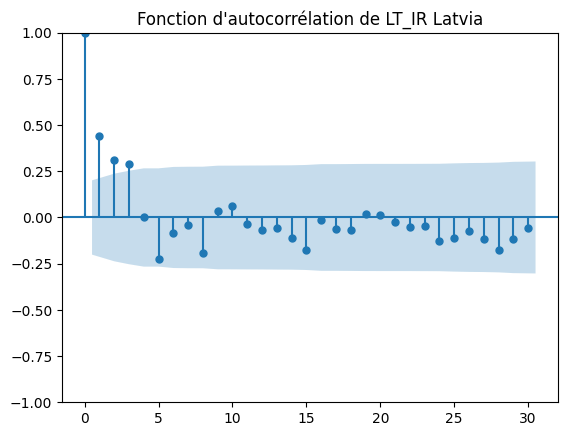

<Figure size 1400x600 with 0 Axes>

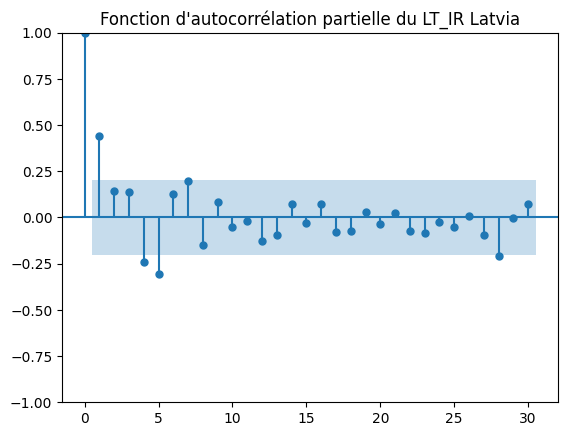

In [118]:
plt.figure(figsize=(14,6))
tsaplots.plot_acf(LT_IR_Latvia_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation de LT_IR Latvia")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(LT_IR_Latvia_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du LT_IR Latvia")
plt.show()


In [119]:
LT_IR_Latvia_models=evaluate_all_models(LT_IR_Latvia_diff.dropna(), 3, 5)


Test du modèle ARIMA(0,0,1)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0144 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(0,0,2)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.0051 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(0,0,3)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.3579 -> OK
 Modèle retenu.

Test du modèle ARIMA(0,0,4)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.2873 -> OK
 Modèle rejeté.

Test du modèle ARIMA(0,0,5)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.3701 -> OK
 Modèle retenu.

Test du modèle ARIMA(1,0,0)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0047 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(1,0,1)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 -

C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.0042 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(2,0,2)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0407 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(2,0,3)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.4542 -> OK
 Modèle rejeté.

Test du modèle ARIMA(2,0,4)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.7889 -> OK
 Modèle retenu.

Test du modèle ARIMA(2,0,5)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.8758 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,0)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0122 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(3,0,1)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.0199

C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.5589 -> OK
 Modèle retenu.

Test du modèle ARIMA(3,0,3)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.6247 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,4)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.8787 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,5)
 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.8814 -> OK
 Modèle rejeté.

Résumé : modèles retenus
[(0, 3), (0, 5), (2, 4), (3, 2)]


In [120]:
compute_aic_bic(LT_IR_Latvia_diff,LT_IR_Latvia_models,0)

C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Tableau AIC et BIC :
   p  d  q         AIC         BIC
0  0  0  3  175.073290  188.841241
1  3  0  2  175.166795  194.441927
2  0  0  5  177.235480  196.510612
3  2  0  4  174.580233  196.608955


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p  d  q         AIC         BIC
0  0  0  3  175.073290  188.841241
1  3  0  2  175.166795  194.441927
2  0  0  5  177.235480  196.510612
3  2  0  4  174.580233  196.608955

C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData

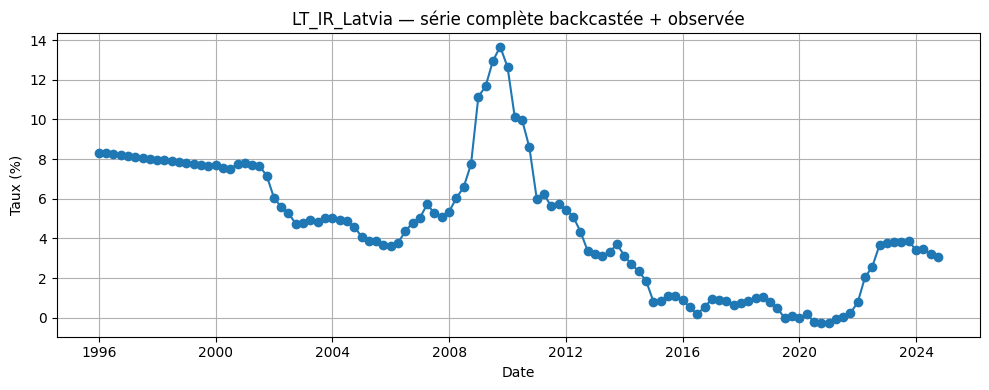

In [121]:
#On essaie d'appliquer la fonction précédente
#LT_IR_Latvia_pred=backcast_arima(df_clean_TS,"LT_IR_Latvia",(2,1,4))
LT_IR_Latvia_pred=backcast_arima(df_clean_TS, "LT_IR_Latvia", (2,1,4), trend='t')
LT_IR_Latvia_pred_final = LT_IR_Latvia_pred.combine_first(df_clean_TS["LT_IR_Latvia"])
LT_IR_Latvia_pred_final



# Si LT_IR_Latvia_pred_final est un pd.Series indexé en datetime :
plt.figure(figsize=(10, 4))
plt.plot(LT_IR_Latvia_pred_final.index, 
         LT_IR_Latvia_pred_final.values, 
         marker='o', linestyle='-')
plt.title("LT_IR_Latvia — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.tight_layout()
plt.show()



#### LT_IR_Lithuania<a class="anchor" id="partie212"></a>

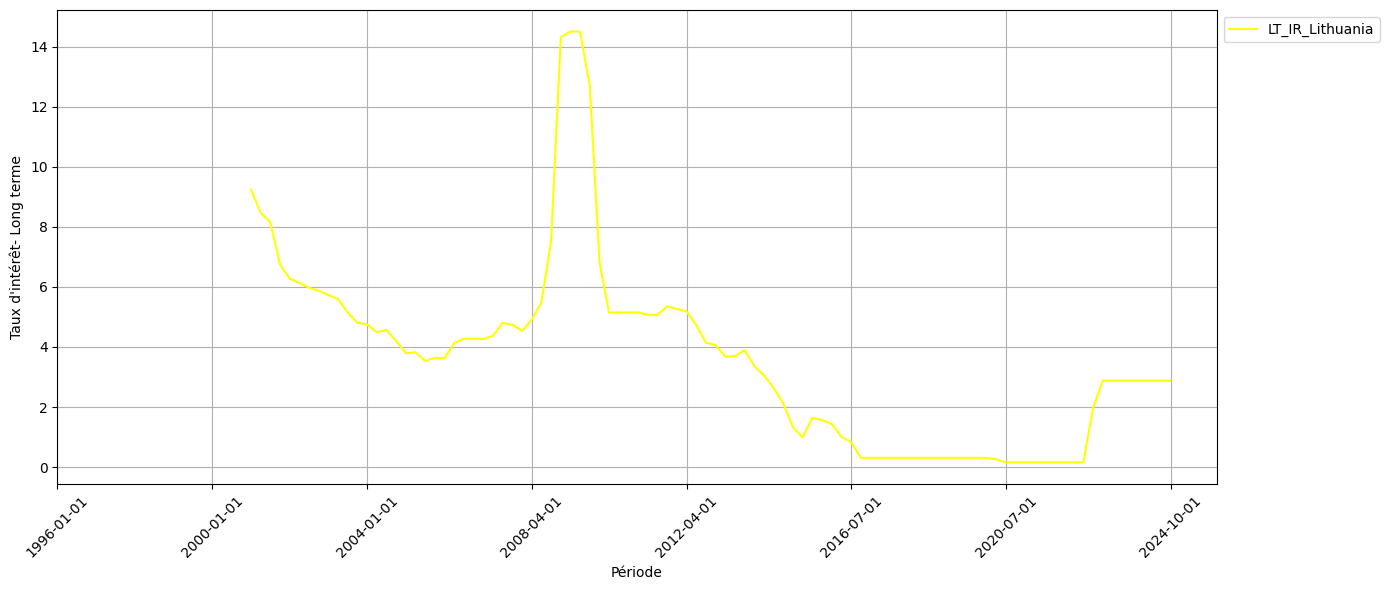

In [122]:
#Le code qui suit sert uniquement à visualiser les ST
# syntaxe: tracer_evolution(df, columns=None, xlabel= None, ylabel=None, start_date=None, end_date=None, log=False, base=None, lissage=False):
tracer_evolution(df_clean_TS,["LT_IR_Lithuania"], xlabel ="Période",ylabel = "Taux d'intérêt- Long terme")

In [123]:
#Pour le moment la série ne semble avoir ni tendance ni saisonalité, essayons d'appliquer un test ADF
result = adfuller(df_clean_TS["LT_IR_Lithuania"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

#La série n'est pas stationnaire
#essayons de faire une différenciation


ADF Statistic: -1.818546542335467
p-value: 0.37129349860400845


<Figure size 1400x600 with 0 Axes>

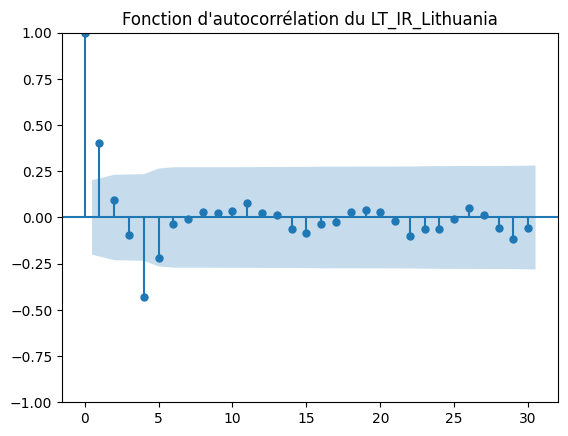

<Figure size 1400x600 with 0 Axes>

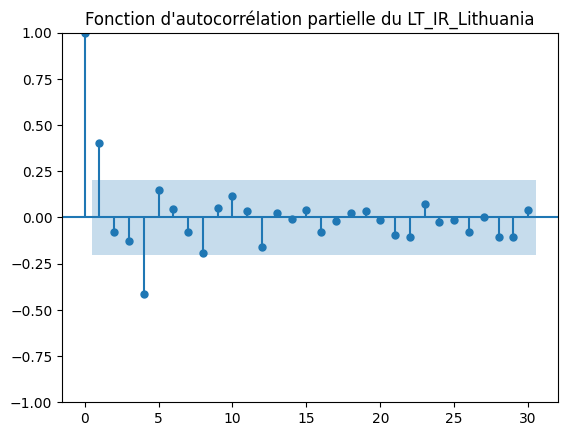

In [124]:
LT_IR_Lithuania_diff=df_clean_TS["LT_IR_Lithuania"].diff()
#LT_IR_Latvia_diff.plot(title="Taux d'intérêt Lettonie différencié", figsize=(12, 4))

plt.figure(figsize=(14,6))
tsaplots.plot_acf(LT_IR_Lithuania_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du LT_IR_Lithuania")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(LT_IR_Lithuania_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du LT_IR_Lithuania")
plt.show()

In [125]:
#Résult
result = adfuller(LT_IR_Lithuania_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
#On rejette à 5% l'hypothèse de non stationarité


ADF Statistic: -7.293609226345864
p-value: 1.396406179338527e-10


In [126]:
LT_IR_Lithuania_models=evaluate_all_models(LT_IR_Lithuania_diff.dropna(), 4, 4)



Test du modèle ARIMA(0,0,1)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.1321 -> OK
 Modèle retenu.

Test du modèle ARIMA(0,0,2)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.1423 -> OK
 Modèle rejeté.

Test du modèle ARIMA(0,0,3)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.7538 -> OK
 Modèle retenu.

Test du modèle ARIMA(0,0,4)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.8796 -> OK
 Modèle retenu.

Test du modèle ARIMA(1,0,0)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0756 -> OK
 Modèle retenu.

Test du modèle ARIMA(1,0,1)
 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.0966 -> OK
 Modèle rejeté.

Test du modèle ARIMA(1,0,2)
 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-val

C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.9979 -> OK
 Modèle rejeté.

Test du modèle ARIMA(2,0,0)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0977 -> OK
 Modèle rejeté.

Test du modèle ARIMA(2,0,1)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.2762 -> OK
 Modèle rejeté.

Test du modèle ARIMA(2,0,2)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.7259 -> OK
 Modèle rejeté.

Test du modèle ARIMA(2,0,3)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.8753 -> OK
 Modèle rejeté.

Test du modèle ARIMA(2,0,4)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 1.0000 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,0)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0875 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,1)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.2566 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,2)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.5523 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,3)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.9880 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,4)
 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 1.0000 -> OK
 Modèle rejeté.

Test du modèle ARIMA(4,0,0)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.7804 -> OK
 Modèle retenu.

Test du modèle ARIMA(4,0,1)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.8931 -> OK
 Modèle rejeté.

Test du modèle ARIMA(4,0,2)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.9710 -> OK
 Modèle retenu.

Test du modèle ARIMA(4,0,3)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.9967 -> OK
 Modèle rejeté.

Test du modèle ARIMA(4,0,4)
 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 1.0000 -> OK
 Modèle rejeté.

Résumé : modèles retenus
[(0, 1), (0, 3), (0, 4), (1, 0), (4, 0), (4, 2)]


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [127]:
compute_aic_bic(LT_IR_Lithuania_diff,LT_IR_Lithuania_models,0)



Tableau AIC et BIC :
   p  d  q         AIC         BIC
0  0  0  4  249.990856  266.512397
1  0  0  3  254.481407  268.249358
2  4  0  0  252.962406  269.483947
3  4  0  2  251.685807  273.714528
4  0  0  1  266.053885  274.314656
5  1  0  0  266.436475  274.697246


p  d  q         AIC         BIC
0  0  0  4  249.990856  266.512397
1  0  0  3  254.481407  268.249358
2  4  0  0  252.962406  269.483947
3  4  0  2  251.685807  273.714528
4  0  0  1  266.053885  274.314656
5  1  0  0  266.436475  274.697246

C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData

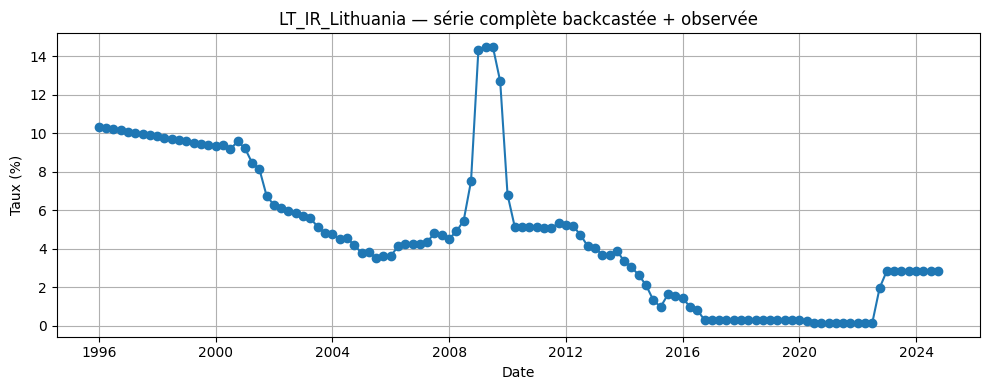

In [128]:
# LT_IR_Lithuania_pred = backcast_arima(df_clean_TS, "LT_IR_Lithuania", (0,1,4), trend='t')
LT_IR_Lithuania_pred = backcast_arima(df_clean_TS, "LT_IR_Lithuania", (0,1,4), trend='t')
LT_IR_Lithuania_pred_final = LT_IR_Lithuania_pred.combine_first(df_clean_TS["LT_IR_Lithuania"])

# Si LT_IR_Lithuania_pred_final est un pd.Series indexé en datetime :
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(LT_IR_Lithuania_pred_final.index, 
         LT_IR_Lithuania_pred_final.values, 
         marker='o', linestyle='-')
plt.title("LT_IR_Lithuania — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


#### LT_IR_Poland<a class="anchor" id="partie213"></a>

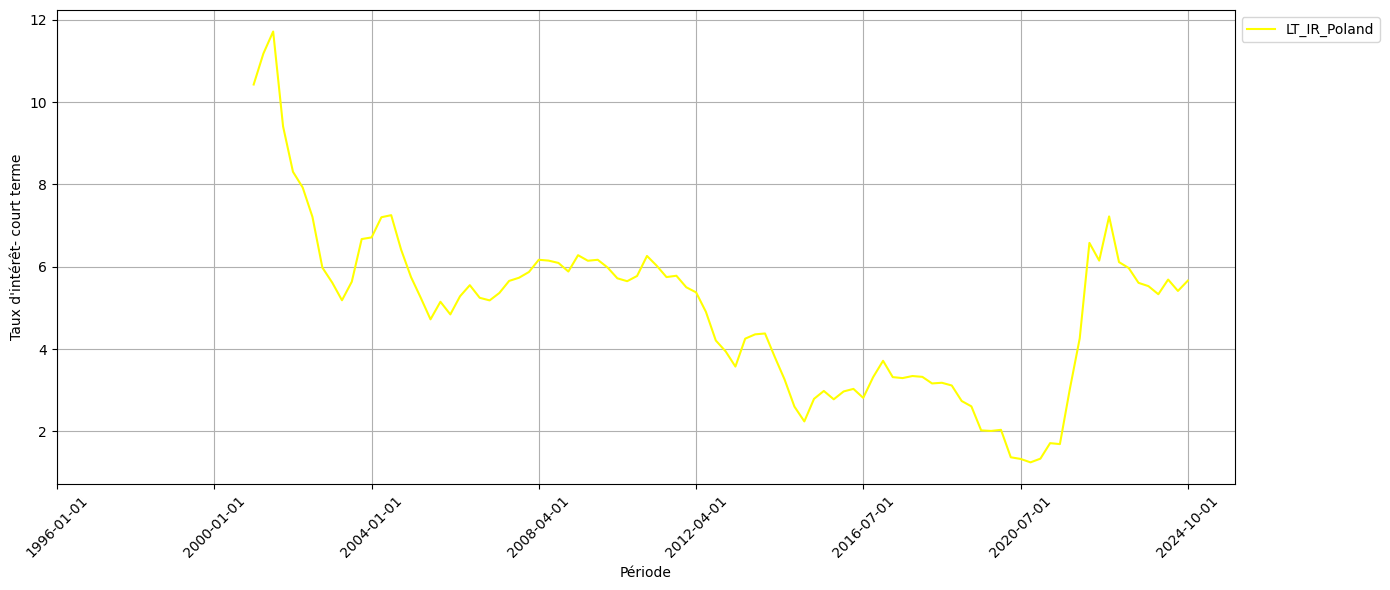

In [129]:
# Le code qui suit sert uniquement à visualiser les ST
# syntaxe: tracer_evolution(df, columns=None, xlabel= None, ylabel=None, start_date=None, end_date=None, log=False, base=None, lissage=False):
tracer_evolution(df_clean_TS, ["LT_IR_Poland"], xlabel="Période", ylabel="Taux d'intérêt- court terme")

In [130]:
#La série semble avoir une tendance décroissante, essayons d'appliquer un test ADF
result = adfuller(df_clean_TS["LT_IR_Poland"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# La série n'est pas stationnaire
# Essayons de faire une différenciation

ADF Statistic: -2.543728744524317
p-value: 0.10519383468210919


<Axes: title={'center': "Taux d'intérêt Pologne différencié"}, xlabel='Unnamed: 0'>

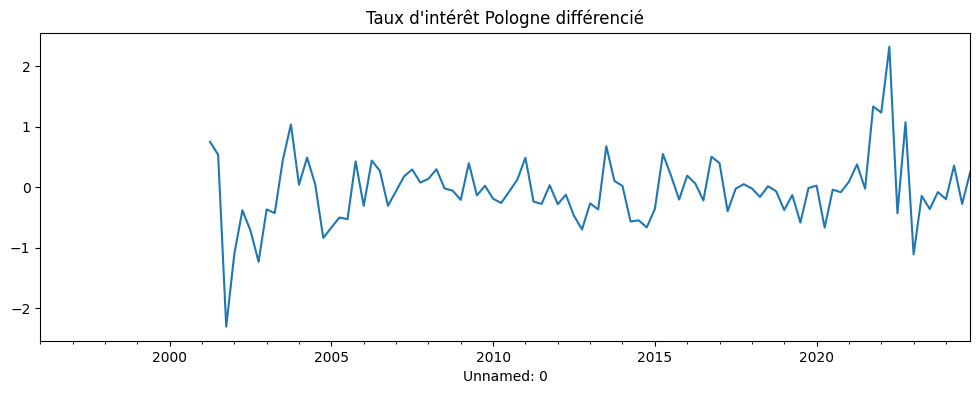

In [131]:
LT_IR_Poland_diff = df_clean_TS["LT_IR_Poland"].diff()
LT_IR_Poland_diff.plot(title="Taux d'intérêt Pologne différencié", figsize=(12, 4))
# La série semble centrée en 0, mais avec une légère tendance à la hausse

In [132]:
# Résultat du test ADF sur la série différenciée
result = adfuller(LT_IR_Poland_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
# On rejette à 5% l'hypothèse de non stationnarité

ADF Statistic: -4.8511274930990895
p-value: 4.3374993142604195e-05


<Figure size 1400x600 with 0 Axes>

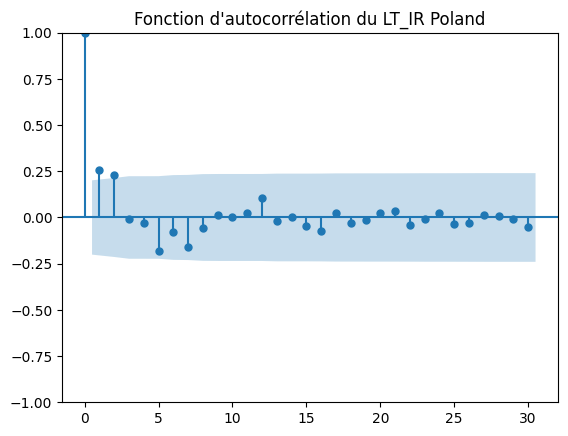

<Figure size 1400x600 with 0 Axes>

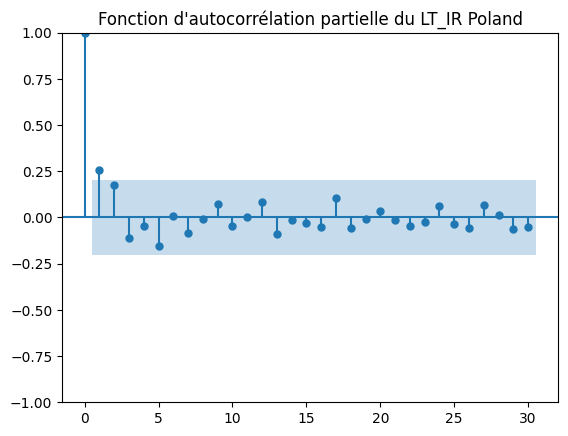

In [133]:

plt.figure(figsize=(14,6))
tsaplots.plot_acf(LT_IR_Poland_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du LT_IR Poland")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(LT_IR_Poland_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du LT_IR Poland")
plt.show()

In [134]:
LT_IR_Poland_models = evaluate_all_models(LT_IR_Poland_diff.dropna(), 1, 2)
#Les ordres conservés: (1,2)


Test du modèle ARIMA(0,0,1)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.5577 -> OK
 Modèle retenu.

Test du modèle ARIMA(0,0,2)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.9584 -> OK
 Modèle retenu.

Test du modèle ARIMA(1,0,0)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.6906 -> OK
 Modèle retenu.

Test du modèle ARIMA(1,0,1)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.8176 -> OK
 Modèle rejeté.

Test du modèle ARIMA(1,0,2)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.9691 -> OK
 Modèle rejeté.

Résumé : modèles retenus
[(0, 1), (0, 2), (1, 0)]


In [135]:
compute_aic_bic(LT_IR_Poland_diff, LT_IR_Poland_models, 0)
#Modèle retenu selon le criètere BIC



Tableau AIC et BIC :
   p  d  q         AIC         BIC
0  1  0  0  162.603672  170.864443
1  0  0  2  160.146215  171.160576
2  0  0  1  164.581765  172.842535


p  d  q         AIC         BIC
0  1  0  0  162.603672  170.864443
1  0  0  2  160.146215  171.160576
2  0  0  1  164.581765  172.842535

In [136]:
# On essaie d'appliquer la fonction backcast
LT_IR_Poland_pred = backcast_arima(df_clean_TS, "LT_IR_Poland", (1,1,0), trend='t')
LT_IR_Poland_pred_final = LT_IR_Poland_pred.combine_first(df_clean_TS["LT_IR_Poland"])
LT_IR_Poland_pred_final

C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData

Unnamed: 0
1996-01-01    11.071866
1996-04-01    11.025739
1996-07-01    10.979612
1996-10-01    10.933486
1997-01-01    10.887359
                ...    
2023-10-01     5.530000
2024-01-01     5.333333
2024-04-01     5.690000
2024-07-01     5.413333
2024-10-01     5.663333
Freq: QS-OCT, Name: backcast_LT_IR_Poland, Length: 116, dtype: float64

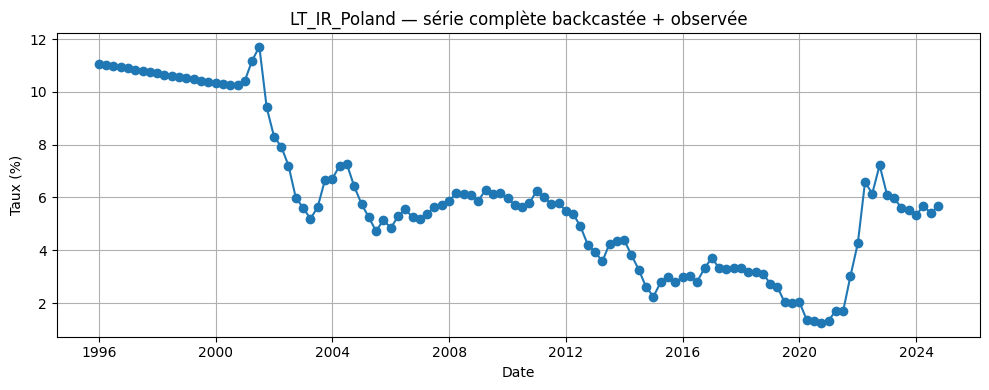

In [137]:
# Si LT_IR_Poland_pred_final est un pd.Series indexé en datetime :
plt.figure(figsize=(10, 4))
plt.plot(LT_IR_Poland_pred_final.index, 
         LT_IR_Poland_pred_final.values, 
         marker='o', linestyle='-')
plt.title("LT_IR_Poland — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### LT_IR_Slovakia<a class="anchor" id="partie214"></a>

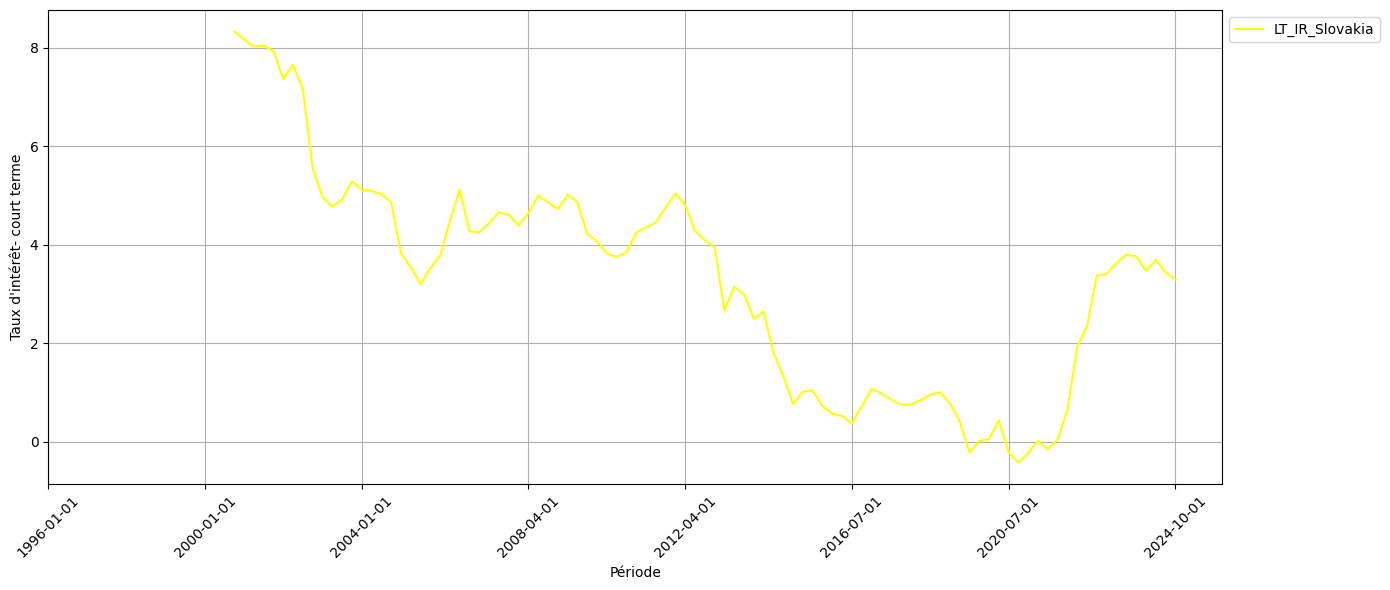

In [138]:
# Le code qui suit sert uniquement à visualiser les ST
# syntaxe: tracer_evolution(df, columns=None, xlabel= None, ylabel=None, start_date=None, end_date=None, log=False, base=None, lissage=False):
tracer_evolution(df_clean_TS, ["LT_IR_Slovakia"], xlabel="Période", ylabel="Taux d'intérêt- court terme")

In [139]:
# Pour le moment la série semble avoir une tendane décroissante. Appliquons un ADF
result = adfuller(df_clean_TS["LT_IR_Slovakia"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
# La série n'est pas stationnaire
# Essayons de faire une différenciation

ADF Statistic: -2.28379394050597
p-value: 0.1772480300529503


<Axes: title={'center': "Taux d'intérêt Slovaquie différencié"}, xlabel='Unnamed: 0'>

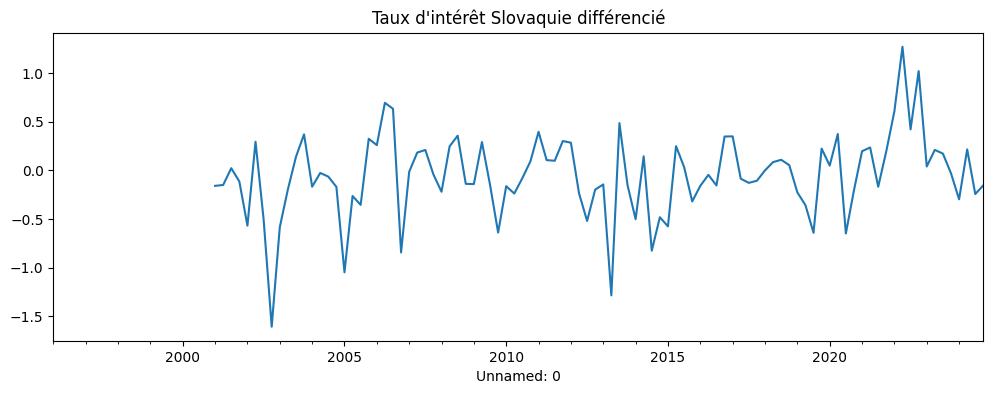

In [140]:
LT_IR_Slovakia_diff = df_clean_TS["LT_IR_Slovakia"].diff()
LT_IR_Slovakia_diff.plot(title="Taux d'intérêt Slovaquie différencié", figsize=(12, 4))


In [141]:
# Résultat du test ADF sur la série différenciée
result = adfuller(LT_IR_Slovakia_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
# On rejette à 5% l'hypothèse de non stationnarité

ADF Statistic: -7.392895562566153
p-value: 7.915058713534137e-11


<Figure size 1400x600 with 0 Axes>

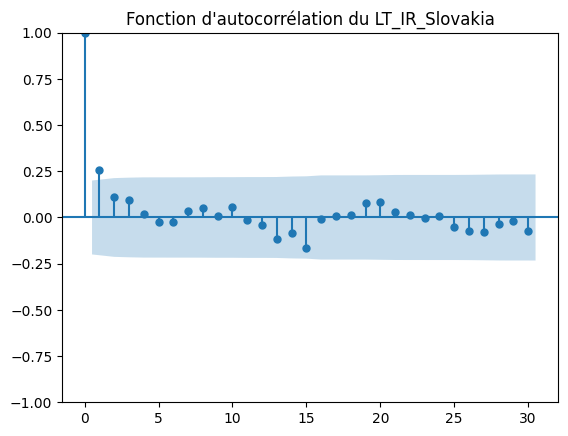

<Figure size 1400x600 with 0 Axes>

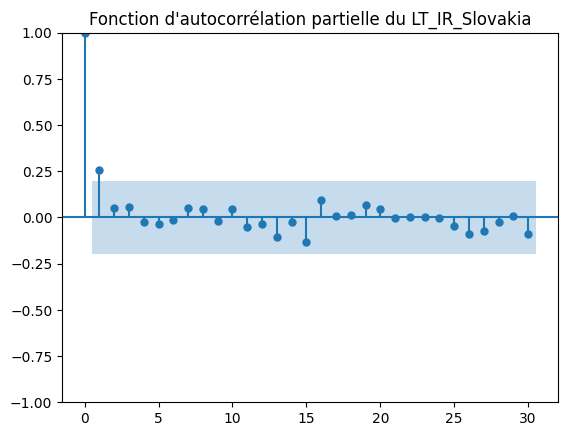

In [142]:
plt.figure(figsize=(14,6))
tsaplots.plot_acf(LT_IR_Slovakia_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du LT_IR_Slovakia")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(LT_IR_Slovakia_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du LT_IR_Slovakia")
plt.show()

In [143]:
#modèles retenus: (1,1)
LT_IR_Slovakia_models = evaluate_all_models(LT_IR_Slovakia_diff.dropna(), 1, 1)



Test du modèle ARIMA(0,0,1)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.9507 -> OK
 Modèle retenu.

Test du modèle ARIMA(1,0,0)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.9800 -> OK
 Modèle retenu.

Test du modèle ARIMA(1,0,1)
 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.9867 -> OK
 Modèle rejeté.

Résumé : modèles retenus
[(0, 1), (1, 0)]


In [144]:
compute_aic_bic(LT_IR_Slovakia_diff, LT_IR_Slovakia_models, 0)


Tableau AIC et BIC :
   p  d  q         AIC         BIC
0  1  0  0  107.081959  115.342730
1  0  0  1  107.848256  116.109026


p  d  q         AIC         BIC
0  1  0  0  107.081959  115.342730
1  0  0  1  107.848256  116.109026

In [145]:
# On essaie d'appliquer la fonction précédente
# LT_IR_Slovakia_pred = backcast_arima(df_clean_TS, "LT_IR_Slovakia", (0,1,1))
LT_IR_Slovakia_pred = backcast_arima(df_clean_TS, "LT_IR_Slovakia", (0,1,1), trend='t')
LT_IR_Slovakia_pred_final = LT_IR_Slovakia_pred.combine_first(df_clean_TS["LT_IR_Slovakia"])
LT_IR_Slovakia_pred_final

C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData

Unnamed: 0
1996-01-01    9.351080
1996-04-01    9.298318
1996-07-01    9.245556
1996-10-01    9.192794
1997-01-01    9.140032
                ...   
2023-10-01    3.766608
2024-01-01    3.470253
2024-04-01    3.687122
2024-07-01    3.444584
2024-10-01    3.291885
Freq: QS-OCT, Name: backcast_LT_IR_Slovakia, Length: 116, dtype: float64

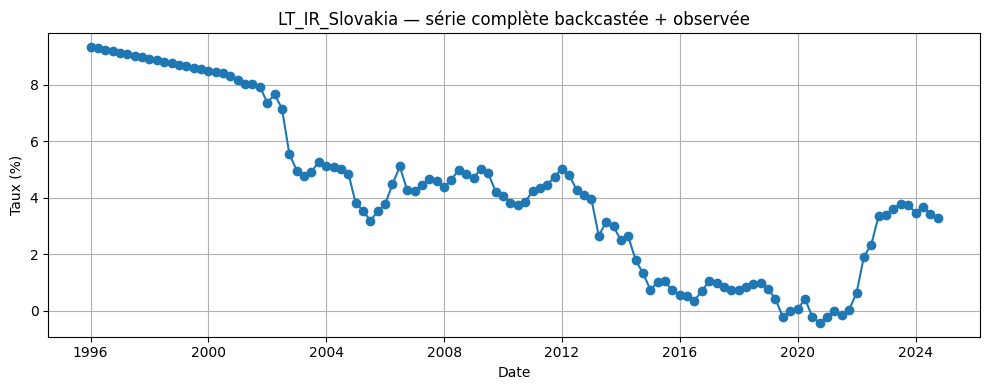

In [146]:
# Si LT_IR_Slovakia_pred_final est un pd.Series indexé en datetime :
plt.figure(figsize=(10, 4))
plt.plot(LT_IR_Slovakia_pred_final.index, 
         LT_IR_Slovakia_pred_final.values, 
         marker='o', linestyle='-')
plt.title("LT_IR_Slovakia — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData

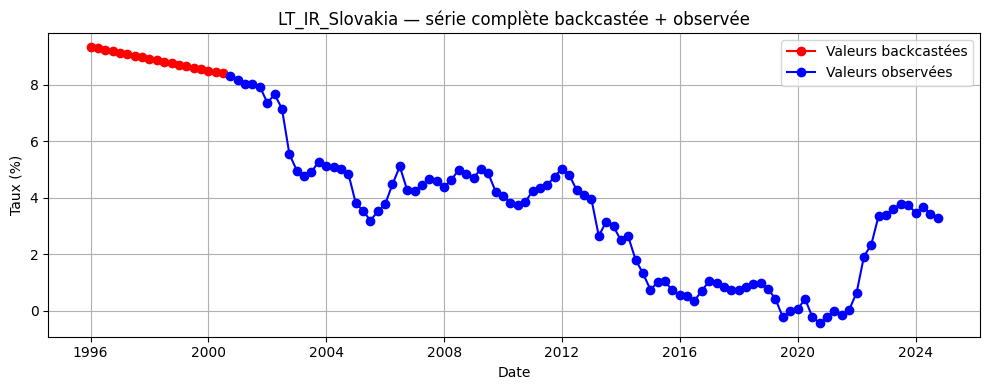

In [147]:
# On applique le backcast
LT_IR_Slovakia_pred = backcast_arima(df_clean_TS, "LT_IR_Slovakia", (0,1,1), trend='t')
LT_IR_Slovakia_pred_final = LT_IR_Slovakia_pred.combine_first(df_clean_TS["LT_IR_Slovakia"])

# Tracé
plt.figure(figsize=(10, 4))

# Partie backcastée (rouge)
plt.plot(LT_IR_Slovakia_pred.index, 
         LT_IR_Slovakia_pred.values, 
         marker='o', linestyle='-', color='red', label='Valeurs backcastées')

# Partie observée (bleu)
plt.plot(df_clean_TS["LT_IR_Slovakia"].index, 
         df_clean_TS["LT_IR_Slovakia"].values, 
         marker='o', linestyle='-', color='blue', label='Valeurs observées')

# Mise en forme
plt.title("LT_IR_Slovakia — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### LT_IR_Czechia<a class="anchor" id="partie215"></a>
Attention: aucun modèle ne passe tous les tests malheuresement, on a gardé celui obtenu visuellement à partir de ACF et PACF

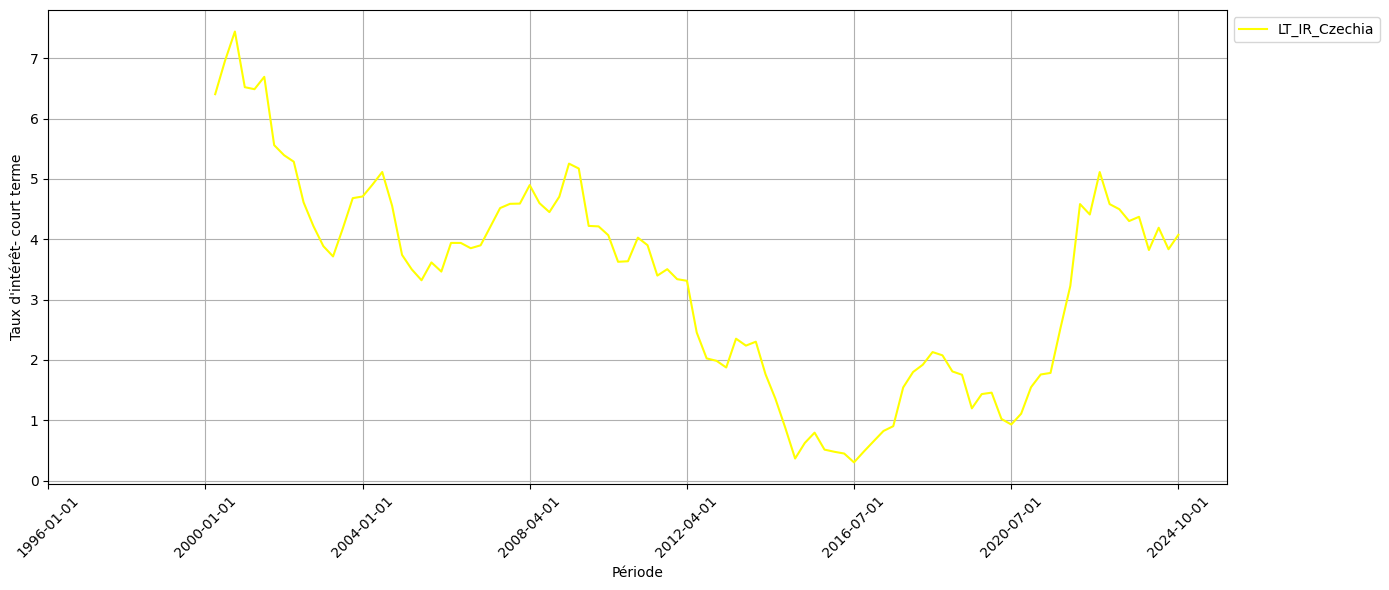

ADF Statistic: -2.707573992039009
p-value: 0.0727367828540567


In [148]:
tracer_evolution(df_clean_TS, ["LT_IR_Czechia"], xlabel="Période", ylabel="Taux d'intérêt- court terme")
result = adfuller(df_clean_TS["LT_IR_Czechia"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -5.780118468320979
p-value: 5.149224446308652e-07


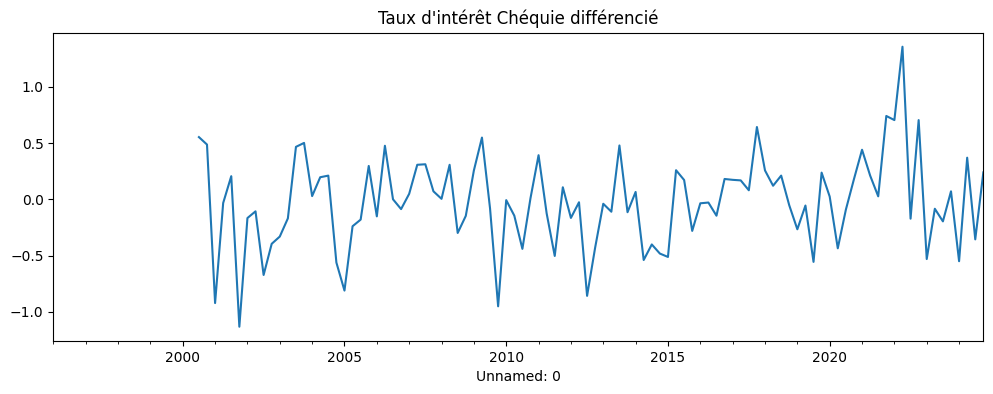

In [149]:
LT_IR_Czechia_diff = df_clean_TS["LT_IR_Czechia"].diff()
LT_IR_Czechia_diff.plot(title="Taux d'intérêt Chéquie différencié", figsize=(12, 4))

result = adfuller(LT_IR_Czechia_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


<Figure size 1400x600 with 0 Axes>

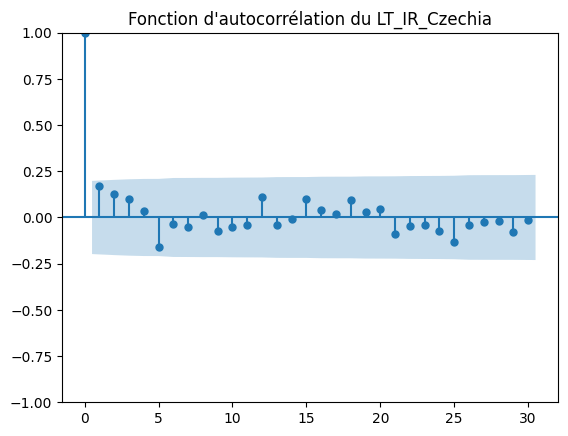

<Figure size 1400x600 with 0 Axes>

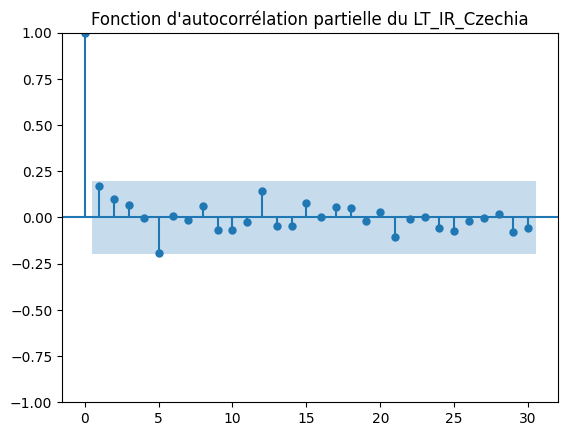

In [150]:
plt.figure(figsize=(14,6))
tsaplots.plot_acf(LT_IR_Czechia_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du LT_IR_Czechia")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(LT_IR_Czechia_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du LT_IR_Czechia")
plt.show()

In [151]:
LT_IR_Czechia_models = evaluate_all_models(LT_IR_Czechia_diff.dropna(), 5, 0)
# Problème: aucun modèle n'est retenu à la fin, on va tout de même garder le modèle (5,1,0)


Test du modèle ARIMA(1,0,0)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.8331 -> OK
 Modèle rejeté.

Test du modèle ARIMA(2,0,0)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.8413 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,0)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.8877 -> OK
 Modèle rejeté.

Test du modèle ARIMA(4,0,0)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.8835 -> OK
 Modèle rejeté.

Test du modèle ARIMA(5,0,0)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.9856 -> OK
 Modèle rejeté.

Résumé : modèles retenus
[]


In [152]:

LT_IR_Czechia_pred = backcast_arima(df_clean_TS, "LT_IR_Czechia", (5,1,0), trend='t')
LT_IR_Czechia_pred_final = LT_IR_Czechia_pred.combine_first(df_clean_TS["LT_IR_Czechia"])
LT_IR_Czechia_pred_final

C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData

Unnamed: 0
1996-01-01    6.598714
1996-04-01    6.578437
1996-07-01    6.560922
1996-10-01    6.539648
1997-01-01    6.521467
                ...   
2023-10-01    4.371921
2024-01-01    3.821404
2024-04-01    4.190742
2024-07-01    3.834368
2024-10-01    4.073143
Freq: QS-OCT, Name: backcast_LT_IR_Czechia, Length: 116, dtype: float64

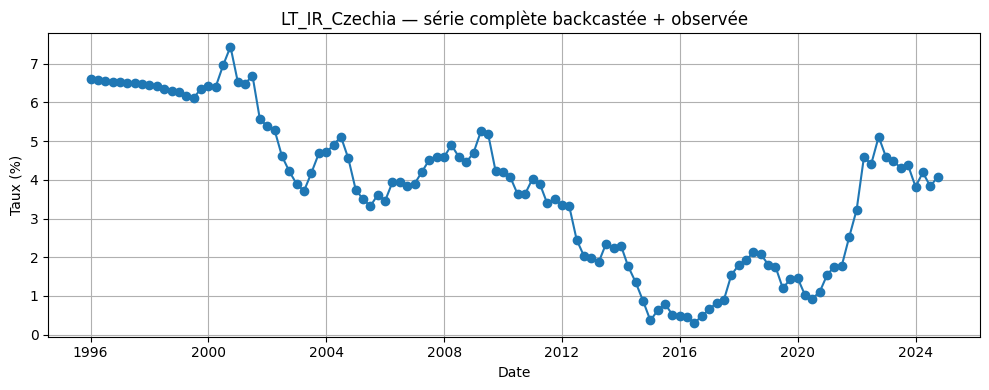

In [153]:
plt.figure(figsize=(10, 4))
plt.plot(LT_IR_Czechia_pred_final.index, 
         LT_IR_Czechia_pred_final.values, 
         marker='o', linestyle='-')
plt.title("LT_IR_Czechia — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### LT_IR_Hungary<a class="anchor" id="partie216"></a>


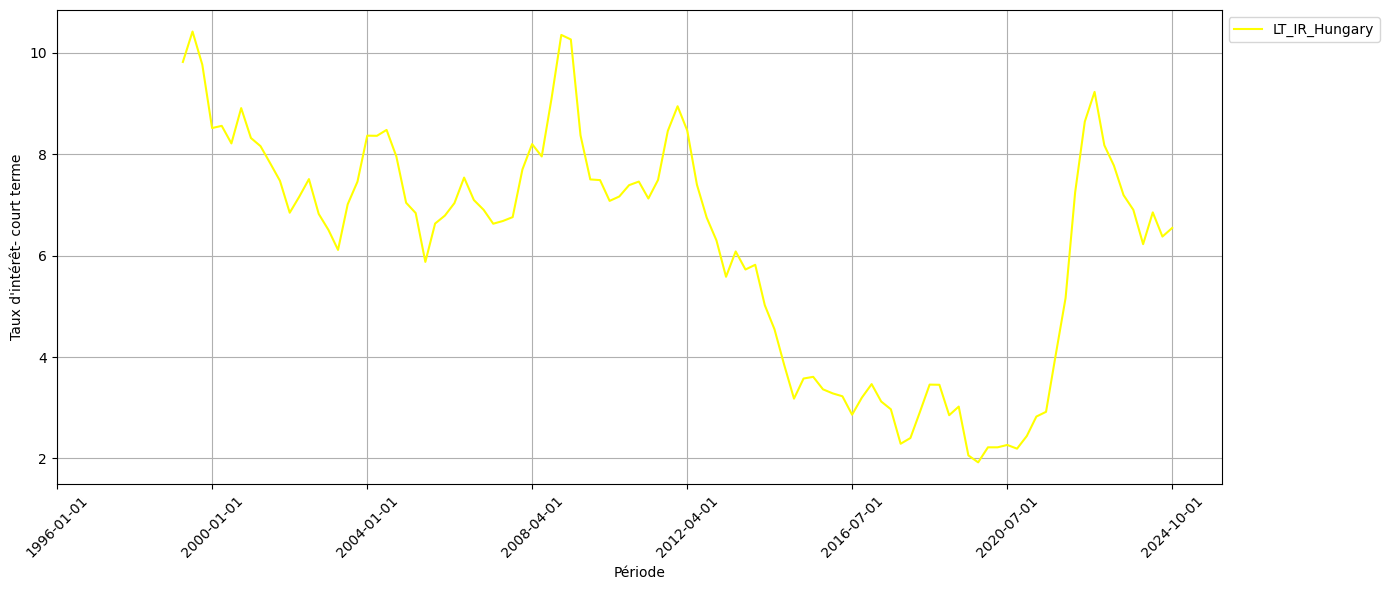

ADF Statistic: -2.536862197378653
p-value: 0.10676097937657103


In [154]:
tracer_evolution(df_clean_TS, ["LT_IR_Hungary"], xlabel="Période", ylabel="Taux d'intérêt- court terme")

result = adfuller(df_clean_TS["LT_IR_Hungary"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -6.96098226931102
p-value: 9.166218243210964e-10


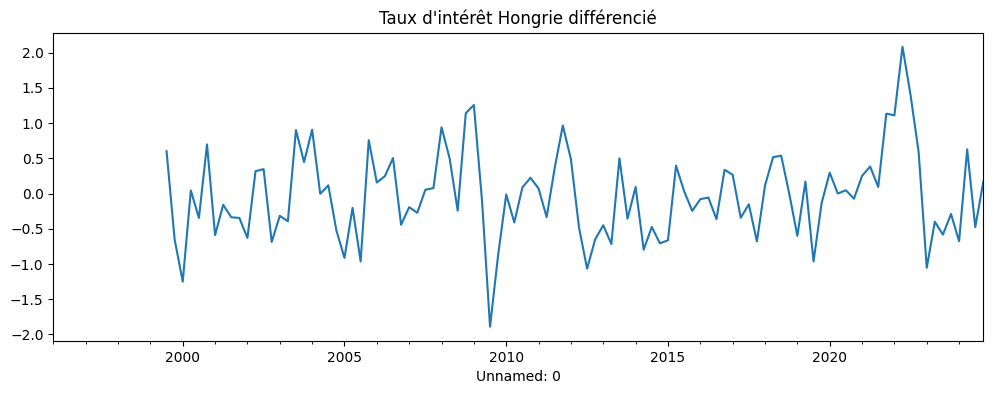

In [155]:
LT_IR_Hungary_diff = df_clean_TS["LT_IR_Hungary"].diff()
LT_IR_Hungary_diff.plot(title="Taux d'intérêt Hongrie différencié", figsize=(12, 4))


result = adfuller(LT_IR_Hungary_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

<Figure size 1400x600 with 0 Axes>

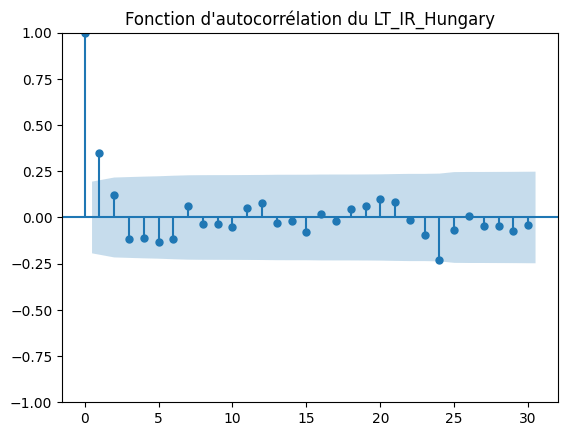

<Figure size 1400x600 with 0 Axes>

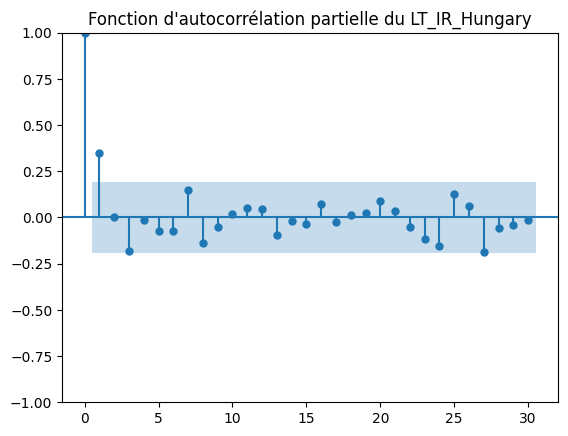

In [156]:
plt.figure(figsize=(14,6))
tsaplots.plot_acf(LT_IR_Hungary_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du LT_IR_Hungary")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(LT_IR_Hungary_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du LT_IR_Hungary")
plt.show()

In [157]:
LT_IR_Hungary_models = evaluate_all_models(LT_IR_Hungary_diff.dropna(), 3, 1)



Test du modèle ARIMA(0,0,1)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.5875 -> OK
 Modèle retenu.

Test du modèle ARIMA(1,0,0)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.7046 -> OK
 Modèle retenu.

Test du modèle ARIMA(1,0,1)
 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.7029 -> OK
 Modèle rejeté.

Test du modèle ARIMA(2,0,0)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.7011 -> OK
 Modèle rejeté.

Test du modèle ARIMA(2,0,1)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.7449 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,0)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.8888 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,1)
 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.8915 -> OK
 Modèle rejeté.

Résumé : modèles retenus
[(0, 1), (1, 0)]


In [158]:
compute_aic_bic(LT_IR_Hungary_diff, LT_IR_Hungary_models, 0)



Tableau AIC et BIC :
   p  d  q         AIC         BIC
0  1  0  0  186.916190  195.176961
1  0  0  1  189.117247  197.378017


p  d  q         AIC         BIC
0  1  0  0  186.916190  195.176961
1  0  0  1  189.117247  197.378017

In [159]:
LT_IR_Hungary_pred = backcast_arima(df_clean_TS, "LT_IR_Hungary", (1,1,0), trend='t')
LT_IR_Hungary_pred_final = LT_IR_Hungary_pred.combine_first(df_clean_TS["LT_IR_Hungary"])
LT_IR_Hungary_pred_final

C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData

Unnamed: 0
1996-01-01    9.846734
1996-04-01    9.818961
1996-07-01    9.791189
1996-10-01    9.763420
1997-01-01    9.735662
                ...   
2023-10-01    6.903333
2024-01-01    6.226666
2024-04-01    6.853333
2024-07-01    6.376667
2024-10-01    6.546667
Freq: QS-OCT, Name: backcast_LT_IR_Hungary, Length: 116, dtype: float64

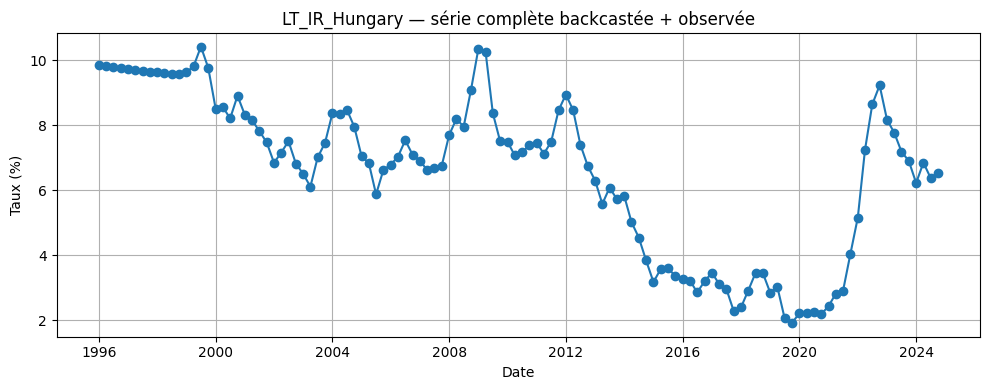

In [160]:
plt.figure(figsize=(10, 4))
plt.plot(LT_IR_Hungary_pred_final.index, 
         LT_IR_Hungary_pred_final.values, 
         marker='o', linestyle='-')
plt.title("LT_IR_Hungary — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### LT_IR_Iceland<a class="anchor" id="partie217"></a>
Ceci est à compléter.... il faut modifier la fonction du backcast, mais cette fois-ci pour faire du forecast

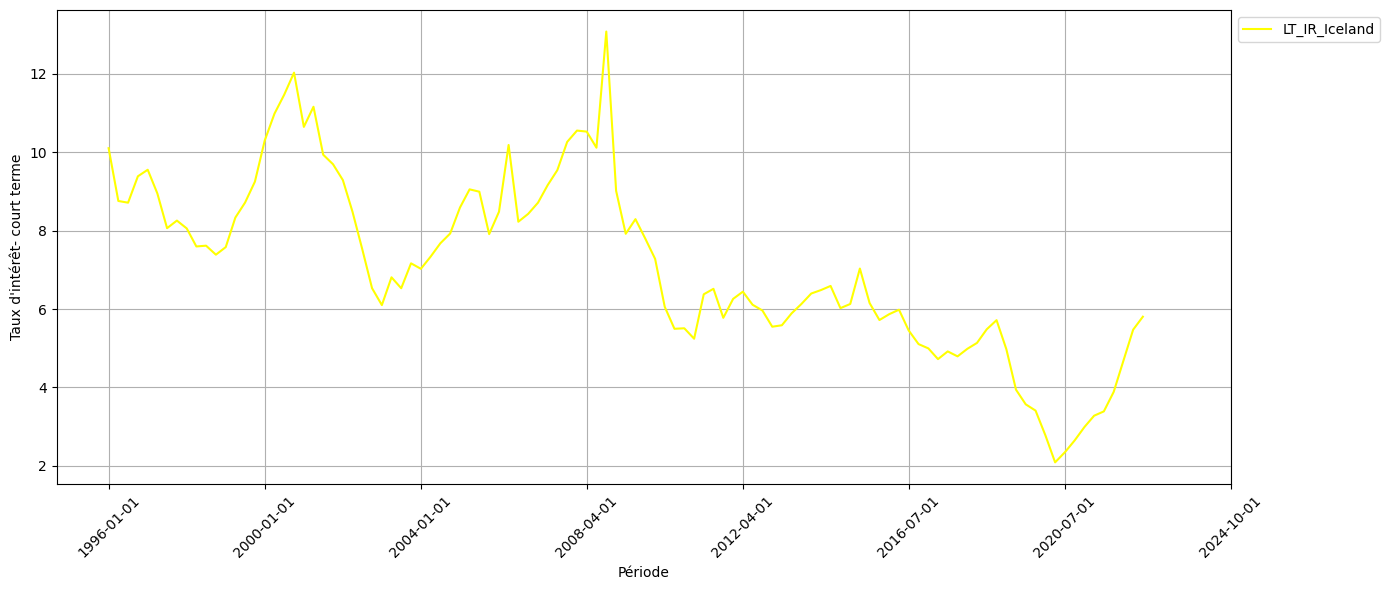

In [234]:
tracer_evolution(df_clean_TS, ["LT_IR_Iceland"], xlabel="Période", ylabel="Taux d'intérêt- court terme")


In [ ]:
# Test ADF sur la série brute
result = adfuller(df_clean_TS["LT_IR_Iceland"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# donc on je rejette pas adf


ADF Statistic: -0.8427435108969838
p-value: 0.806243036230037


<Axes: title={'center': "Taux d'intérêt Islande différencié"}, xlabel='Unnamed: 0'>

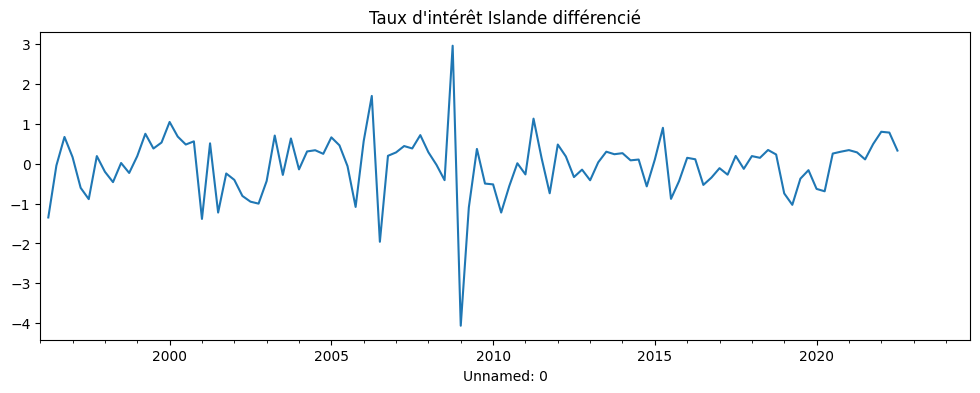

In [236]:
# Différenciation de la série
LT_IR_Iceland_diff = df_clean_TS["LT_IR_Iceland"].diff()
LT_IR_Iceland_diff.plot(title="Taux d'intérêt Islande différencié", figsize=(12, 4))

In [ ]:
# Test ADF sur la série différenciée
result = adfuller(LT_IR_Iceland_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

#là c'est bon, on rejette

ADF Statistic: -4.129017195131697
p-value: 0.0008669182712754103


<Figure size 1400x600 with 0 Axes>

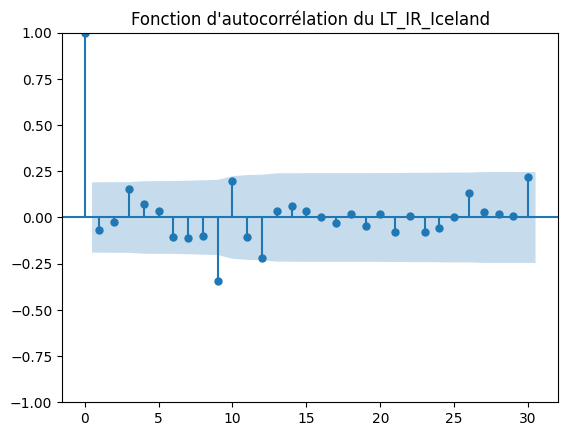

<Figure size 1400x600 with 0 Axes>

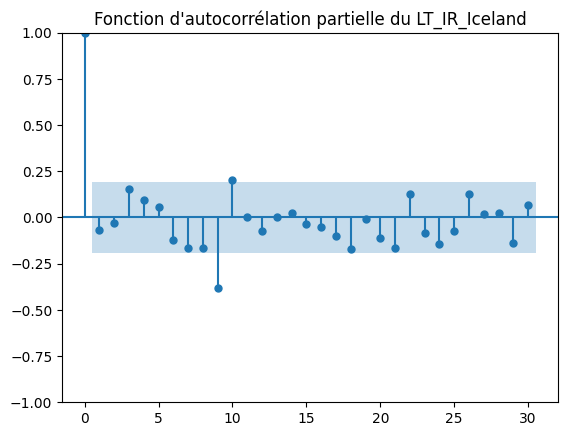

In [238]:
# ACF
plt.figure(figsize=(14,6))
tsaplots.plot_acf(LT_IR_Iceland_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du LT_IR_Iceland")
plt.show()

# PACF
plt.figure(figsize=(14,6))
tsaplots.plot_pacf(LT_IR_Iceland_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du LT_IR_Iceland")
plt.show()

In [239]:
LT_IR_Iceland_models = evaluate_all_models(LT_IR_Iceland_diff.dropna(), 9, 9)



Test du modèle ARIMA(0,0,1)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.0024 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(0,0,2)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.0024 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(0,0,3)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0073 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(0,0,4)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.0701 -> OK
 Modèle rejeté.

Test du modèle ARIMA(0,0,5)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.1368 -> OK
 Modèle rejeté.

Test du modèle ARIMA(0,0,6)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.1208 -> OK
 Modèle rejeté.

Test du modèle ARIMA(0,0,7)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.1235 -> OK
 Modèle retenu.

Test du modèle ARIMA(0,0,8)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.1457 -> OK
 Modèle rejeté.

Test du modèle ARIMA(0,0,9)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.7129 -> OK
 Modèle rejeté.

Test du modèle ARIMA(1,0,0)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0024 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(1,0,1)
 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.0026 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(1,0,2)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0028 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(1,0,3)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.1020 -> OK
 Modèle retenu.

Test du modèle ARIMA(1,0,4)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.1148 -> OK
 Modèle rejeté.

Test du modèle ARIMA(1,0,5)
 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.1343 -> OK
 Modèle rejeté.

Test du modèle ARIMA(1,0,6)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.1679 -> OK
 Modèle rejeté.

Test du modèle ARIMA(1,0,7)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.2171 -> OK
 Modèle rejeté.

Test du modèle ARIMA(1,0,8)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.1324 -> OK
 Modèle rejeté.

Test du modèle ARIMA(1,0,9)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.7085 -> OK
 Modèle rejeté.

Test du modèle ARIMA(2,0,0)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0023 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(2,0,1)
 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.0030 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(2,0,2)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0739 -> OK
 Modèle retenu.

Test du modèle ARIMA(2,0,3)
 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.1123 -> OK
 Modèle rejeté.

Test du modèle ARIMA(2,0,4)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.2713 -> OK
 Modèle retenu.

Test du modèle ARIMA(2,0,5)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.2003 -> OK
 Modèle retenu.

Test du modèle ARIMA(2,0,6)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.2516 -> OK
 Modèle rejeté.

Test du modèle ARIMA(2,0,7)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.4319 -> OK
 Modèle rejeté.

Test du modèle ARIMA(2,0,8)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.4178 -> OK
 Modèle rejeté.

Test du modèle ARIMA(2,0,9)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.9204 -> OK
 Modèle retenu.

Test du modèle ARIMA(3,0,0)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0081 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(3,0,1)
 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.0085 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(3,0,2)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.1009 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,3)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.0138 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(3,0,4)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.1028 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,5)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.2887 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,6)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.2386 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,7)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.7114 -> OK
 Modèle retenu.

Test du modèle ARIMA(3,0,8)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.7391 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,9)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.8277 -> OK
 Modèle rejeté.

Test du modèle ARIMA(4,0,0)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0069 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(4,0,1)
 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.0073 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(4,0,2)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.1089 -> OK
 Modèle rejeté.

Test du modèle ARIMA(4,0,3)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0825 -> OK
 Modèle rejeté.

Test du modèle ARIMA(4,0,4)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.3700 -> OK
 Modèle rejeté.

Test du modèle ARIMA(4,0,5)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.3191 -> OK
 Modèle rejeté.

Test du modèle ARIMA(4,0,6)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.5773 -> OK
 Modèle retenu.

Test du modèle ARIMA(4,0,7)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.7399 -> OK
 Modèle rejeté.

Test du modèle ARIMA(4,0,8)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.8098 -> OK
 Modèle rejeté.

Test du modèle ARIMA(4,0,9)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.9547 -> OK
 Modèle rejeté.

Test du modèle ARIMA(5,0,0)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0085 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(5,0,1)
 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.0093 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(5,0,2)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:

 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0304 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(5,0,3)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.1092 -> OK
 Modèle retenu.

Test du modèle ARIMA(5,0,4)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.2782 -> OK
 Modèle rejeté.

Test du modèle ARIMA(5,0,5)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.2930 -> OK
 Modèle rejeté.

Test du modèle ARIMA(5,0,6)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.5631 -> OK
 Modèle rejeté.

Test du modèle ARIMA(5,0,7)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.8786 -> OK
 Modèle rejeté.

Test du modèle ARIMA(5,0,8)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.9732 -> OK
 Modèle rejeté.

Test du modèle ARIMA(5,0,9)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.9831 -> OK
 Modèle rejeté.

Test du modèle ARIMA(6,0,0)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0111 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(6,0,1)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.1050 -> OK
 Modèle rejeté.

Test du modèle ARIMA(6,0,2)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.1106 -> OK
 Modèle rejeté.

Test du modèle ARIMA(6,0,3)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.3169 -> OK
 Modèle rejeté.

Test du modèle ARIMA(6,0,4)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.3951 -> OK
 Modèle retenu.

Test du modèle ARIMA(6,0,5)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.6322 -> OK
 Modèle rejeté.

Test du modèle ARIMA(6,0,6)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.5188 -> OK
 Modèle rejeté.

Test du modèle ARIMA(6,0,7)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.9363 -> OK
 Modèle rejeté.

Test du modèle ARIMA(6,0,8)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.9269 -> OK
 Modèle rejeté.

Test du modèle ARIMA(6,0,9)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.9801 -> OK
 Modèle rejeté.

Test du modèle ARIMA(7,0,0)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0199 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(7,0,1)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.1181 -> OK
 Modèle rejeté.

Test du modèle ARIMA(7,0,2)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.1953 -> OK
 Modèle retenu.

Test du modèle ARIMA(7,0,3)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.3255 -> OK
 Modèle rejeté.

Test du modèle ARIMA(7,0,4)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.5018 -> OK
 Modèle rejeté.

Test du modèle ARIMA(7,0,5)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.6107 -> OK
 Modèle retenu.

Test du modèle ARIMA(7,0,6)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.5692 -> OK
 Modèle rejeté.

Test du modèle ARIMA(7,0,7)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.8896 -> OK
 Modèle rejeté.

Test du modèle ARIMA(7,0,8)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.8822 -> OK
 Modèle rejeté.

Test du modèle ARIMA(7,0,9)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.9882 -> OK
 Modèle rejeté.

Test du modèle ARIMA(8,0,0)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0456 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(8,0,1)
 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.1926 -> OK
 Modèle rejeté.

Test du modèle ARIMA(8,0,2)
 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.2701 -> OK
 Modèle rejeté.

Test du modèle ARIMA(8,0,3)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.3246 -> OK
 Modèle rejeté.

Test du modèle ARIMA(8,0,4)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.5129 -> OK
 Modèle rejeté.

Test du modèle ARIMA(8,0,5)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.5778 -> OK
 Modèle rejeté.

Test du modèle ARIMA(8,0,6)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.8308 -> OK
 Modèle rejeté.

Test du modèle ARIMA(8,0,7)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.8475 -> OK
 Modèle rejeté.

Test du modèle ARIMA(8,0,8)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.9285 -> OK
 Modèle rejeté.

Test du modèle ARIMA(8,0,9)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.9986 -> OK
 Modèle rejeté.

Test du modèle ARIMA(9,0,0)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.8717 -> OK
 Modèle retenu.

Test du modèle ARIMA(9,0,1)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.9717 -> OK
 Modèle rejeté.

Test du modèle ARIMA(9,0,2)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.9951 -> OK
 Modèle rejeté.

Test du modèle ARIMA(9,0,3)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.9950 -> OK
 Modèle rejeté.

Test du modèle ARIMA(9,0,4)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.9951 -> OK
 Modèle rejeté.

Test du modèle ARIMA(9,0,5)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.9901 -> OK
 Modèle retenu.

Test du modèle ARIMA(9,0,6)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.9952 -> OK
 Modèle rejeté.

Test du modèle ARIMA(9,0,7)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.9984 -> OK
 Modèle rejeté.

Test du modèle ARIMA(9,0,8)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.9938 -> OK
 Modèle rejeté.

Test du modèle ARIMA(9,0,9)
 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 1.0000 -> OK
 Modèle rejeté.

Résumé : modèles retenus
[(0, 7), (1, 3), (2, 2), (2, 4), (2, 5), (2, 9), (3, 7), (4, 6), (5, 3), (6, 4), (7, 2), (7, 5), (9, 0), (9, 5)]


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [240]:
compute_aic_bic(LT_IR_Iceland_diff, LT_IR_Iceland_models, 0)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:


Tableau AIC et BIC :
    p  d  q         AIC         BIC
0   2  0  4  240.061300  262.090021
1   2  0  2  247.585070  264.106611
2   1  0  3  248.848298  265.369839
3   2  0  9  232.548626  268.345299
4   9  0  0  238.139146  268.428638
5   4  0  6  239.911855  272.954937
6   3  0  7  240.122475  273.165557
7   2  0  5  249.195264  273.977576
8   0  0  7  249.533530  274.315841
9   7  0  2  246.150940  276.440432
10  5  0  3  249.667240  277.203142
11  6  0  4  245.637521  278.680603
12  9  0  5  237.046763  281.104206
13  7  0  5  247.318665  285.868928


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p  d  q         AIC         BIC
0   2  0  4  240.061300  262.090021
1   2  0  2  247.585070  264.106611
2   1  0  3  248.848298  265.369839
3   2  0  9  232.548626  268.345299
4   9  0  0  238.139146  268.428638
5   4  0  6  239.911855  272.954937
6   3  0  7  240.122475  273.165557
7   2  0  5  249.195264  273.977576
8   0  0  7  249.533530  274.315841
9   7  0  2  246.150940  276.440432
10  5  0  3  249.667240  277.203142
11  6  0  4  245.637521  278.680603
12  9  0  5  237.046763  281.104206
13  7  0  5  247.318665  285.868928

In [241]:
LT_IR_Iceland_pred = forecast_arima(df_clean_TS, "LT_IR_Iceland", (2,1,4), trend='t')
LT_IR_Iceland_pred_final = LT_IR_Iceland_pred.combine_first(df_clean_TS["LT_IR_Iceland"])
LT_IR_Iceland_pred_final


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Unnamed: 0
1996-01-01    10.103330
1996-04-01     8.756667
1996-07-01     8.713333
1996-10-01     9.386666
1997-01-01     9.553333
                ...    
2023-10-01     4.823432
2024-01-01     4.412271
2024-04-01     4.001431
2024-07-01     3.636707
2024-10-01     3.350028
Freq: QS-OCT, Name: forecast_LT_IR_Iceland, Length: 116, dtype: float64

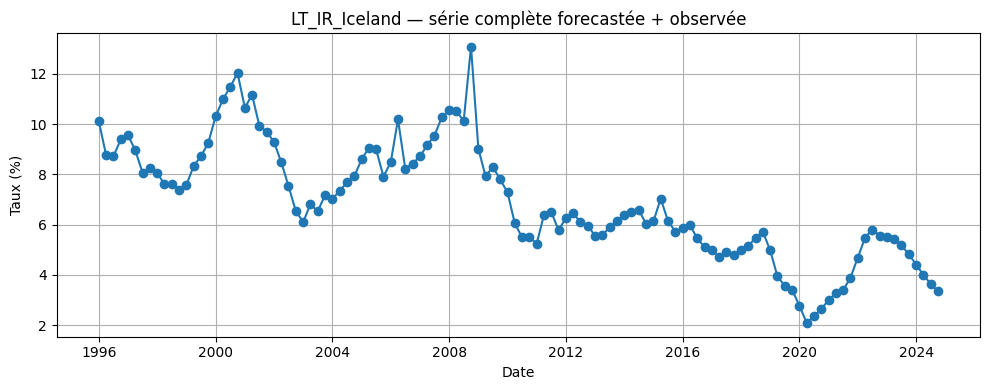

In [242]:
plt.figure(figsize=(10, 4))
plt.plot(LT_IR_Iceland_pred_final.index, 
         LT_IR_Iceland_pred_final.values, 
         marker='o', linestyle='-')
plt.title("LT_IR_Iceland — série complète forecastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

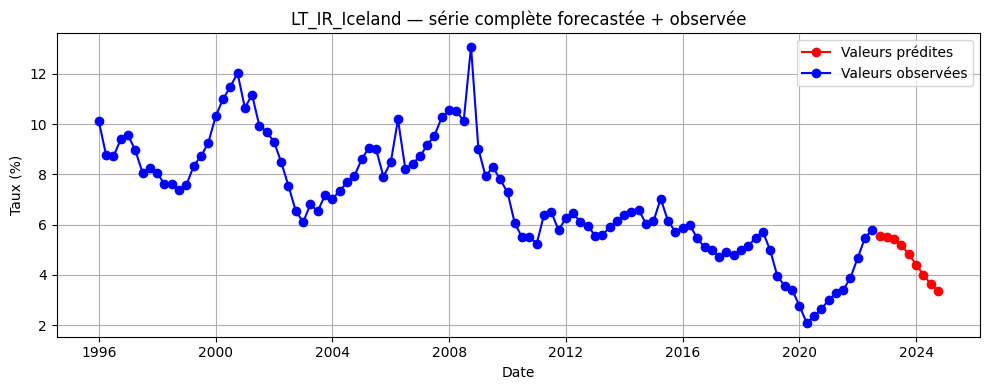

In [243]:
# On crée une figure
plt.figure(figsize=(10, 4))

# Partie forecastée uniquement (les prédictions)
plt.plot(LT_IR_Iceland_pred.index, 
         LT_IR_Iceland_pred.values, 
         marker='o', linestyle='-', color='red', label='Valeurs prédites')

# Partie observée
plt.plot(df_clean_TS["LT_IR_Iceland"].index, 
         df_clean_TS["LT_IR_Iceland"].values, 
         marker='o', linestyle='-', color='blue', label='Valeurs observées')

# Mise en forme
plt.title("LT_IR_Iceland — série complète forecastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### LT_IR_Greece<a class="anchor" id="partie218"></a>
rq: de loin la meilleure prédiction

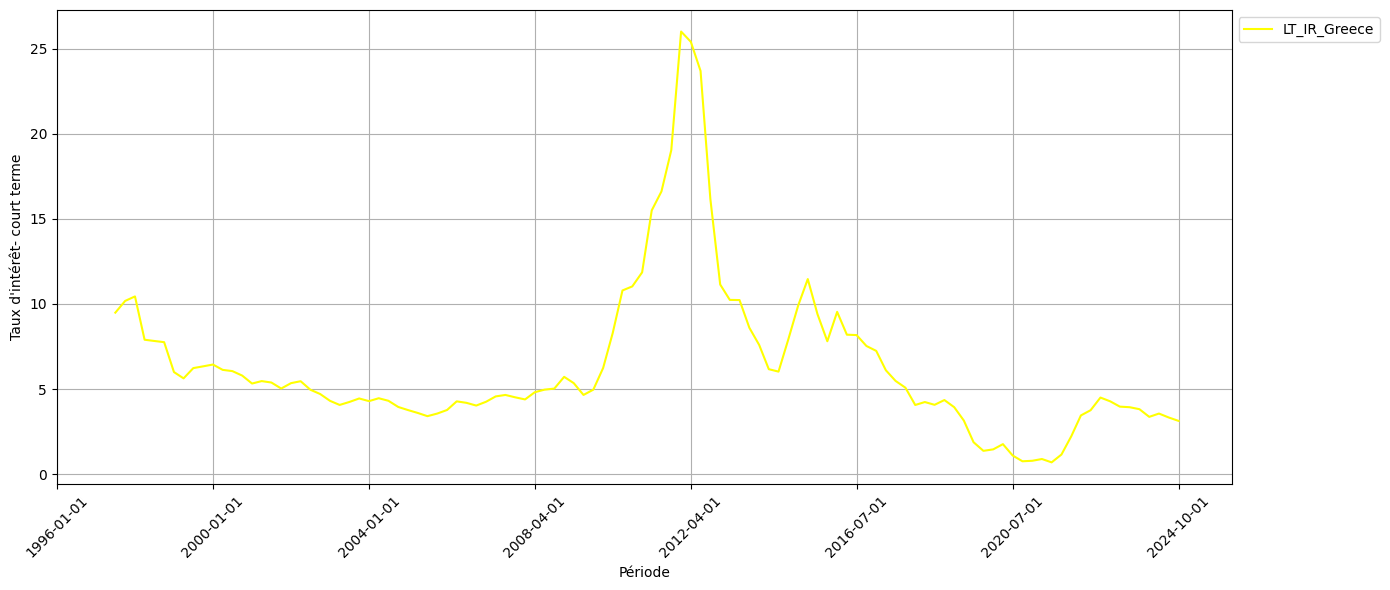

ADF Statistic: -2.7517044559953177
p-value: 0.06551044914612564


In [162]:
tracer_evolution(df_clean_TS, ["LT_IR_Greece"], xlabel="Période", ylabel="Taux d'intérêt- court terme")
result = adfuller(df_clean_TS["LT_IR_Greece"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

In [163]:
LT_IR_Greece_diff = df_clean_TS["LT_IR_Greece"].diff()
result = adfuller(LT_IR_Greece_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -6.362258064818379
p-value: 2.458013571421394e-08


<Figure size 1400x600 with 0 Axes>

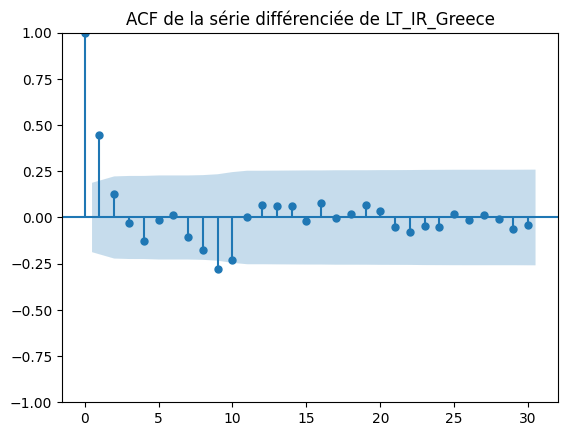

<Figure size 1400x600 with 0 Axes>

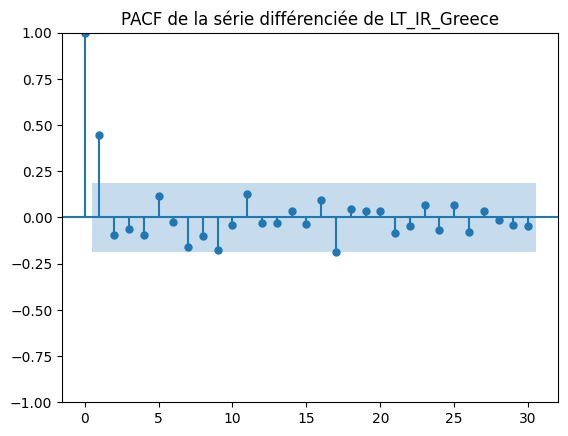

In [164]:
plt.figure(figsize=(14,6))
tsaplots.plot_acf(LT_IR_Greece_diff.dropna(), lags=30)
plt.title("ACF de la série différenciée de LT_IR_Greece")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(LT_IR_Greece_diff.dropna(), lags=30)
plt.title("PACF de la série différenciée de LT_IR_Greece")
plt.show()

In [165]:
LT_IR_Greece_models = evaluate_all_models(LT_IR_Greece_diff.dropna(), 1, 9)



Test du modèle ARIMA(0,0,1)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.2464 -> OK
 Modèle retenu.

Test du modèle ARIMA(0,0,2)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.2861 -> OK
 Modèle retenu.

Test du modèle ARIMA(0,0,3)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.4212 -> OK
 Modèle rejeté.

Test du modèle ARIMA(0,0,4)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.6855 -> OK
 Modèle rejeté.

Test du modèle ARIMA(0,0,5)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.7192 -> OK
 Modèle rejeté.

Test du modèle ARIMA(0,0,6)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.7196 -> OK
 Modèle rejeté.

Test du modèle ARIMA(0,0,7)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-val

C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.8789 -> OK
 Modèle rejeté.

Test du modèle ARIMA(1,0,9)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.9876 -> OK
 Modèle rejeté.

Résumé : modèles retenus
[(0, 1), (0, 2), (1, 0)]


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [166]:
compute_aic_bic(LT_IR_Greece_diff, LT_IR_Greece_models, 0)



Tableau AIC et BIC :
   p  d  q         AIC         BIC
0  1  0  0  367.348512  375.609283
1  0  0  1  368.461875  376.722646
2  0  0  2  368.848556  379.862917


p  d  q         AIC         BIC
0  1  0  0  367.348512  375.609283
1  0  0  1  368.461875  376.722646
2  0  0  2  368.848556  379.862917

In [167]:
LT_IR_Greece_pred = backcast_arima(df_clean_TS, "LT_IR_Greece", (2,1,4), trend='t')
LT_IR_Greece_pred_final = LT_IR_Greece_pred.combine_first(df_clean_TS["LT_IR_Greece"])
LT_IR_Greece_pred_final

C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData

Unnamed: 0
1996-01-01    8.415883
1996-04-01    8.420156
1996-07-01    8.431223
1996-10-01    8.440904
1997-01-01    8.491149
                ...   
2023-10-01    3.820000
2024-01-01    3.370000
2024-04-01    3.563333
2024-07-01    3.333333
2024-10-01    3.133333
Freq: QS-OCT, Name: backcast_LT_IR_Greece, Length: 116, dtype: float64

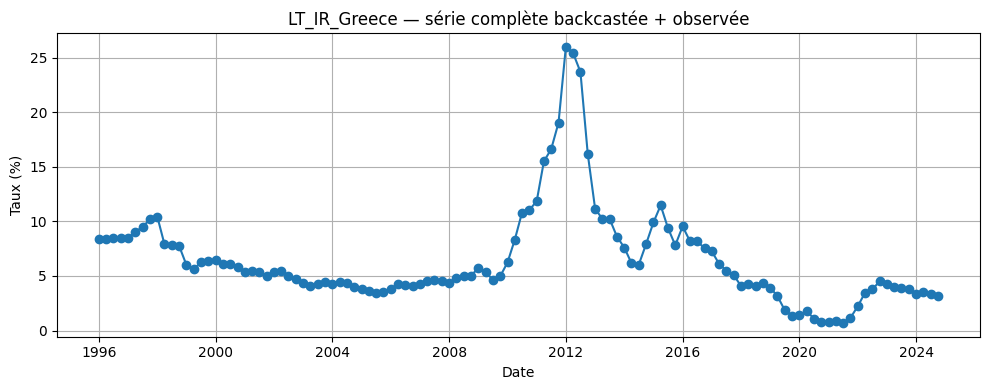

In [168]:
plt.figure(figsize=(10, 4))
plt.plot(LT_IR_Greece_pred_final.index, 
         LT_IR_Greece_pred_final.values, 
         marker='o', linestyle='-')
plt.title("LT_IR_Greece — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

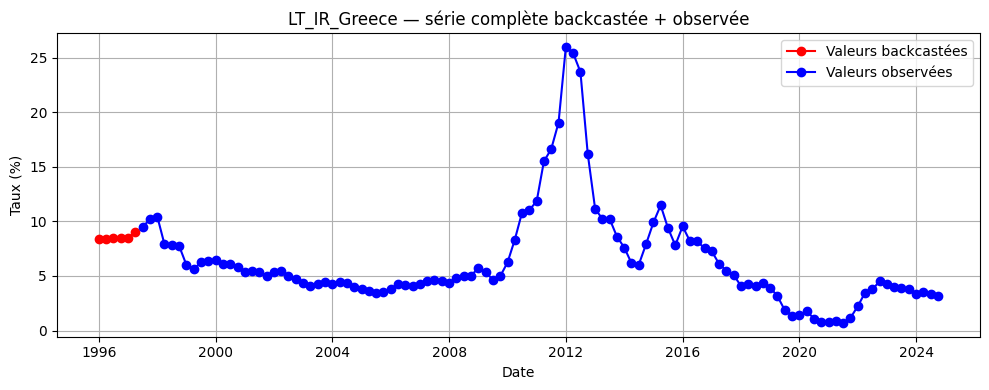

In [169]:
# On crée une figure
plt.figure(figsize=(10, 4))

# Partie backcastée uniquement (les prédictions)
plt.plot(LT_IR_Greece_pred.index, 
         LT_IR_Greece_pred.values, 
         marker='o', linestyle='-', color='red', label='Valeurs backcastées')

# Partie observée
plt.plot(df_clean_TS["LT_IR_Greece"].index, 
         df_clean_TS["LT_IR_Greece"].values, 
         marker='o', linestyle='-', color='blue', label='Valeurs observées')

# Mise en forme
plt.title("LT_IR_Greece — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### WH <a class="anchor" id="partie22"></a>

Il y a une composante saisonnière dans chacune des séries. Il faudra modifier le programme de base

#### WH_Bulgaria <a class="anchor" id="partie221"></a>

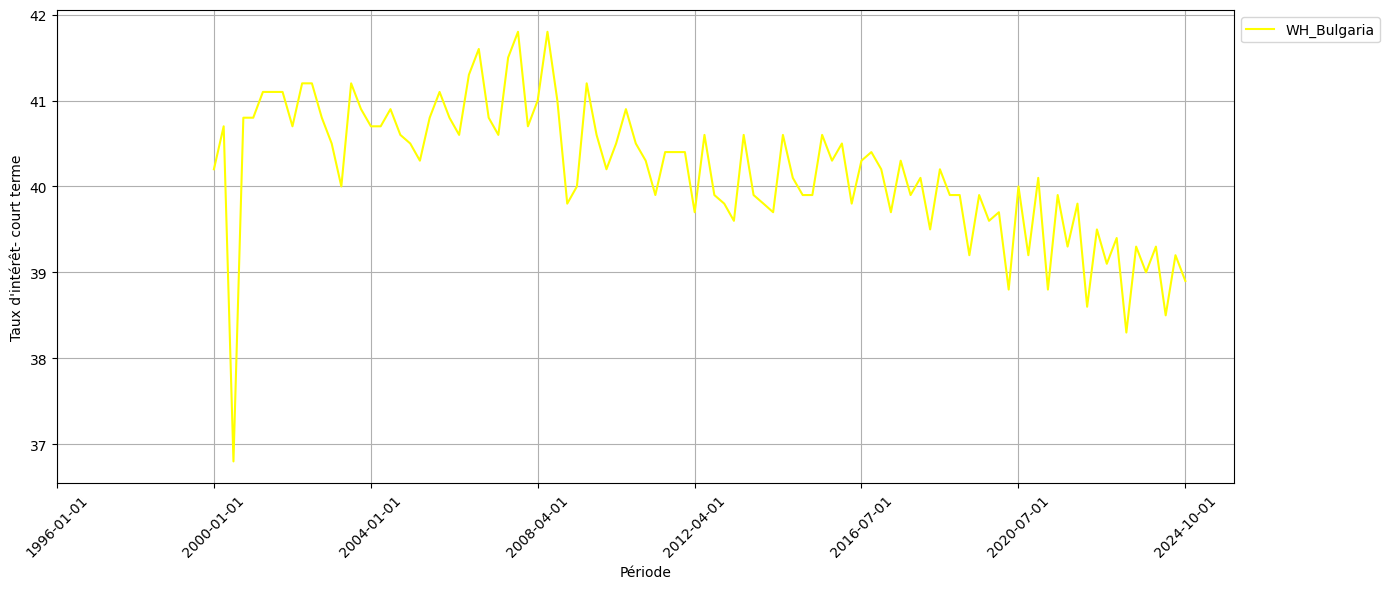

ADF Statistic: -0.7634356011144545
p-value: 0.8296274008942711


In [170]:
tracer_evolution(df_clean_TS, ["WH_Bulgaria"], xlabel="Période", ylabel="Taux d'intérêt- court terme")

result = adfuller(df_clean_TS["WH_Bulgaria"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -6.8584275326344395
p-value: 1.6257643941916911e-09


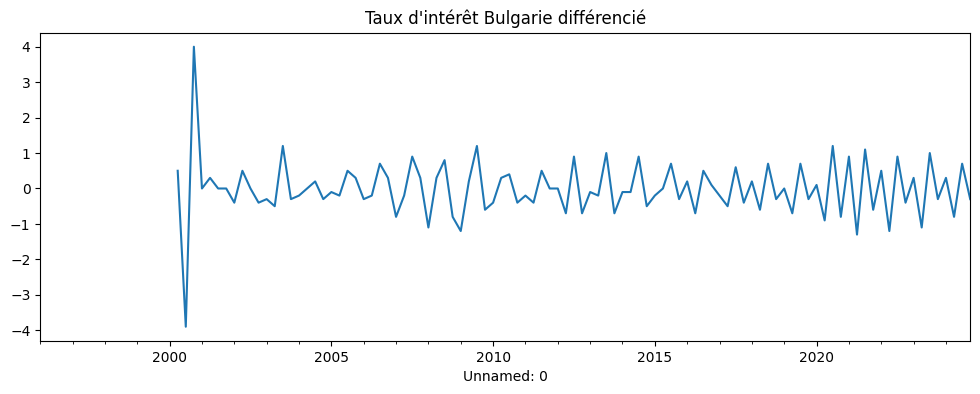

In [171]:
WH_Bulgaria_diff = df_clean_TS["WH_Bulgaria"].diff()
WH_Bulgaria_diff.plot(title="Taux d'intérêt Bulgarie différencié", figsize=(12, 4)) 

result = adfuller(WH_Bulgaria_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

<Figure size 1400x600 with 0 Axes>

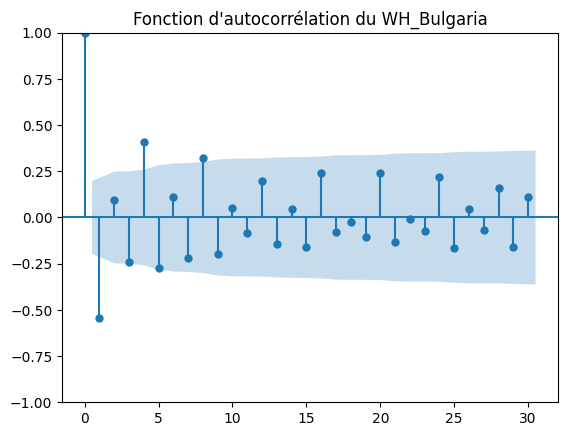

<Figure size 1400x600 with 0 Axes>

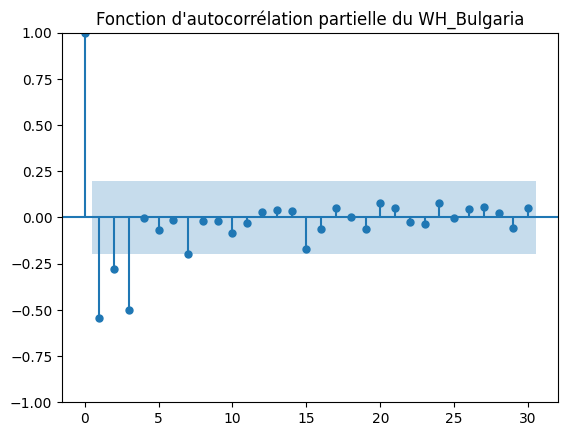

In [172]:
plt.figure(figsize=(14,6))
tsaplots.plot_acf(WH_Bulgaria_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du WH_Bulgaria")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(WH_Bulgaria_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du WH_Bulgaria")
plt.show()

In [173]:
WH_Bulgaria_models = evaluate_all_models(WH_Bulgaria_diff.dropna(), 3, 8)


Test du modèle ARIMA(0,0,1)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0454 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(0,0,2)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.1475 -> OK
 Modèle retenu.

Test du modèle ARIMA(0,0,3)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.1447 -> OK
 Modèle rejeté.

Test du modèle ARIMA(0,0,4)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.2192 -> OK
 Modèle retenu.

Test du modèle ARIMA(0,0,5)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.0482 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(0,0,6)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.1294 -> OK
 Modèle retenu.

Test du modèle ARIMA(0,0,7)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.0154 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(0,0,8)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.3569 -> OK
 Modèle rejeté.

Test du modèle ARIMA(1,0,0)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0000 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(1,0,1)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.1262 -> OK
 Modèle rejeté.

Test du modèle ARIMA(1,0,2)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.3248 -> OK
 Modèle retenu.

Test du modèle ARIMA(1,0,3)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.0747 -> OK
 Modèle rejeté.

Test du modèle ARIMA(1,0,4)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.3104 -> OK
 Modèle retenu.

Test du modèle ARIMA(1,0,5)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.2768 -> OK
 Modèle retenu.

Test du modèle ARIMA(1,0,6)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0677 -> OK
 Modèle retenu.

Test du modèle ARIMA(1,0,7)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.0065 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(1,0,8)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.1193 -> OK
 Modèle rejeté.

Test du modèle ARIMA(2,0,0)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0000 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(2,0,1)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.1241 -> OK
 Modèle rejeté.

Test du modèle ARIMA(2,0,2)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.3116 -> OK
 Modèle rejeté.

Test du modèle ARIMA(2,0,3)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0903 -> OK
 Modèle retenu.

Test du modèle ARIMA(2,0,4)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.3873 -> OK
 Modèle rejeté.

Test du modèle ARIMA(2,0,5)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.0081 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(2,0,6)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0561 -> OK
 Modèle rejeté.

Test du modèle ARIMA(2,0,7)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.1434 -> OK
 Modèle rejeté.

Test du modèle ARIMA(2,0,8)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.0201 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(3,0,0)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.4597 -> OK
 Modèle retenu.

Test du modèle ARIMA(3,0,1)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.2826 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,2)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.3112 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,3)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.3486 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,4)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.0864 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,5)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0590 -> OK
 Modèle retenu.

Test du modèle ARIMA(3,0,6)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.3913 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,7)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.5138 -> OK
 Modèle retenu.

Test du modèle ARIMA(3,0,8)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.0914 -> OK
 Modèle rejeté.

Résumé : modèles retenus
[(0, 2), (0, 4), (0, 6), (1, 2), (1, 4), (1, 5), (1, 6), (2, 3), (3, 0), (3, 5), (3, 7)]


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [174]:
compute_aic_bic(WH_Bulgaria_diff, WH_Bulgaria_models, 0)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\enriq\AppData\Local\Packages


Tableau AIC et BIC :
    p  d  q         AIC         BIC
0   3  0  0  167.449034  181.216985
1   1  0  4  172.093980  191.369111
2   1  0  6  169.438645  194.220956
3   0  0  6  172.306777  194.335499
4   1  0  5  172.781930  194.810652
5   1  0  2  183.097223  196.865174
6   3  0  5  170.561921  198.097823
7   0  0  2  188.322334  199.336695
8   2  0  3  181.280759  200.555890
9   3  0  7  170.984265  204.027348
10  0  0  4  187.701022  204.222563


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p  d  q         AIC         BIC
0   3  0  0  167.449034  181.216985
1   1  0  4  172.093980  191.369111
2   1  0  6  169.438645  194.220956
3   0  0  6  172.306777  194.335499
4   1  0  5  172.781930  194.810652
5   1  0  2  183.097223  196.865174
6   3  0  5  170.561921  198.097823
7   0  0  2  188.322334  199.336695
8   2  0  3  181.280759  200.555890
9   3  0  7  170.984265  204.027348
10  0  0  4  187.701022  204.222563

In [175]:
WH_Bulgaria_pred = backcast_arima(df_clean_TS, "WH_Bulgaria", (3,1,0), trend='t')
WH_Bulgaria_pred_final = WH_Bulgaria_pred.combine_first(df_clean_TS["WH_Bulgaria"])

C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData

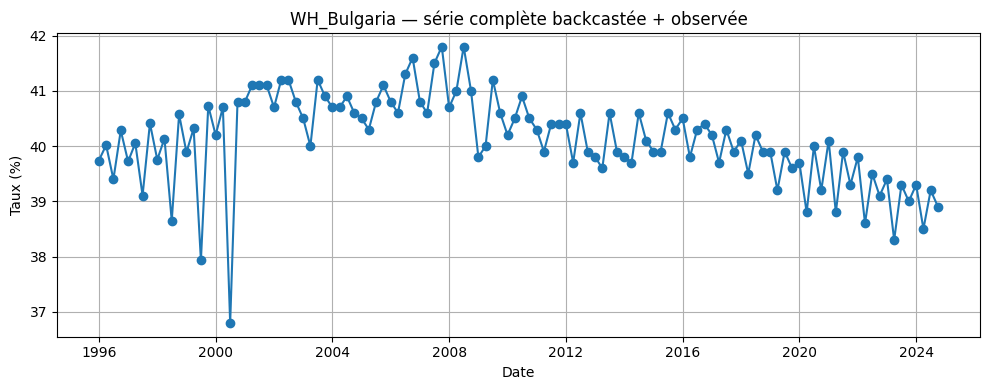

In [176]:
plt.figure(figsize=(10, 4))
plt.plot(WH_Bulgaria_pred_final.index, WH_Bulgaria_pred_final.values, marker='o', linestyle='-')
plt.title("WH_Bulgaria — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### WH_Lithuania <a class="anchor" id="partie222"></a>
ATTENTION, la série différenciée ne rejette pas le test ADF
Cette série a une composante saisonnière: on laisse tomber pour le moment

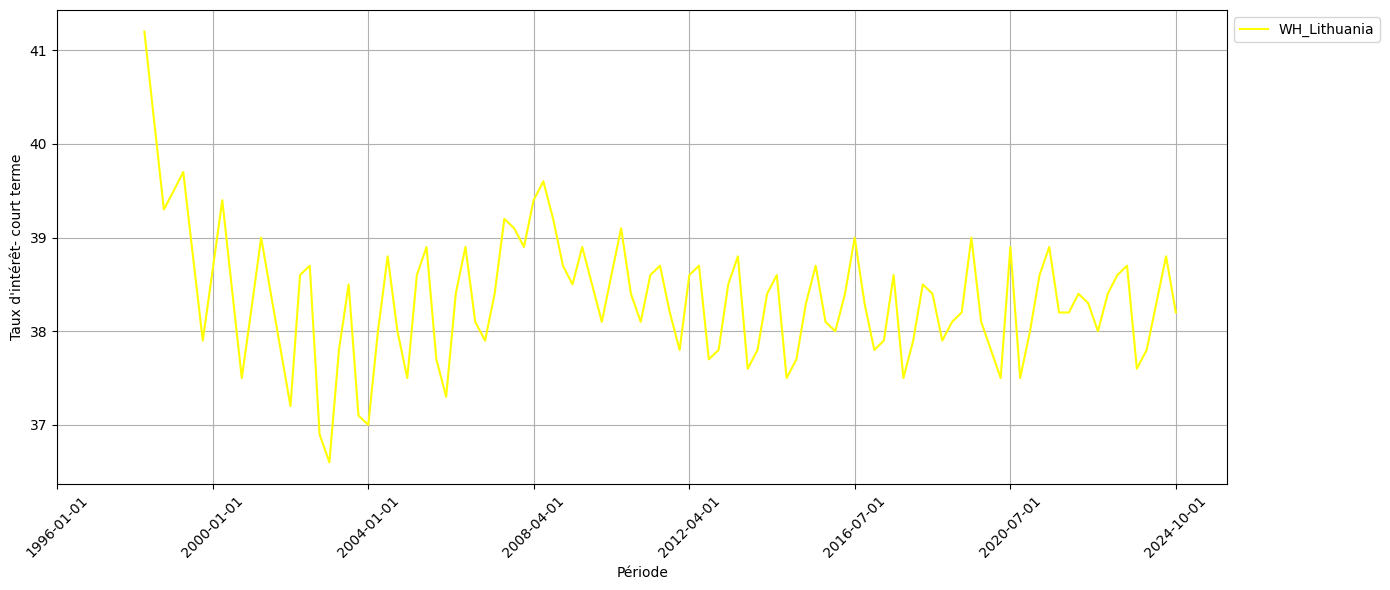

ADF Statistic: -2.6109312771161783
p-value: 0.09075897597072707


In [177]:
tracer_evolution(df_clean_TS, ["WH_Lithuania"], xlabel="Période", ylabel="Taux d'intérêt- court terme")
result = adfuller(df_clean_TS["WH_Lithuania"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -5.05633104086739
p-value: 1.714853122647168e-05


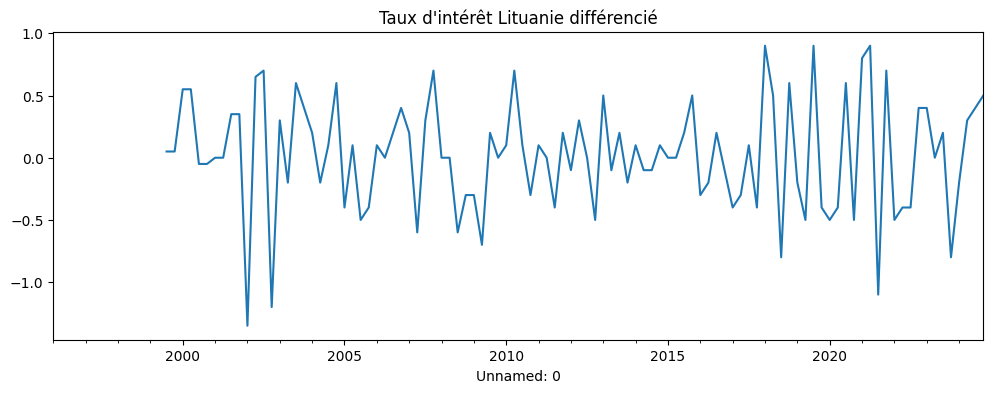

In [178]:
WH_Lithuania_diff = df_clean_TS["WH_Lithuania"].shift(4)  # saisonnalité
WH_Lithuania_diff = df_clean_TS["WH_Lithuania"] - WH_Lithuania_diff
WH_Lithuania_diff = WH_Lithuania_diff - WH_Lithuania_diff.shift(1)  # tendance


WH_Lithuania_diff.plot(title="Taux d'intérêt Lituanie différencié", figsize=(12, 4)) 

result = adfuller(WH_Lithuania_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

<Figure size 1400x600 with 0 Axes>

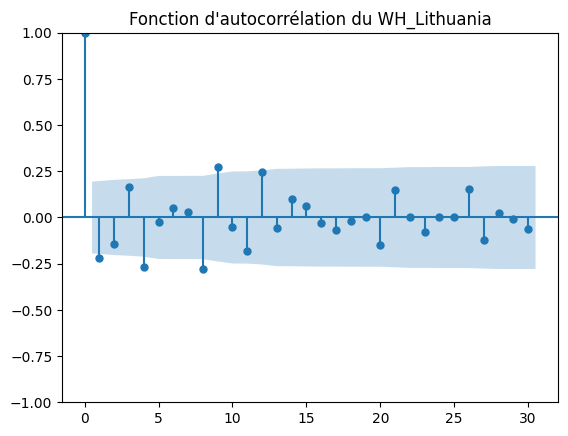

<Figure size 1400x600 with 0 Axes>

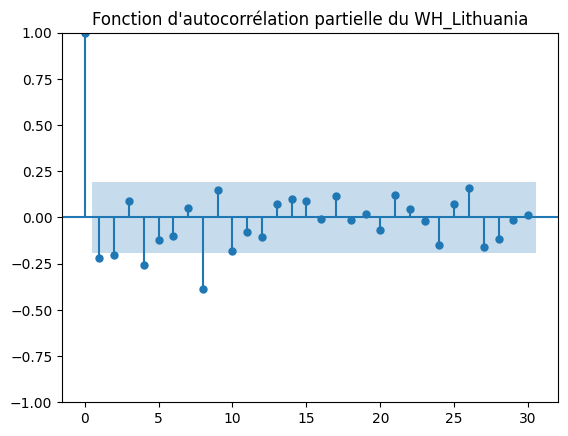

In [179]:
plt.figure(figsize=(14,6))
tsaplots.plot_acf(WH_Lithuania_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du WH_Lithuania")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(WH_Lithuania_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du WH_Lithuania")
plt.show()

In [180]:
#WH_Lithuania_models = evaluate_all_models(WH_Lithuania_diff.dropna(), 13, 16)


#### WH_Latvia <a class="anchor" id="partie223"></a>

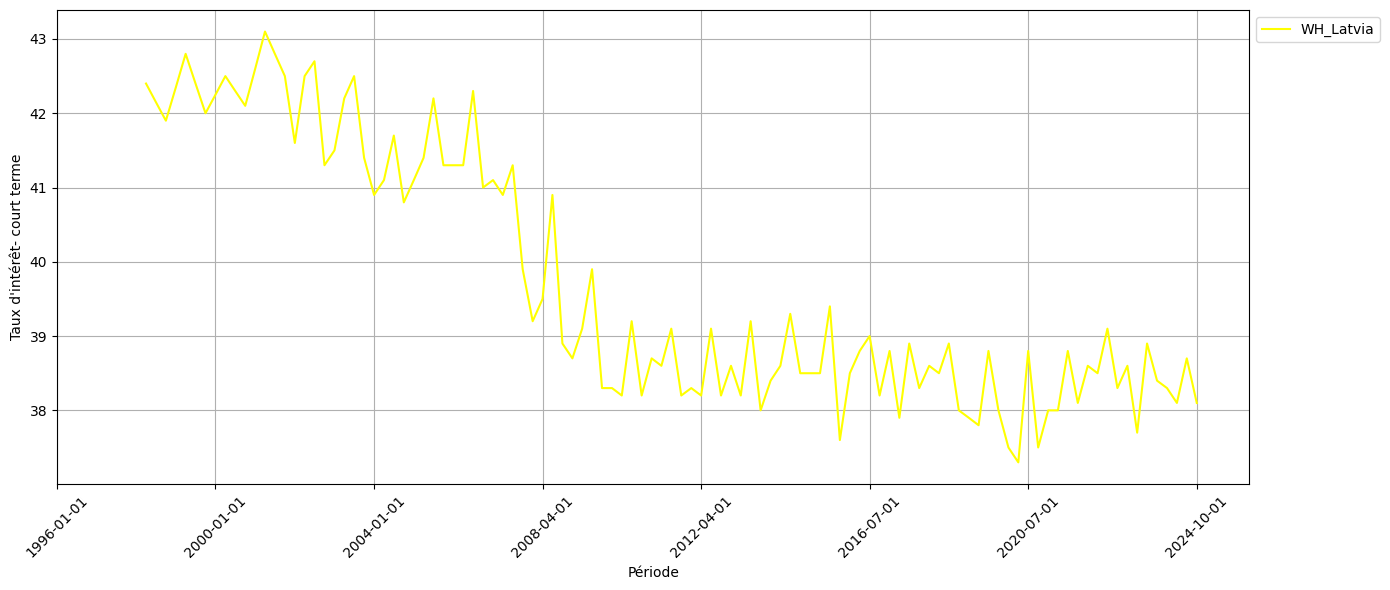

ADF Statistic: -1.8195039374033954
p-value: 0.370822421215641


In [181]:
tracer_evolution(df_clean_TS, ["WH_Latvia"], xlabel="Période", ylabel="Taux d'intérêt- court terme")

result = adfuller(df_clean_TS["WH_Latvia"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -2.9834384067096447
p-value: 0.03647025856422123


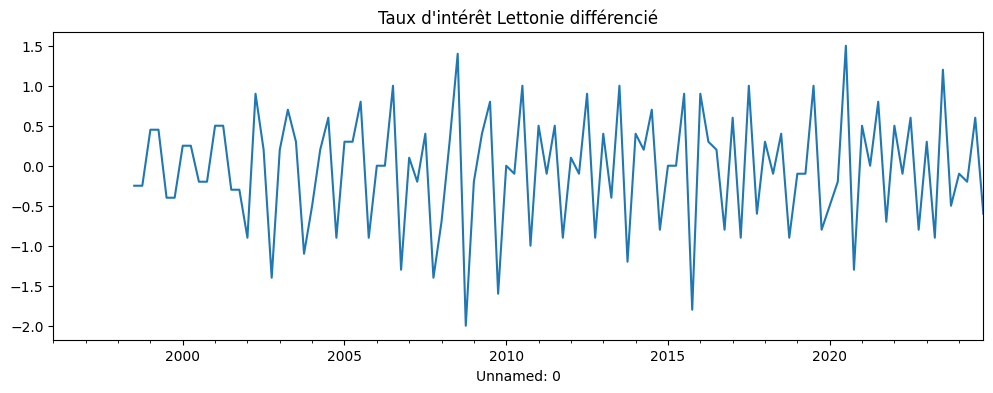

In [182]:
WH_Latvia_diff = df_clean_TS["WH_Latvia"].diff()
WH_Latvia_diff.plot(title="Taux d'intérêt Lettonie différencié", figsize=(12, 4)) 

result = adfuller(WH_Latvia_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

<Figure size 1400x600 with 0 Axes>

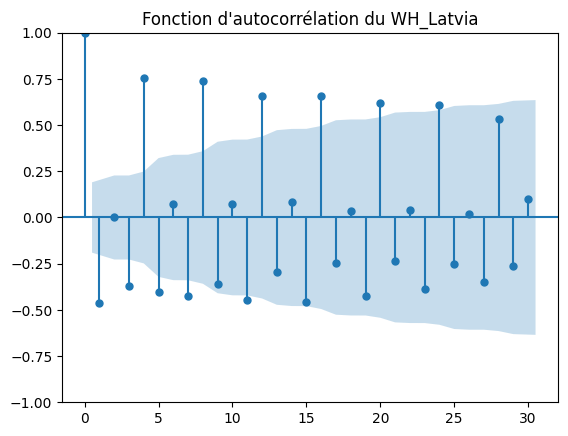

<Figure size 1400x600 with 0 Axes>

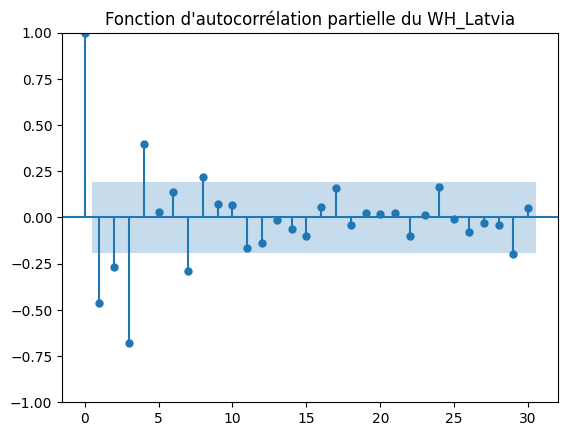

In [183]:
plt.figure(figsize=(14,6))
tsaplots.plot_acf(WH_Latvia_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du WH_Latvia")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(WH_Latvia_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du WH_Latvia")
plt.show()

#### WH_Slovakia <a class="anchor" id="partie224"></a>

#### WH_Poland <a class="anchor" id="partie225"></a>

#### WH_Czechia <a class="anchor" id="partie226"></a>

#### WH_Romania <a class="anchor" id="partie227"></a>

### ST_IR <a class="anchor" id="partie23"></a>

#### ST_IR_Switzerland <a class="anchor" id="partie231"></a>

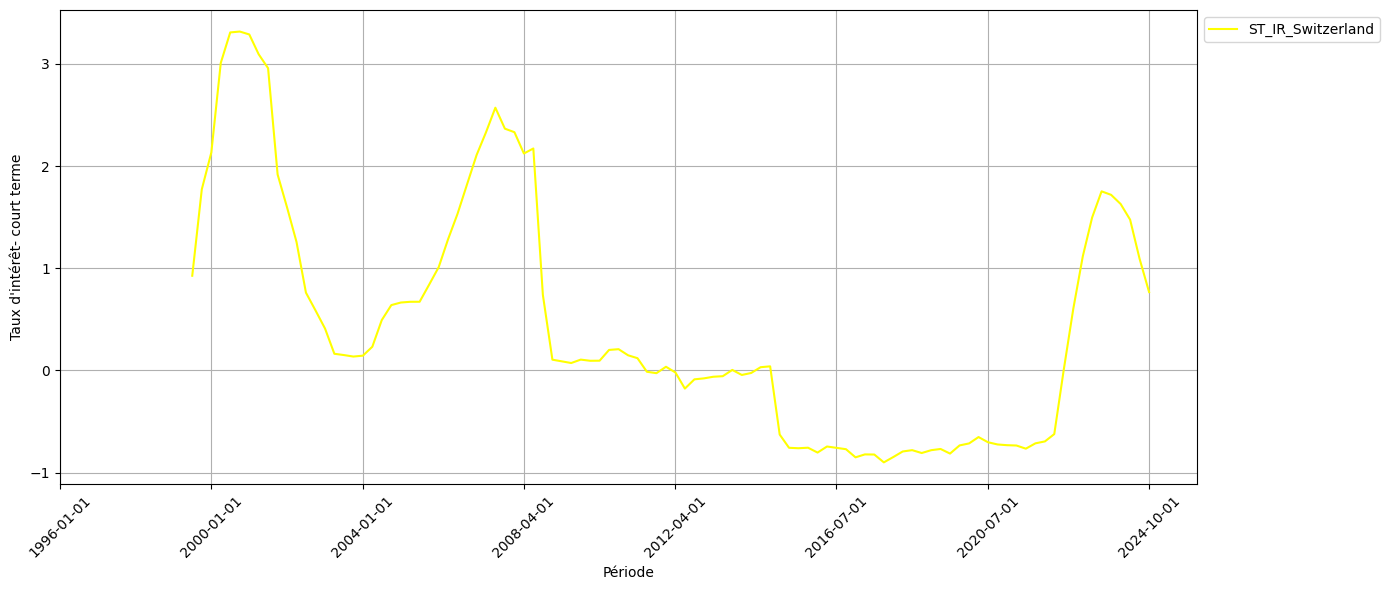

ADF Statistic: -2.5857713058530982
p-value: 0.09597385312741918


In [223]:
tracer_evolution(df_clean_TS, ["ST_IR_Switzerland"], xlabel="Période", ylabel="Taux d'intérêt- court terme")
result = adfuller(df_clean_TS["ST_IR_Switzerland"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -5.894813968751875
p-value: 2.8679604111724724e-07


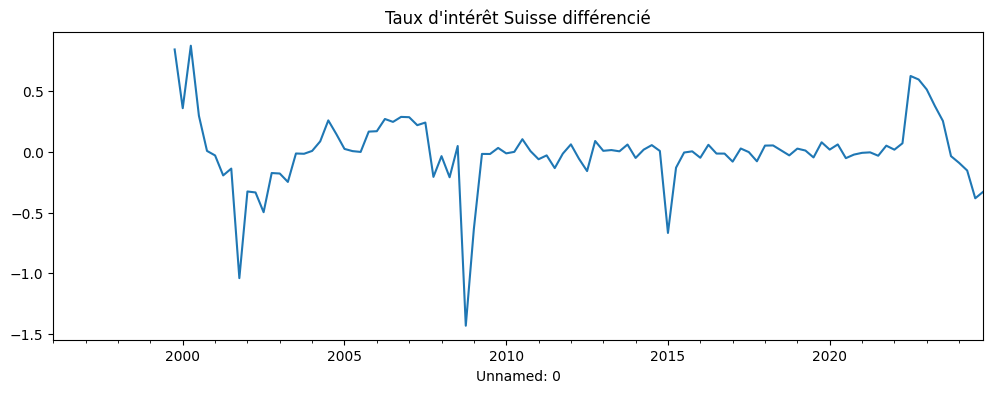

In [224]:
ST_IR_Switzerland_diff = df_clean_TS["ST_IR_Switzerland"].diff()
ST_IR_Switzerland_diff.plot(title="Taux d'intérêt Suisse différencié", figsize=(12, 4))
result = adfuller(ST_IR_Switzerland_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

<Figure size 1400x600 with 0 Axes>

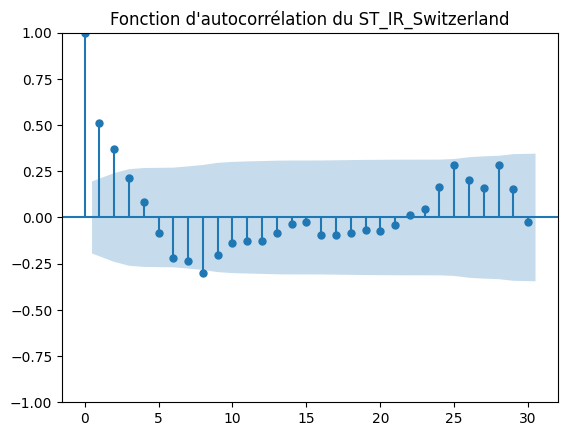

<Figure size 1400x600 with 0 Axes>

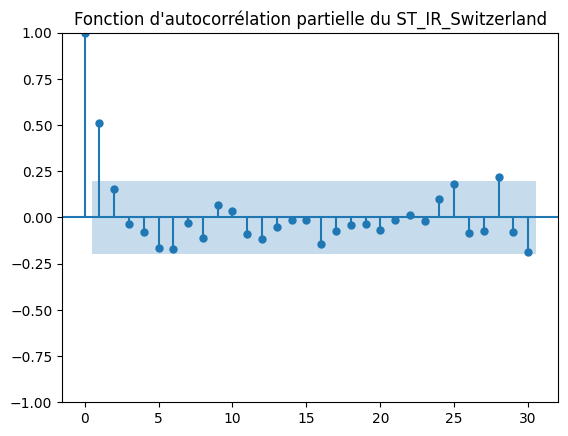

In [225]:
plt.figure(figsize=(14,6))
tsaplots.plot_acf(ST_IR_Switzerland_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du ST_IR_Switzerland")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(ST_IR_Switzerland_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du ST_IR_Switzerland")
plt.show()

In [226]:
ST_IR_Switzerland_models = evaluate_all_models(ST_IR_Switzerland_diff.dropna(), 1, 2)



Test du modèle ARIMA(0,0,1)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0103 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(0,0,2)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.3912 -> OK
 Modèle retenu.

Test du modèle ARIMA(1,0,0)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.6453 -> OK
 Modèle retenu.

Test du modèle ARIMA(1,0,1)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.7798 -> OK
 Modèle rejeté.

Test du modèle ARIMA(1,0,2)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.8190 -> OK
 Modèle rejeté.

Résumé : modèles retenus
[(0, 2), (1, 0)]


In [227]:
compute_aic_bic(ST_IR_Switzerland_diff, ST_IR_Switzerland_models, 0)



Tableau AIC et BIC :
   p  d  q        AIC        BIC
0  1  0  0  10.604057  18.864828
1  0  0  2  16.080411  27.094772


p  d  q        AIC        BIC
0  1  0  0  10.604057  18.864828
1  0  0  2  16.080411  27.094772

In [228]:
ST_IR_Switzerland_pred = backcast_arima(df_clean_TS, "ST_IR_Switzerland", (1,1,0), trend='t')
ST_IR_Switzerland_pred_final = ST_IR_Switzerland_pred.combine_first(df_clean_TS["ST_IR_Switzerland"])

C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData

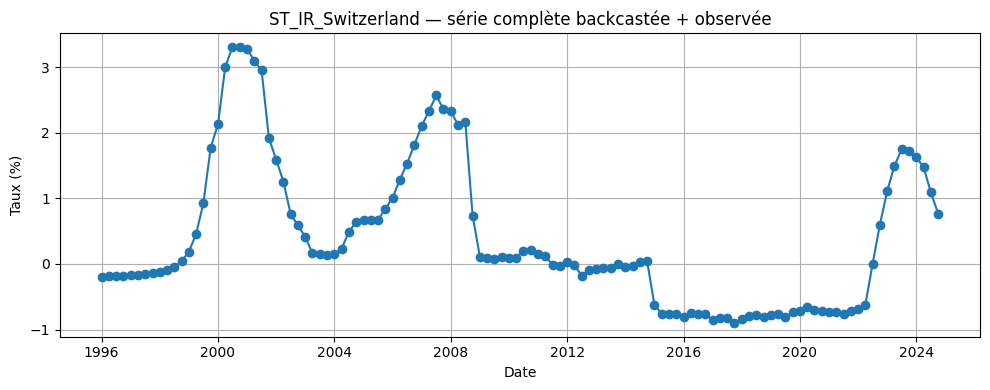

In [229]:
plt.figure(figsize=(10, 4))
plt.plot(ST_IR_Switzerland_pred_final.index, ST_IR_Switzerland_pred_final.values, marker='o', linestyle='-')
plt.title("ST_IR_Switzerland — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### ST_IR_Lithuania <a class="anchor" id="partie232"></a>

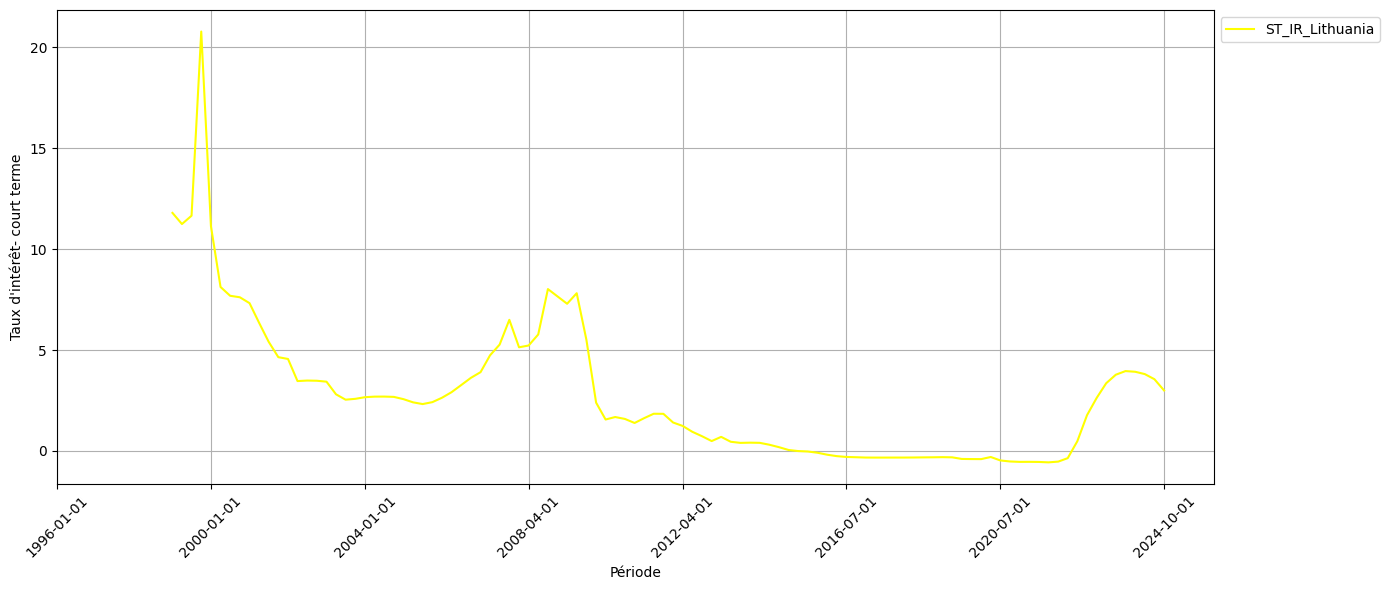

ADF Statistic: -2.4263284335329183
p-value: 0.13444285837946907


In [191]:


tracer_evolution(df_clean_TS, ["ST_IR_Lithuania"], xlabel="Période", ylabel="Taux d'intérêt- court terme")
result = adfuller(df_clean_TS["ST_IR_Lithuania"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -4.338104685843668
p-value: 0.0003813524328505752


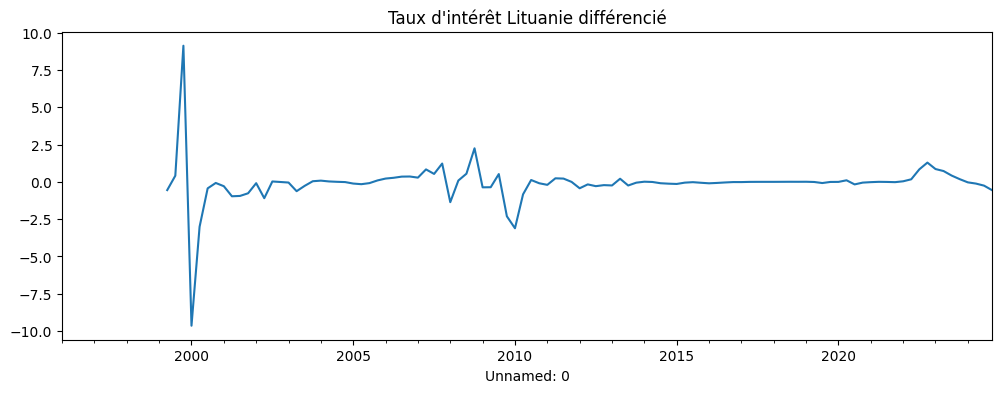

In [192]:
ST_IR_Lithuania_diff = df_clean_TS["ST_IR_Lithuania"].diff()
ST_IR_Lithuania_diff.plot(title="Taux d'intérêt Lituanie différencié", figsize=(12, 4))

result = adfuller(ST_IR_Lithuania_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

<Figure size 1400x600 with 0 Axes>

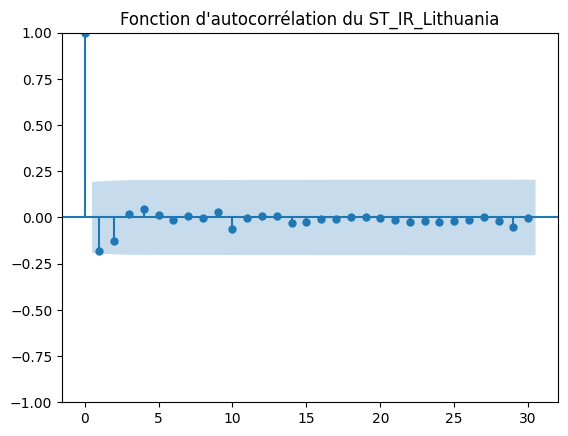

<Figure size 1400x600 with 0 Axes>

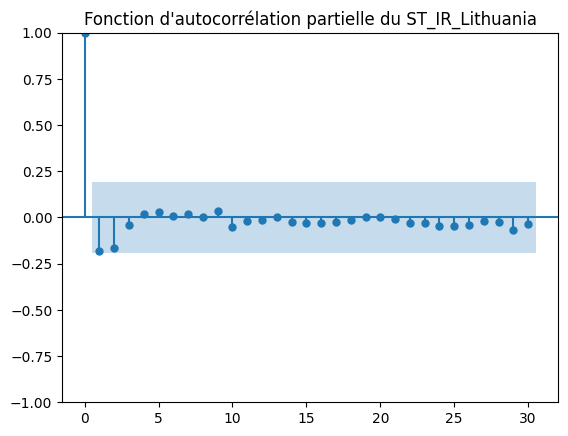

In [193]:
plt.figure(figsize=(14,6))
tsaplots.plot_acf(ST_IR_Lithuania_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du ST_IR_Lithuania")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(ST_IR_Lithuania_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du ST_IR_Lithuania")
plt.show()


In [194]:
ST_IR_Lithuania_models = evaluate_all_models(ST_IR_Lithuania_diff.dropna(), 2, 1)



Test du modèle ARIMA(0,0,1)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.9997 -> OK
 Modèle retenu.

Test du modèle ARIMA(1,0,0)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.9970 -> OK
 Modèle retenu.

Test du modèle ARIMA(1,0,1)
 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 1.0000 -> OK
 Modèle rejeté.

Test du modèle ARIMA(2,0,0)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 1.0000 -> OK
 Modèle retenu.

Test du modèle ARIMA(2,0,1)
 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 1.0000 -> OK
 Modèle rejeté.

Résumé : modèles retenus
[(0, 1), (1, 0), (2, 0)]


In [195]:
compute_aic_bic(ST_IR_Lithuania_diff, ST_IR_Lithuania_models, 0)



Tableau AIC et BIC :
   p  d  q         AIC         BIC
0  0  0  1  372.245438  380.506208
1  1  0  0  373.603102  381.863872
2  2  0  0  372.831664  383.846025


p  d  q         AIC         BIC
0  0  0  1  372.245438  380.506208
1  1  0  0  373.603102  381.863872
2  2  0  0  372.831664  383.846025

In [196]:
ST_IR_Lithuania_pred = backcast_arima(df_clean_TS, "ST_IR_Lithuania", (0,1,1), trend='t')
ST_IR_Lithuania_pred_final = ST_IR_Lithuania_pred.combine_first(df_clean_TS["ST_IR_Lithuania"])


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData

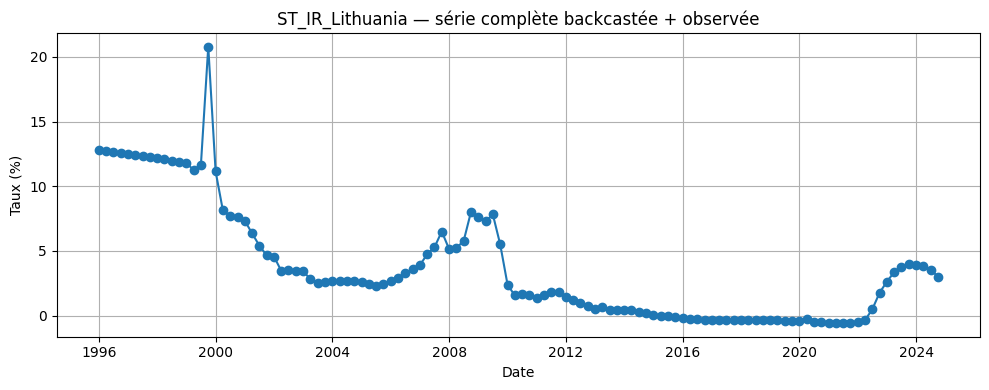

In [197]:
plt.figure(figsize=(10, 4))
plt.plot(ST_IR_Lithuania_pred_final.index, ST_IR_Lithuania_pred_final.values, marker='o', linestyle='-')
plt.title("ST_IR_Lithuania — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### ST_IR_Luxembourg <a class="anchor" id="partie233"></a>

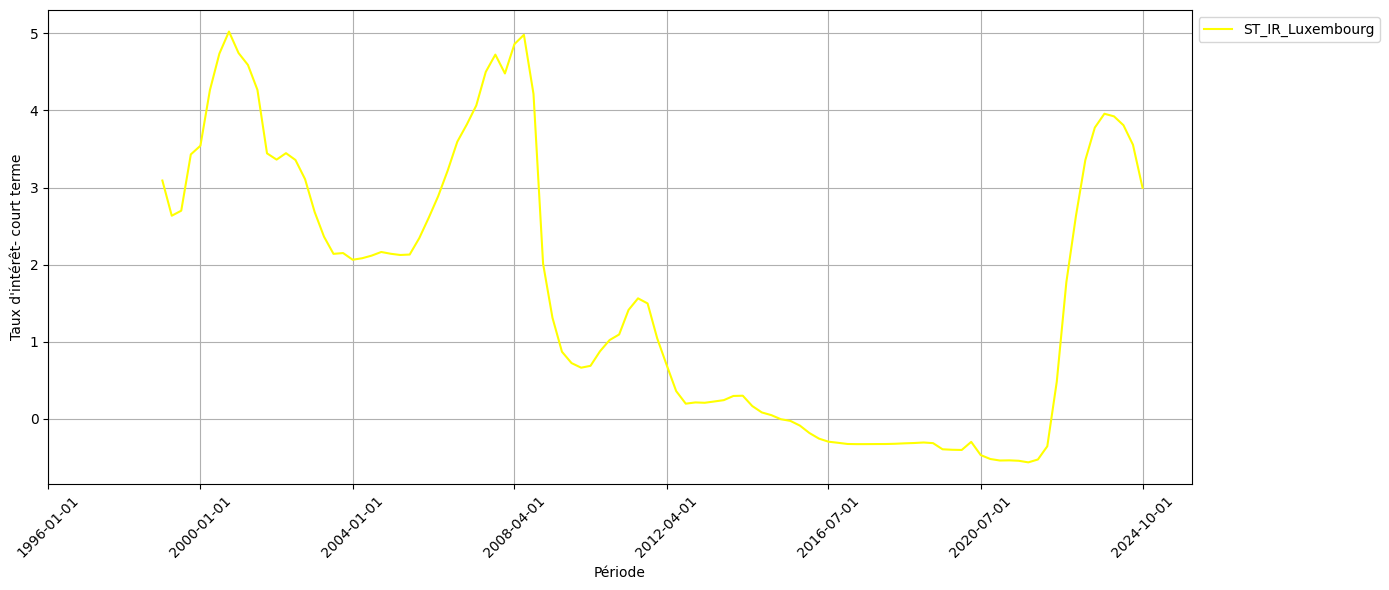

ADF Statistic: -2.3418711308173314
p-value: 0.15881895749740932


In [198]:
tracer_evolution(df_clean_TS, ["ST_IR_Luxembourg"], xlabel="Période", ylabel="Taux d'intérêt- court terme")
result = adfuller(df_clean_TS["ST_IR_Luxembourg"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -4.8124571259465165
p-value: 5.147901595498498e-05


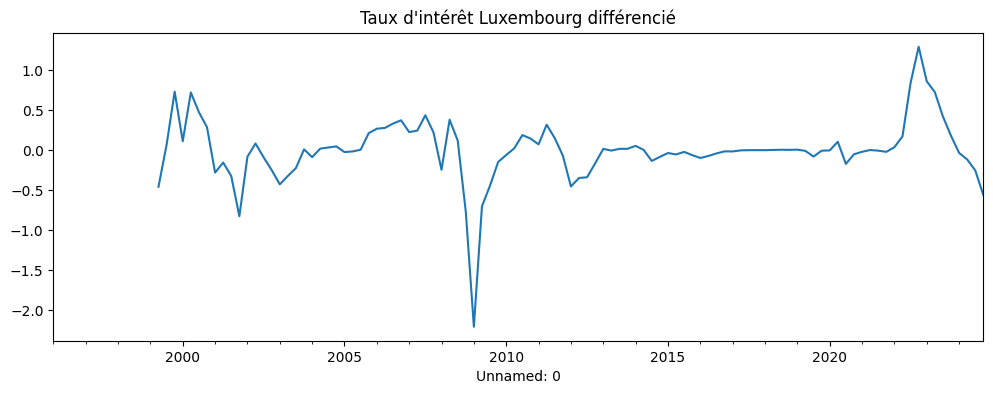

In [199]:
ST_IR_Luxembourg_diff = df_clean_TS["ST_IR_Luxembourg"].diff()
ST_IR_Luxembourg_diff.plot(title="Taux d'intérêt Luxembourg différencié", figsize=(12, 4))

result = adfuller(ST_IR_Luxembourg_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

<Figure size 1400x600 with 0 Axes>

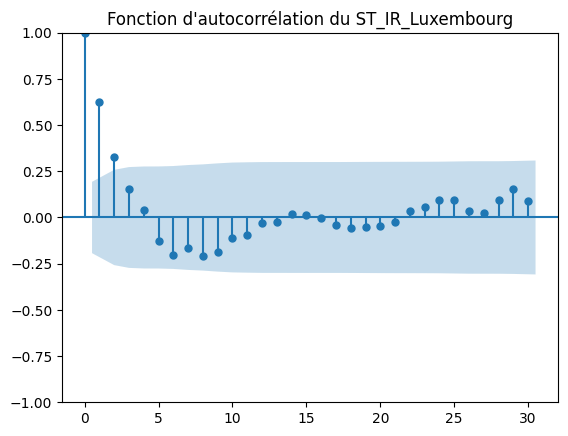

<Figure size 1400x600 with 0 Axes>

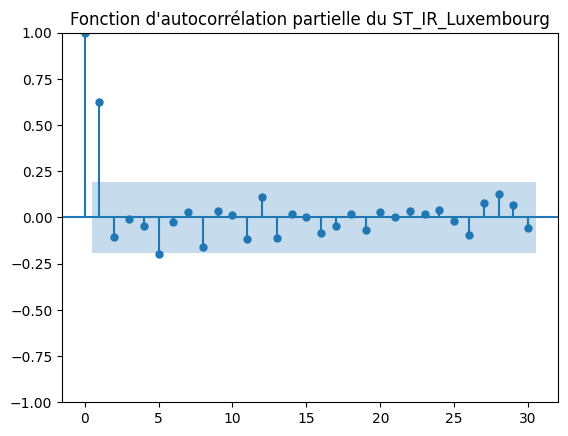

In [200]:
plt.figure(figsize=(14,6))
tsaplots.plot_acf(ST_IR_Luxembourg_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du ST_IR_Luxembourg")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(ST_IR_Luxembourg_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du ST_IR_Luxembourg")
plt.show()

In [201]:
ST_IR_Luxembourg_models = evaluate_all_models(ST_IR_Luxembourg_diff.dropna(), 5, 2)



Test du modèle ARIMA(0,0,1)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0230 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(0,0,2)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.4682 -> OK
 Modèle retenu.

Test du modèle ARIMA(1,0,0)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.7451 -> OK
 Modèle retenu.

Test du modèle ARIMA(1,0,1)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.7418 -> OK
 Modèle rejeté.

Test du modèle ARIMA(1,0,2)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.4123 -> OK
 Modèle retenu.

Test du modèle ARIMA(2,0,0)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.7212 -> OK
 Modèle rejeté.

Test du modèle ARIMA(2,0,1)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.9052 -> OK
 Modèle rejeté.

Test du modèle ARIMA(2,0,2)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.4137 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,0)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.7067 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,1)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.6992 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,2)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.9568 -> OK
 Modèle rejeté.

Test du modèle ARIMA(4,0,0)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.7388 -> OK
 Modèle rejeté.

Test du modèle ARIMA(4,0,1)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.7020 -> OK
 Modèle rejeté.

Test du modèle ARIMA(4,0,2)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.9569 -> OK
 Modèle rejeté.

Test du modèle ARIMA(5,0,0)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.8156 -> OK
 Modèle retenu.

Test du modèle ARIMA(5,0,1)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.8237 -> OK
 Modèle rejeté.

Test du modèle ARIMA(5,0,2)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.9209 -> OK
 Modèle rejeté.

Résumé : modèles retenus
[(0, 2), (1, 0), (1, 2), (5, 0)]


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [202]:
compute_aic_bic(ST_IR_Luxembourg_diff, ST_IR_Luxembourg_models, 0)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Tableau AIC et BIC :
   p  d  q        AIC        BIC
0  1  0  0  47.483396  55.744167
1  0  0  2  46.736310  57.750670
2  1  0  2  47.284693  61.052644
3  5  0  0  46.555768  65.830899


p  d  q        AIC        BIC
0  1  0  0  47.483396  55.744167
1  0  0  2  46.736310  57.750670
2  1  0  2  47.284693  61.052644
3  5  0  0  46.555768  65.830899

In [203]:
ST_IR_Luxembourg_pred = backcast_arima(df_clean_TS, "ST_IR_Luxembourg", (1,1,0), trend='t')
ST_IR_Luxembourg_pred_final = ST_IR_Luxembourg_pred.combine_first(df_clean_TS["ST_IR_Luxembourg"])


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData

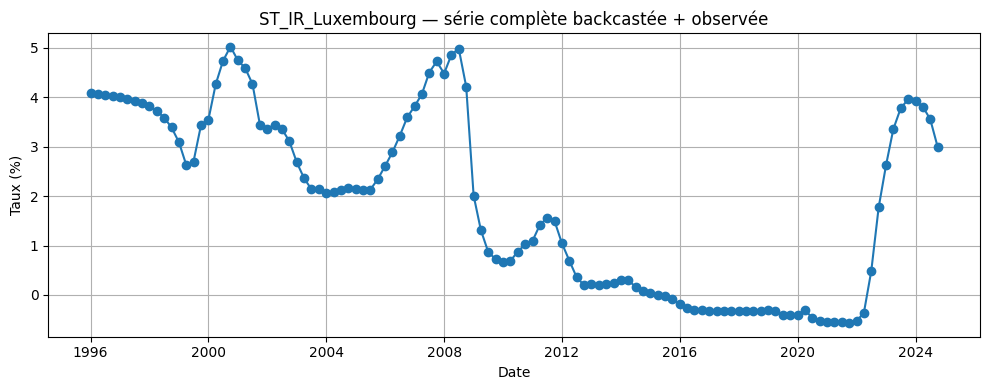

In [204]:
plt.figure(figsize=(10, 4))
plt.plot(ST_IR_Luxembourg_pred_final.index, ST_IR_Luxembourg_pred_final.values, marker='o', linestyle='-')
plt.title("ST_IR_Luxembourg — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### ST_IR_Latvia <a class="anchor" id="partie233"></a>

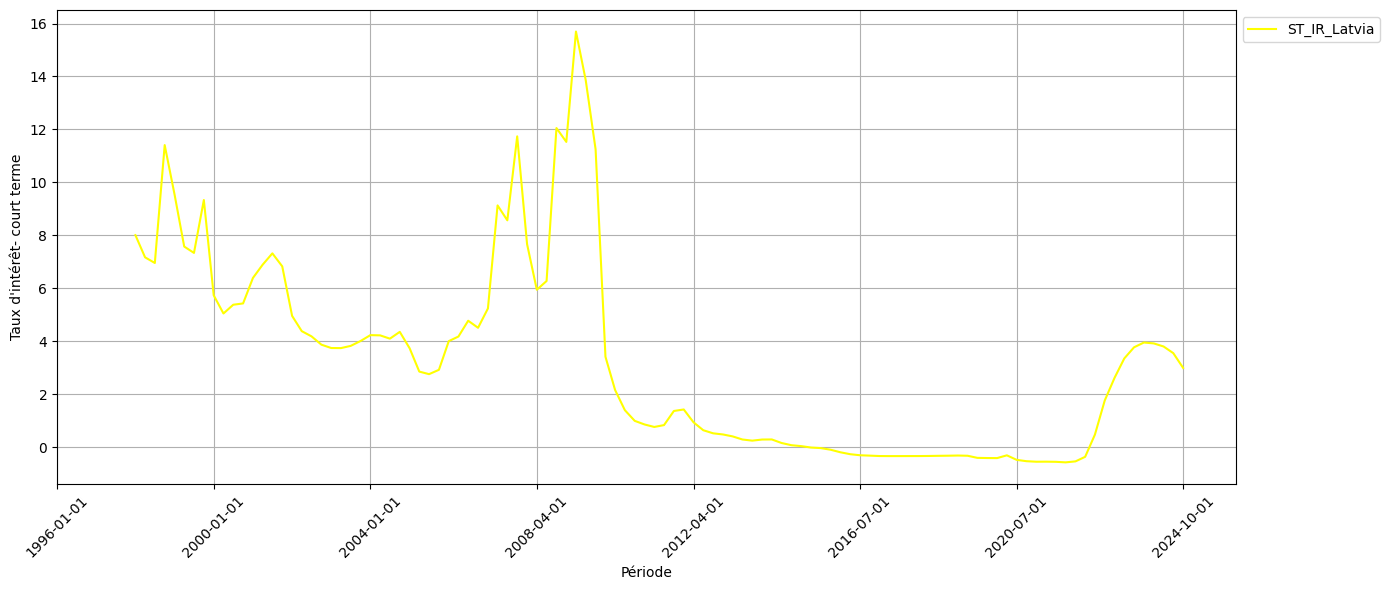

ADF Statistic: -2.0253273445263575
p-value: 0.2755795261426921


In [205]:
tracer_evolution(df_clean_TS, ["ST_IR_Latvia"], xlabel="Période", ylabel="Taux d'intérêt- court terme")


result = adfuller(df_clean_TS["ST_IR_Latvia"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -4.700449641981913
p-value: 8.39892608634731e-05


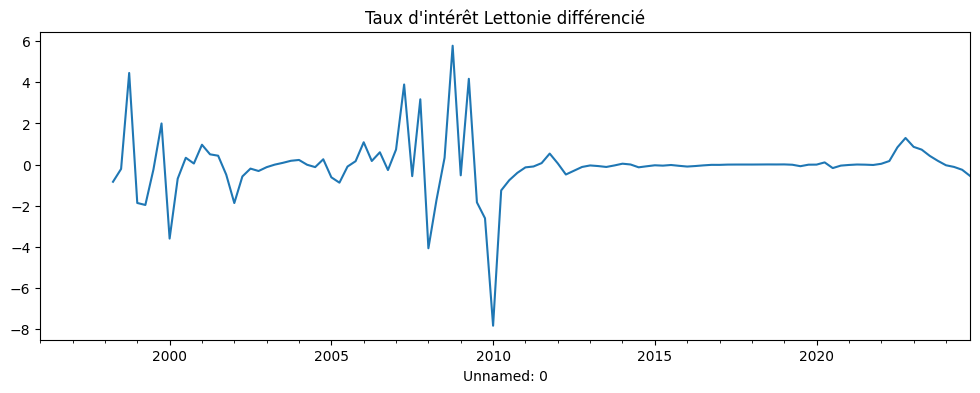

In [206]:
ST_IR_Latvia_diff = df_clean_TS["ST_IR_Latvia"].diff()
ST_IR_Latvia_diff.plot(title="Taux d'intérêt Lettonie différencié", figsize=(12, 4))

result = adfuller(ST_IR_Latvia_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

<Figure size 1400x600 with 0 Axes>

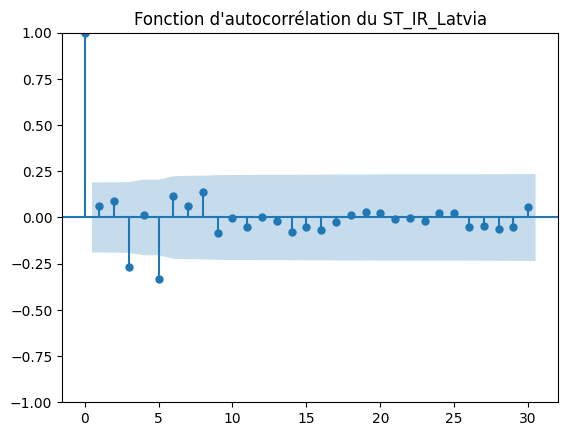

<Figure size 1400x600 with 0 Axes>

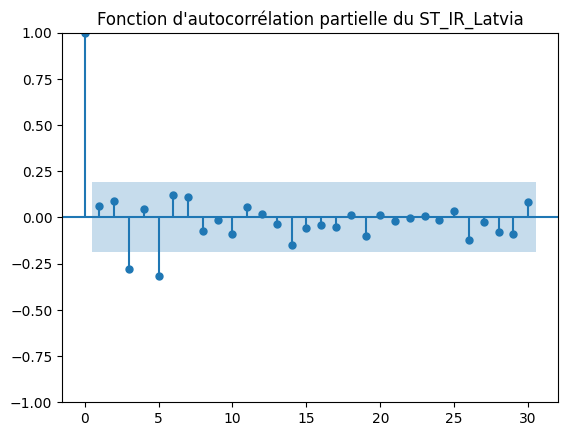

In [207]:
plt.figure(figsize=(14,6))
tsaplots.plot_acf(ST_IR_Latvia_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du ST_IR_Latvia")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(ST_IR_Latvia_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du ST_IR_Latvia")
plt.show()

In [208]:
#ST_IR_Latvia_models = evaluate_all_models(ST_IR_Latvia_diff.dropna(), 5, 5)


In [209]:
compute_aic_bic(ST_IR_Latvia_diff, ST_IR_Latvia_models, 0)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Tableau AIC et BIC :
   p  d  q         AIC         BIC
0  1  0  2  380.213714  393.981665
1  1  0  3  378.794009  395.315550
2  0  0  5  376.210100  395.485231
3  5  0  0  376.639550  395.914682
4  3  0  0  384.427257  398.195208
5  3  0  1  381.700505  398.222047
6  2  0  1  385.156407  398.924358
7  0  0  3  385.730801  399.498752
8  3  0  5  377.077847  404.613749
9  3  0  4  382.250692  407.033004


p  d  q         AIC         BIC
0  1  0  2  380.213714  393.981665
1  1  0  3  378.794009  395.315550
2  0  0  5  376.210100  395.485231
3  5  0  0  376.639550  395.914682
4  3  0  0  384.427257  398.195208
5  3  0  1  381.700505  398.222047
6  2  0  1  385.156407  398.924358
7  0  0  3  385.730801  399.498752
8  3  0  5  377.077847  404.613749
9  3  0  4  382.250692  407.033004

In [210]:
ST_IR_Latvia_pred = backcast_arima(df_clean_TS, "ST_IR_Latvia", (1,1,2), trend='t')
ST_IR_Latvia_pred_final = ST_IR_Latvia_pred.combine_first(df_clean_TS["ST_IR_Latvia"])


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData

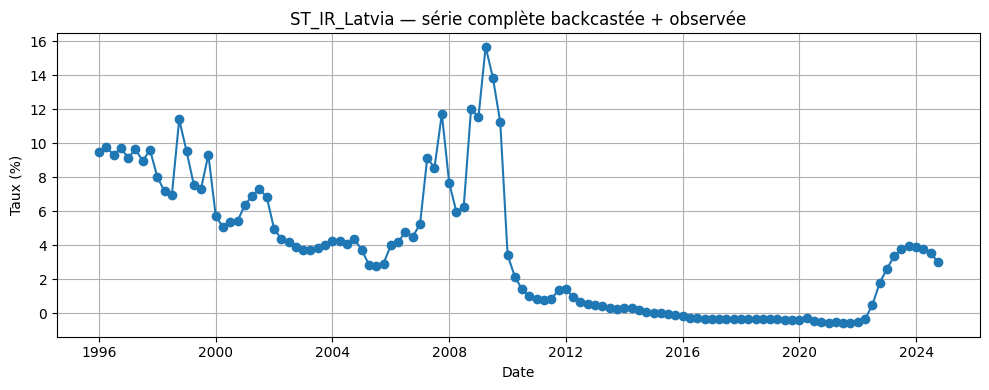

In [211]:
plt.figure(figsize=(10, 4))
plt.plot(ST_IR_Latvia_pred_final.index, ST_IR_Latvia_pred_final.values, marker='o', linestyle='-')
plt.title("ST_IR_Latvia — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

### P_Growth <a class="anchor" id="partie24"></a>

In [212]:
from numpy.polynomial import Polynomial

def forecast_polynomial(df, col, degree=3):
    """
    Remplit les NaN à la fin d'une série par une régression polynomiale.

    Paramètres :
    - df : DataFrame contenant la série
    - col : nom de la colonne cible
    - degree : degré du polynôme à ajuster

    Retour :
    - pd.Series complète avec prédiction sur les NaN de fin
    """
    y = df[col]
    valid_y = y.dropna()
    
    if len(valid_y) < degree + 1:
        raise ValueError("Pas assez de points pour ajuster un polynôme.")

    # Indices des points observés
    x_obs = np.arange(len(valid_y))
    y_obs = valid_y.values

    # Ajustement polynômial
    poly = Polynomial.fit(x_obs, y_obs, deg=degree)

    # Indices de toute la série
    x_full = np.arange(len(y))
    y_pred_full = poly(x_full)

    # Création de la série prédite
    y_pred_series = pd.Series(y_pred_full, index=y.index, name=col)

    # Remplissage uniquement des NaN à la fin
    return y.combine_first(y_pred_series)

df_clean_TS

CPI_Austria  PIB_Austria  LT_IR_Austria  ST_IR_Austria  \
Unnamed: 0                                                           
1996-01-01    71.553333      44641.2       6.396633       3.476667   
1996-04-01    71.716667      46885.1       6.505600       3.266667   
1996-07-01    71.763333      46969.6       6.430133       3.420000   
1996-10-01    72.053333      47418.5       5.953500       3.330000   
1997-01-01    72.463333      44369.0       5.709800       3.323333   
...                 ...          ...            ...            ...   
2023-10-01   132.593333     122280.3       3.125533       3.957456   
2024-01-01   133.326667     117154.2       2.835333       3.923615   
2024-04-01   134.366667     120629.4       3.013533       3.808172   
2024-07-01   133.950000     118597.7       2.809900       3.555377   
2024-10-01   135.183333     125558.8       2.712067       2.996487   

            WH_Austria  P_Growth_Austria  CPI_Belgium  PIB_Belgium  \
Unnamed: 0                                                           
1996-01-01        39.8          2.573010    70.003333      54240.0   
1996-04-01        39.9          2.577419    70.516667      55590.7   
1996-07-01        40.0          2.580149    70.446667      53541.2   
1996-10-01        40.1          2.581239    70.936667      56570.4   
1997-01-01        40.2          2.580730    71.246667      53907.0   
...                ...               ...          ...          ...   
2023-10-01        32.9               NaN   127.550000     158085.7   
2024-01-01        34.0               NaN   129.700000     147812.8   
2024-04-01        32.9               NaN   131.086667     154840.7   
2024-07-01        34.5               NaN   131.900000     147978.8   
2024-10-01        33.9               NaN   133.383333     163905.7   

            LT_IR_Belgium  ST_IR_Belgium  ...  inflation_Norway  \
Unnamed: 0                                ...                     
1996-01-01       6.640000       3.350000  ...               NaN   
1996-04-01       6.713333       3.243333  ...               NaN   
1996-07-01       6.616667       3.230000  ...               NaN   
1996-10-01       6.000000       3.043333  ...               NaN   
1997-01-01       5.796667       3.203333  ...          3.269231   
...                   ...            ...  ...               ...   
2023-10-01       3.150000       3.957456  ...          4.289056   
2024-01-01       2.890000       3.923615  ...          4.220611   
2024-04-01       3.063333       3.808172  ...          2.754612   
2024-07-01       2.893333       3.555377  ...          2.446406   
2024-10-01       2.853333       2.996487  ...          1.944167   

            inflation_Poland  inflation_Portugal  inflation_Romania  \
Unnamed: 0                                                            
1996-01-01               NaN                 NaN                NaN   
1996-04-01               NaN                 NaN                NaN   
1996-07-01               NaN                 NaN                NaN   
1996-10-01               NaN                 NaN                NaN   
1997-01-01         17.188694            2.534330         116.062802   
...                      ...                 ...                ...   
2023-10-01          6.285155            2.445435           7.408689   
2024-01-01          3.638082            2.463167           7.051174   
2024-04-01          2.915992            3.074050           5.784928   
2024-07-01          4.102921            2.334026           5.302571   
2024-10-01          4.003682            2.805354           5.284833   

            inflation_Slovakia  inflation_Slovenia  inflation_Spain  \
Unnamed: 0                                                            
1996-01-01                 NaN                 NaN              NaN   
1996-04-01                 NaN                 NaN              NaN   
1996-07-01                 NaN                 NaN              NaN   
1996-10-01                 NaN         

In [213]:
#Nous allons automatiser le processus de complétion des données manquantes pour la croissance potentielle. 
def forecast_polynomial_automation(df, noms_pays):
    result={}
    for country in noms_pays:
        nouvelle_series=forecast_polynomial(df,f'P_Growth_{country}')
        result[f'P_Growth_{country}']=nouvelle_series
    final_df=pd.DataFrame(result)
    return final_df


countries_selected=[
    "Austria", "Belgium", "Bulgaria", "Czechia", "Denmark", 
    "Finland", "France", "Germany", "Greece", "Hungary", "Iceland", 
    "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Netherlands", 
    "Norway", "Poland", "Portugal", "Romania", "Slovakia",
    "Slovenia", "Spain", "Sweden", "Switzerland", "United_Kingdom"
]

P_Growth_forecasts=forecast_polynomial_automation(df_clean_TS,countries_selected)
P_Growth_forecasts



P_Growth_Austria  P_Growth_Belgium  P_Growth_Bulgaria  \
Unnamed: 0                                                          
1996-01-01          2.573010          2.513766           4.935537   
1996-04-01          2.577419          2.519938           5.087906   
1996-07-01          2.580149          2.524483           5.228971   
1996-10-01          2.581239          2.527441           5.358971   
1997-01-01          2.580730          2.528848           5.478146   
...                      ...               ...                ...   
2023-10-01          1.479266          1.797657           6.030074   
2024-01-01          1.535828          1.858033           6.391745   
2024-04-01          1.595046          1.921050           6.768731   
2024-07-01          1.656961          1.986748           7.161273   
2024-10-01          1.721611          2.055165           7.569609   

            P_Growth_Czechia  P_Growth_Denmark  P_Growth_Finland  \
Unnamed: 0                                                         
1996-01-01          0.427708          3.151393          4.196409   
1996-04-01          0.643293          3.068197          4.217698   
1996-07-01          0.849160          2.986544          4.233291   
1996-10-01          1.045490          2.906433          4.243338   
1997-01-01          1.232458          2.827865          4.247988   
...                      ...               ...               ...   
2023-10-01          4.554075          3.332566          4.999439   
2024-01-01          4.778727          3.420568          5.302633   
2024-04-01          5.013438          3.510112          5.616752   
2024-07-01          5.258385          3.601199          5.941946   
2024-10-01          5.513747          3.693829          6.278365   

            P_Growth_France  P_Growth_Germany  P_Growth_Greece  \
Unnamed: 0                                                       
1996-01-01         2.354465          1.652738         3.500165   
1996-04-01         2.367448          1.609183         3.679014   
1996-07-01         2.378029          1.567929         3.839798   
1996-10-01         2.386268          1.528926         3.982964   
1997-01-01         2.392223          1.492122         4.108955   
...                     ...               ...              ...   
2023-10-01         2.156736         -0.349643        11.677878   
2024-01-01         2.261552         -0.446469        12.565535   
2024-04-01         2.370483         -0.546606        13.484472   
2024-07-01         2.483587         -0.650105        14.435134   
2024-10-01         2.600923         -0.757016        15.417963   

            P_Growth_Hungary  ...  P_Growth_Norway  P_Growth_Poland  \
Unnamed: 0                    ...                                     
1996-01-01          6.224986  ...         4.017623         4.316247   
1996-04-01          6.058766  ...         3.933398         4.304890   
1996-07-01          5.895445  ...         3.850432         4.293533   
1996-10-01          5.735025  ...         3.768726         4.282175   
1997-01-01          5.577504  ...         3.688278         4.270818   
...                      ...  ...              ...              ...   
2023-10-01          5.478827  ...         2.356186         3.055569   
2024-01-01          5.634503  ...         2.411734         3.044212   
2024-04-01          5.793079  ...         2.468542         3.032854   
2024-07-01          5.954555  ...         2.526609         3.021497   
2024-10-01          6.118931  ...         2.585935         3.010139   

            P_Growth_Portugal  P_Growth_Romania  P_Growth_Slovakia  \
Unnamed: 0                                                           
1996-01-01           3.756069          0.229762           3.230096   
1996-04-01           3.668309          0.480019           3.339977   
1996-07-01           3.580381          0.719942           3.444783   
1996-10-01           3.492333          0.949715           3.544590   
1997-01-01           3.404

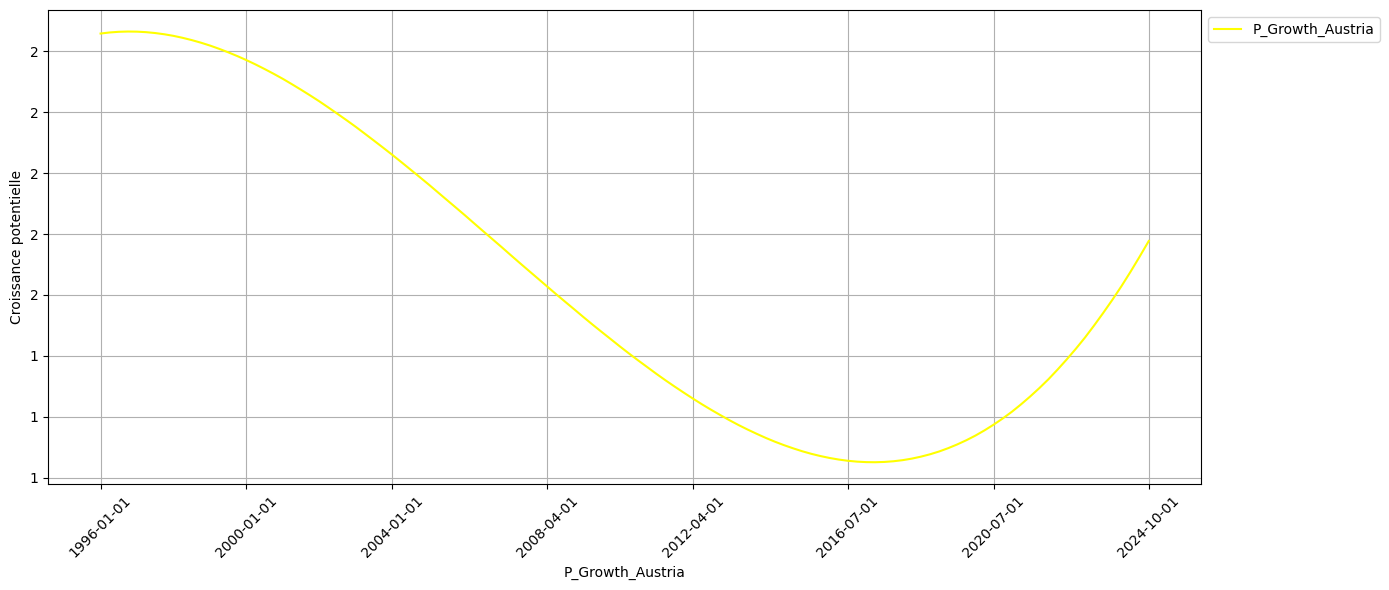

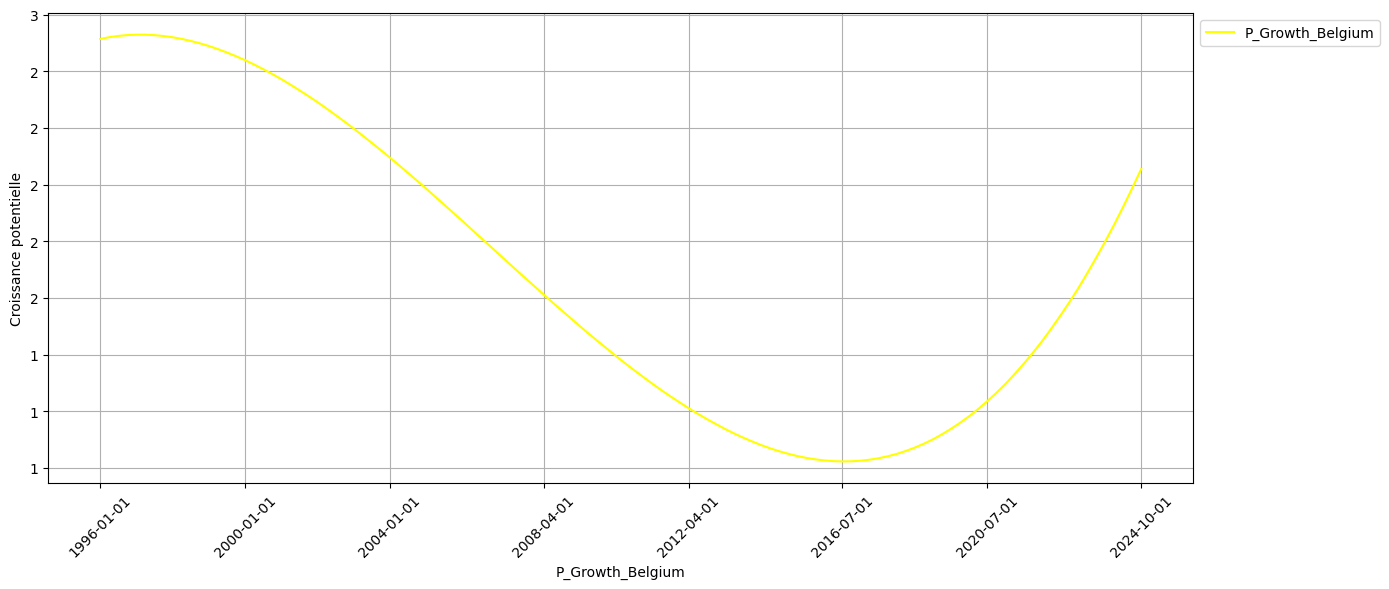

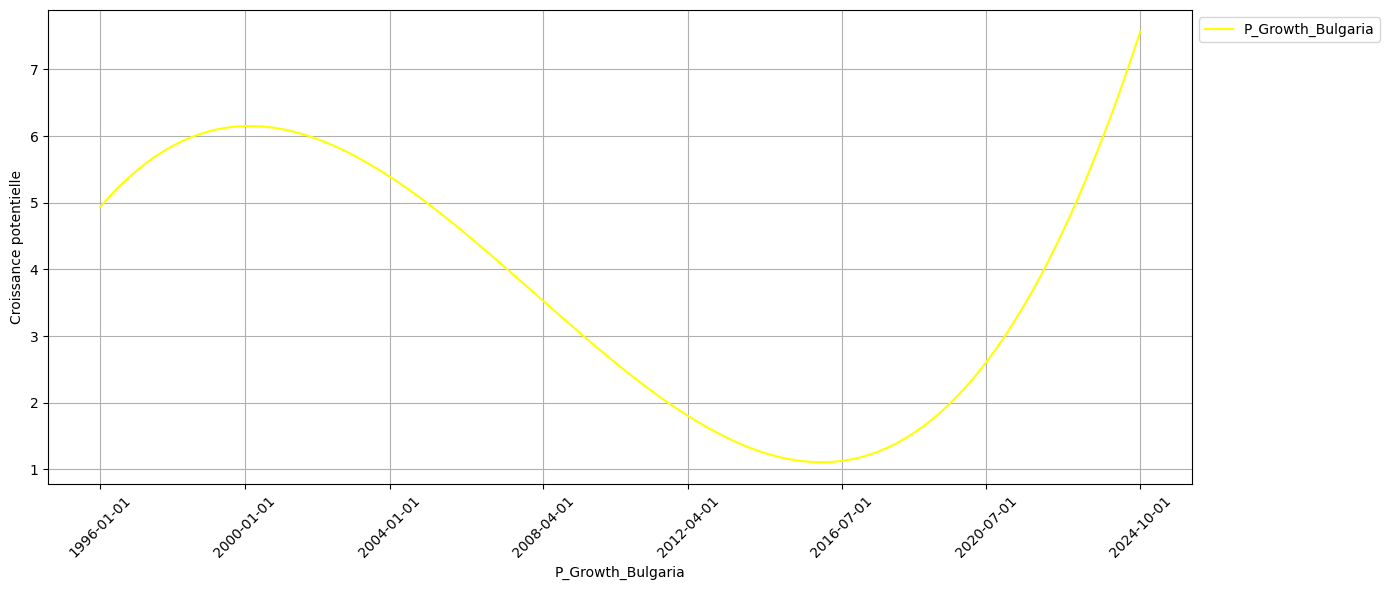

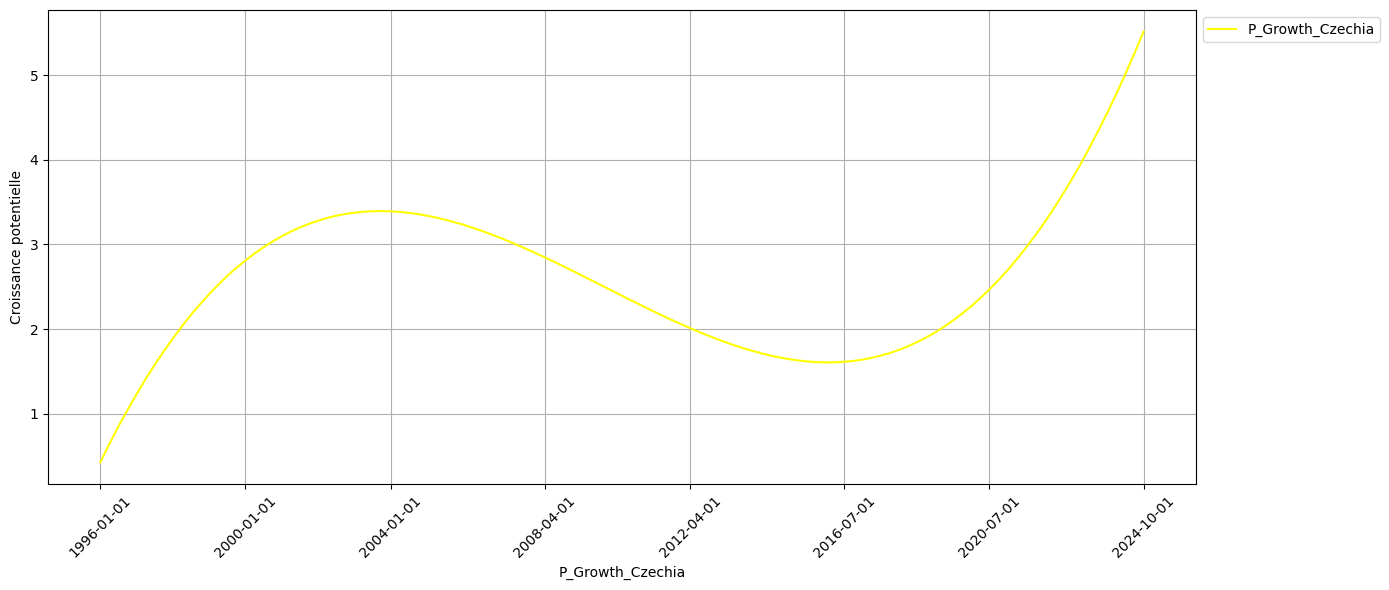

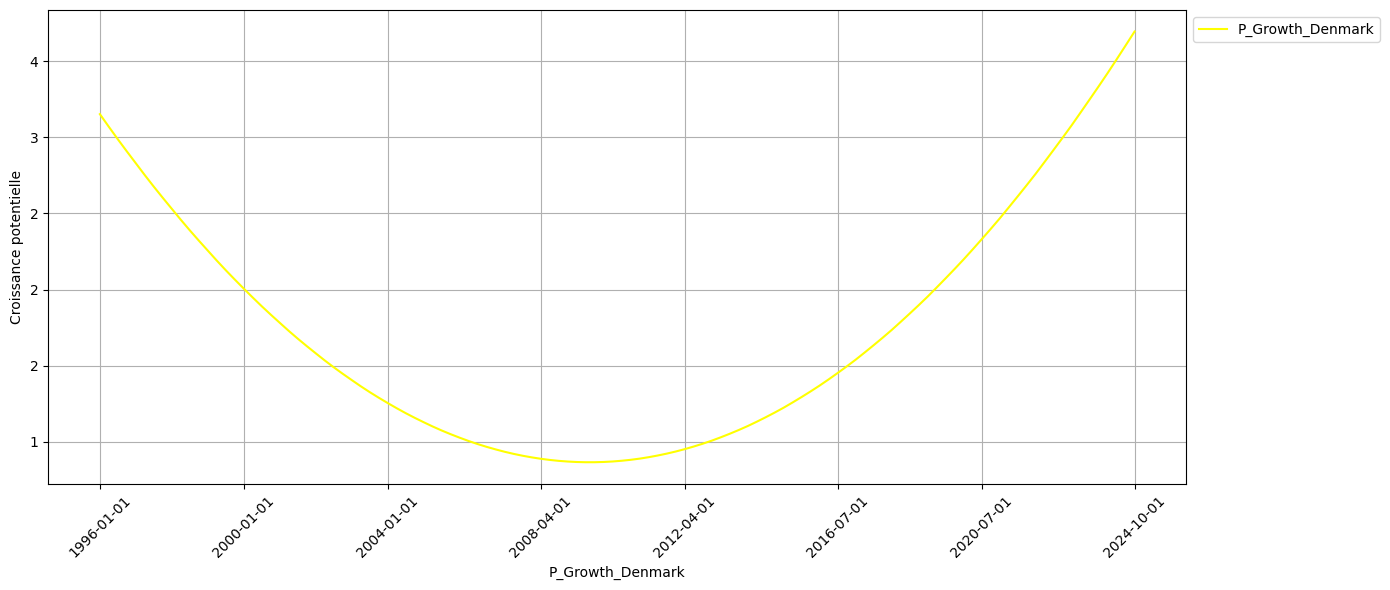

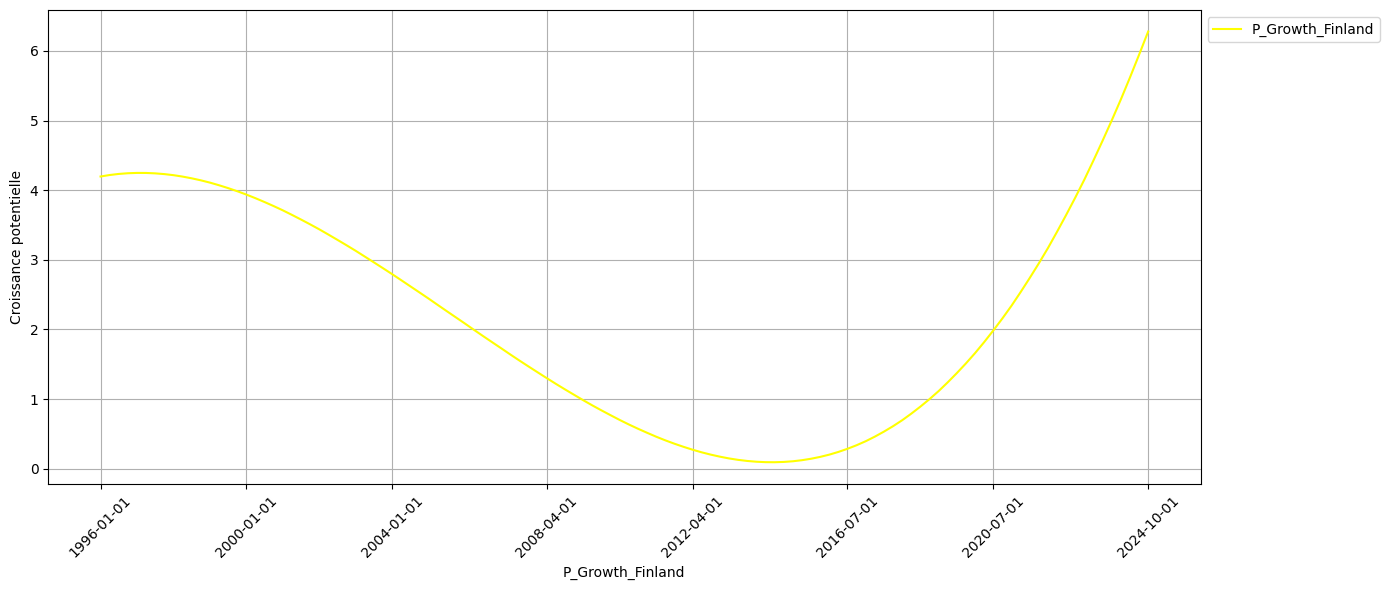

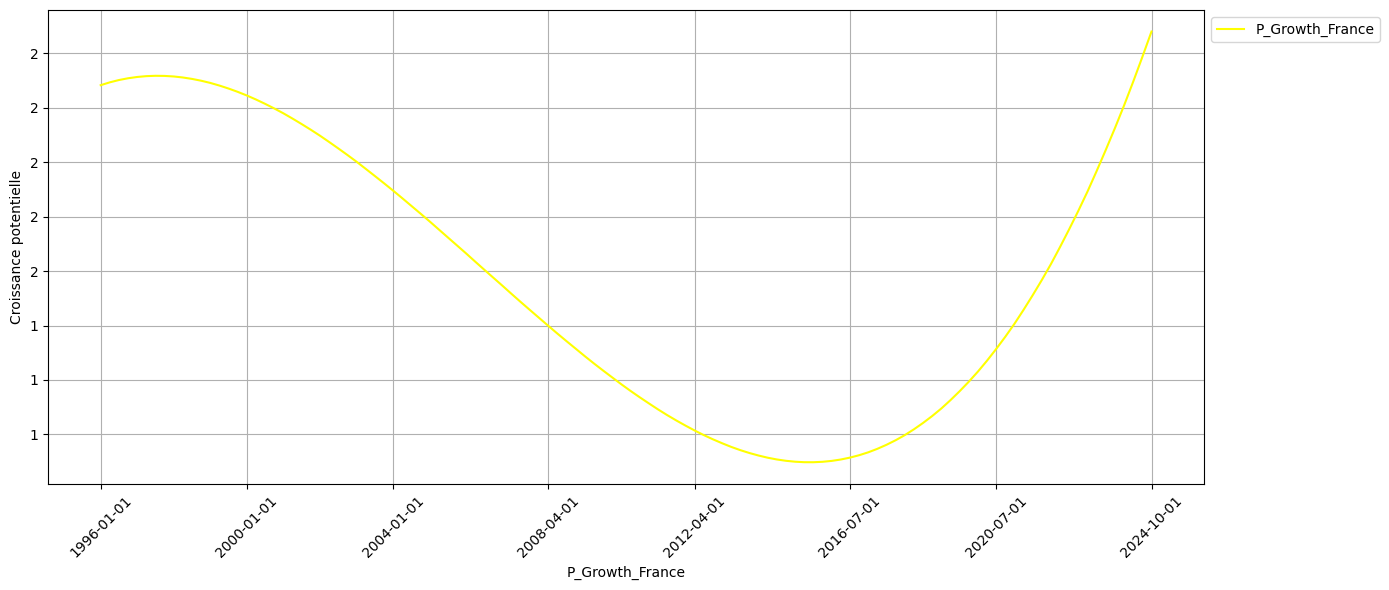

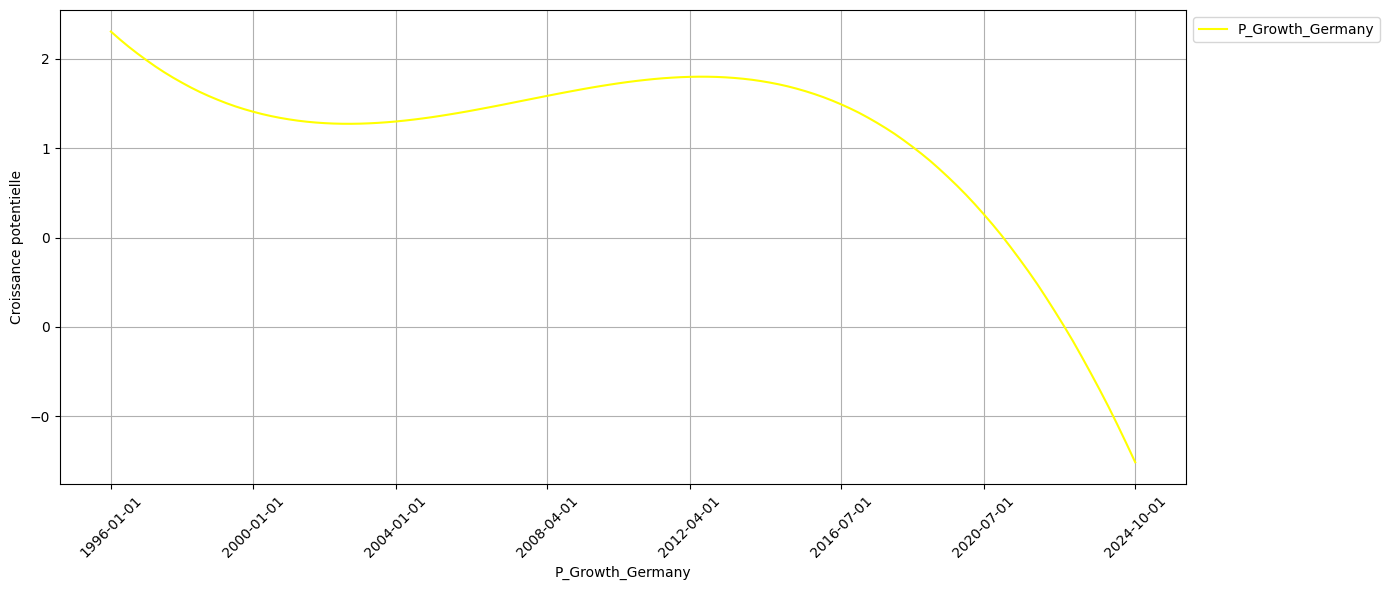

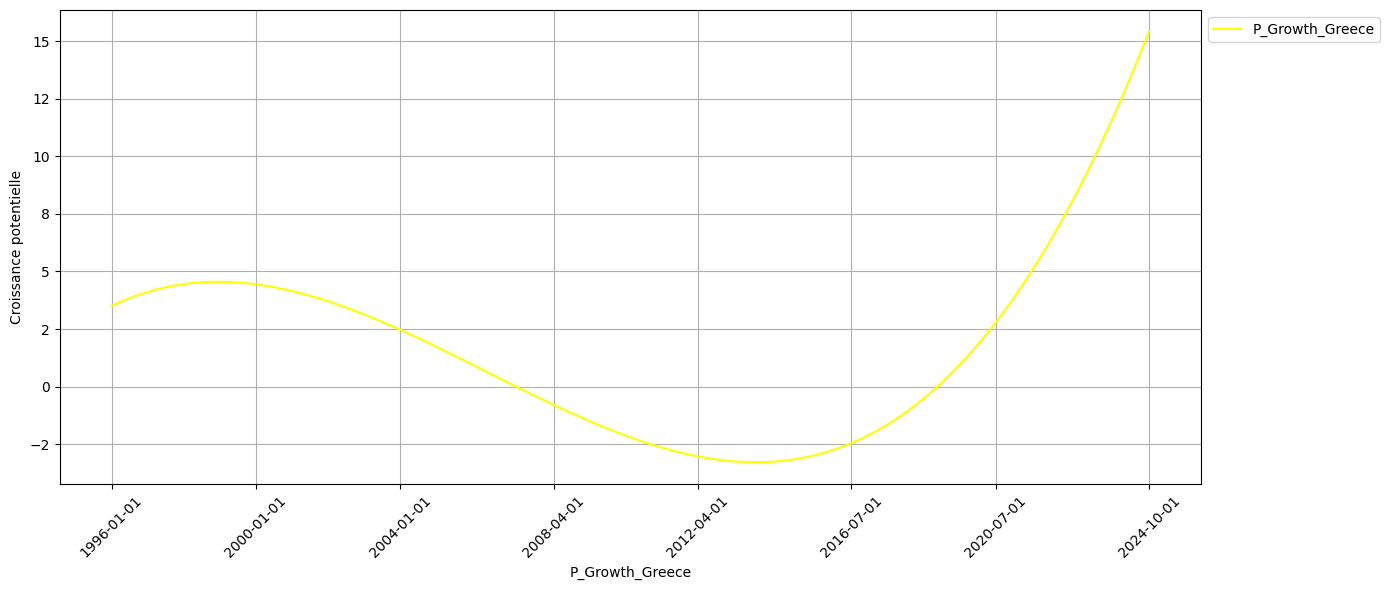

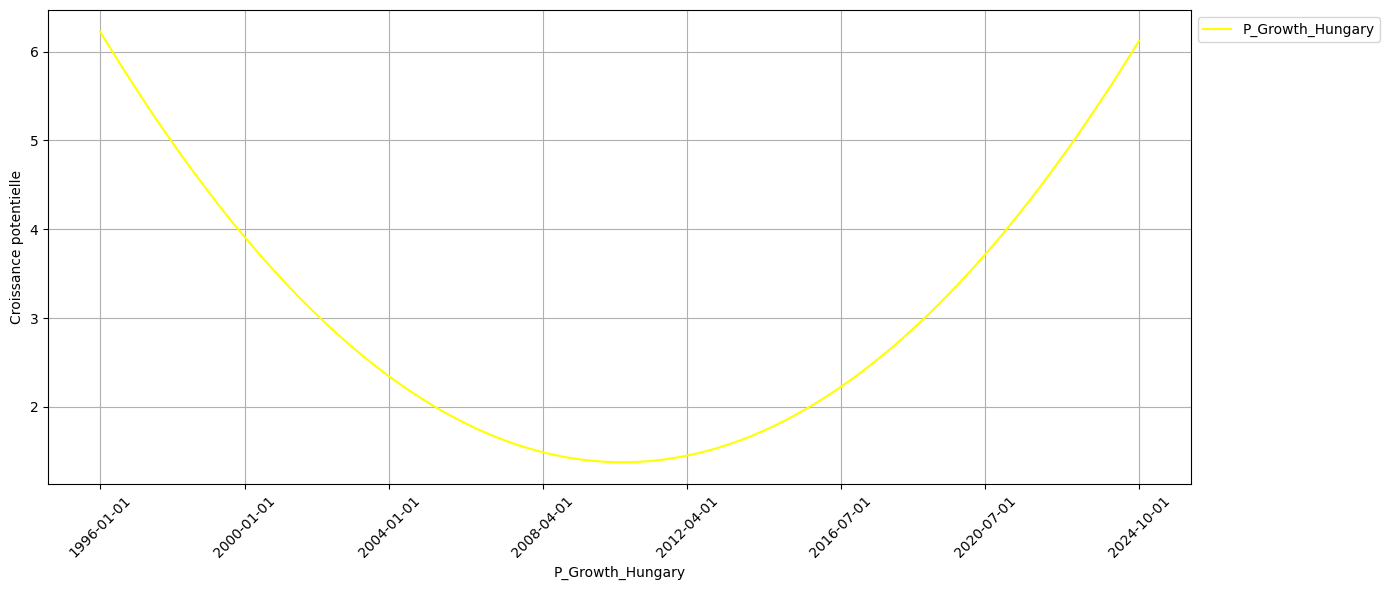

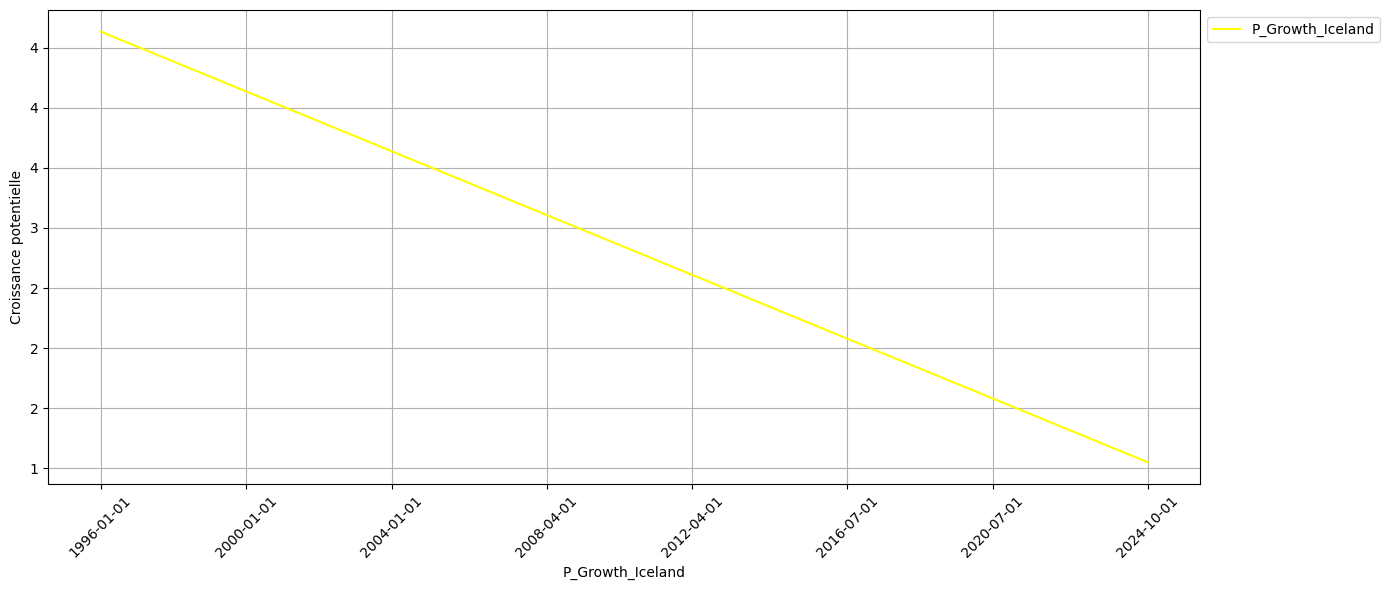

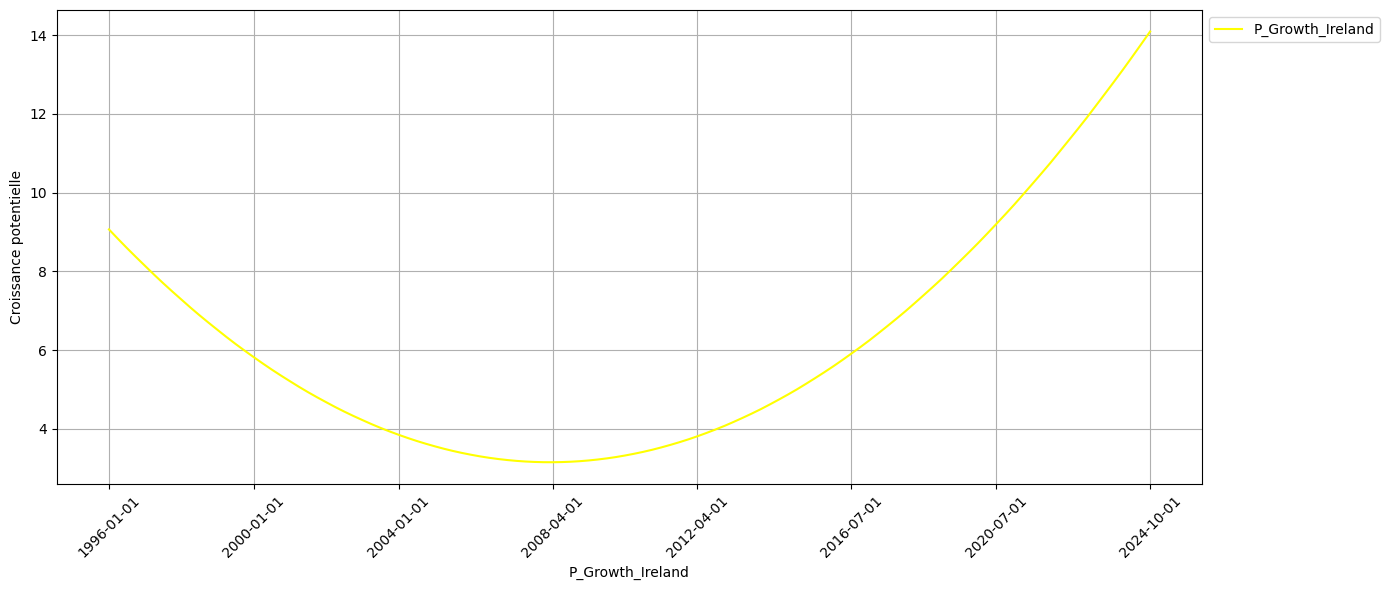

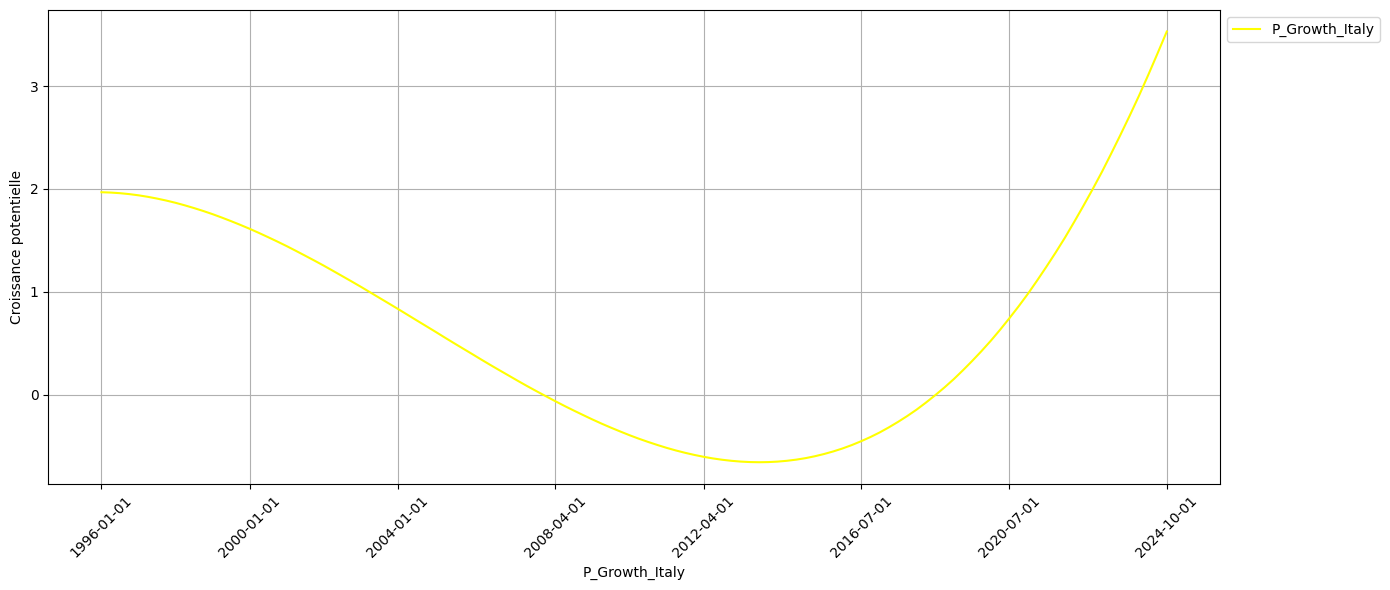

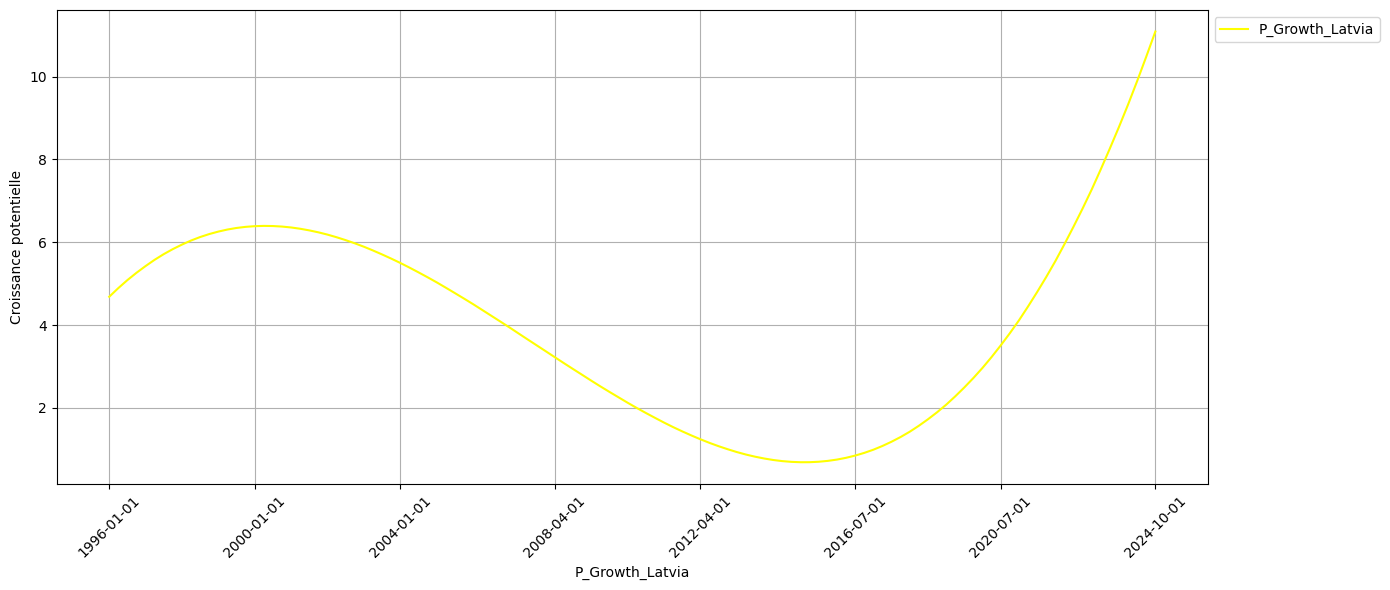

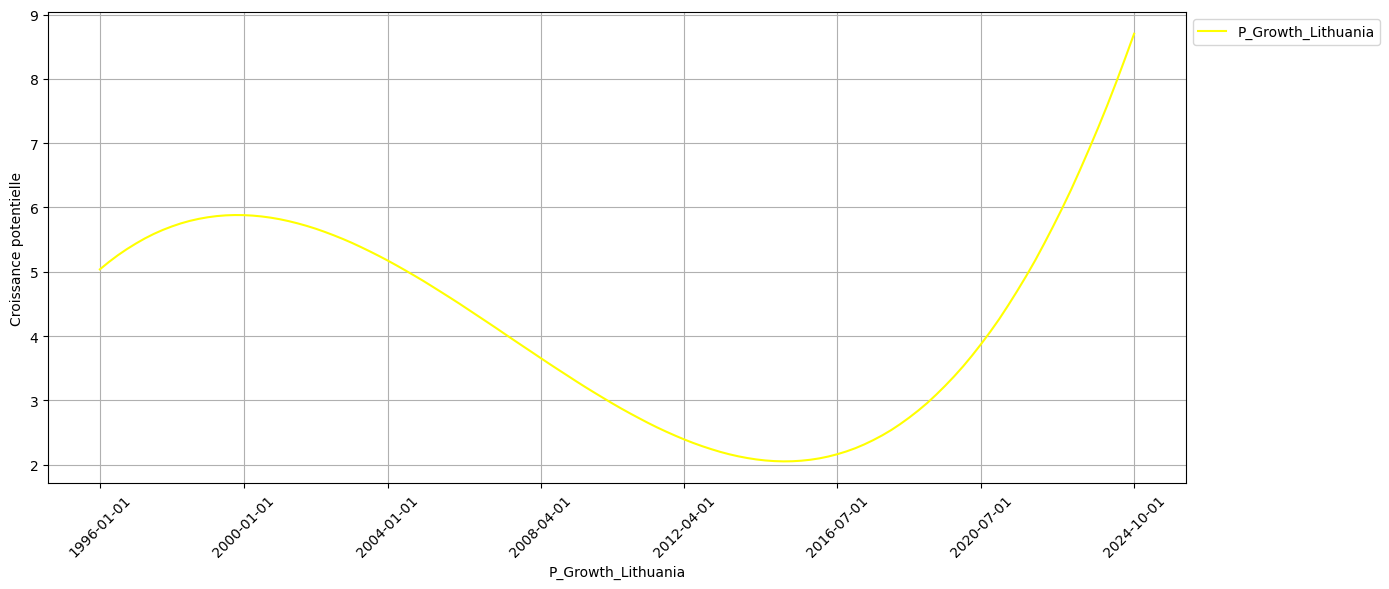

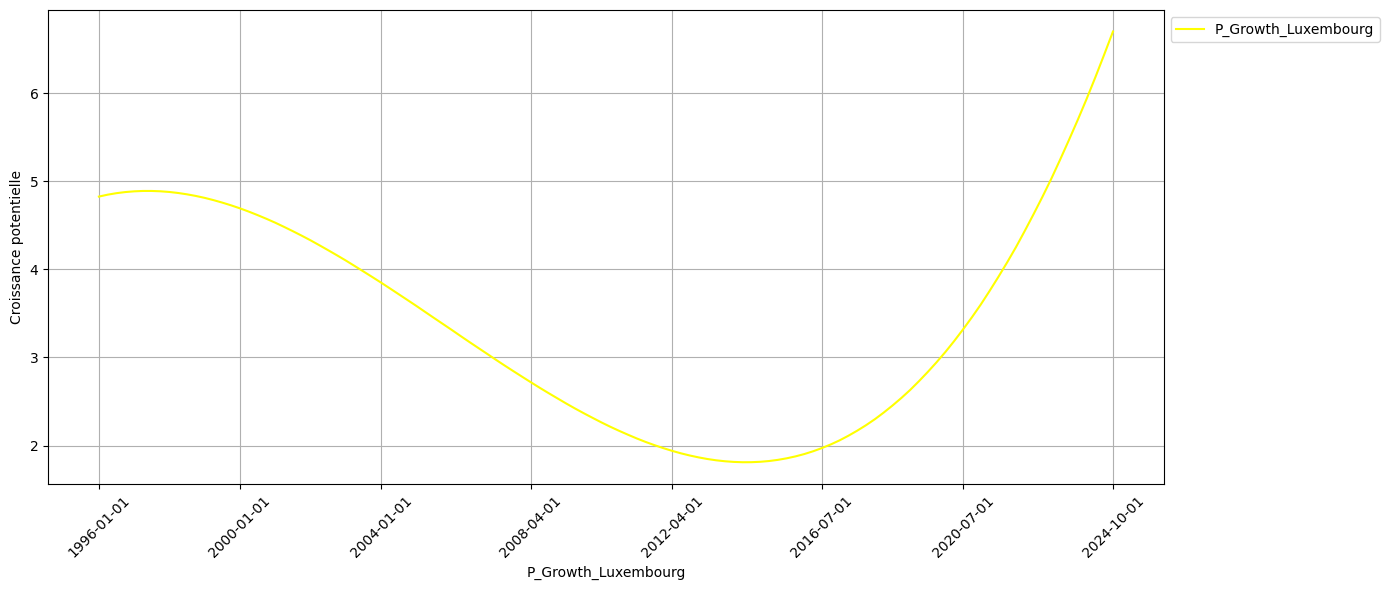

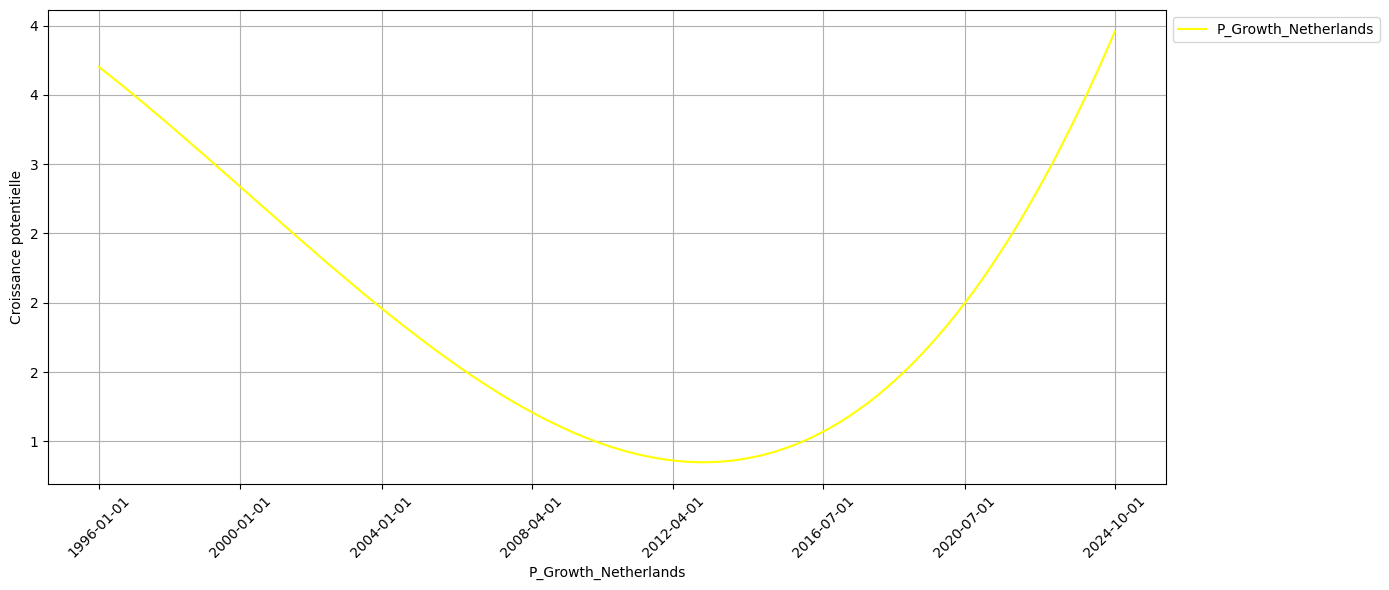

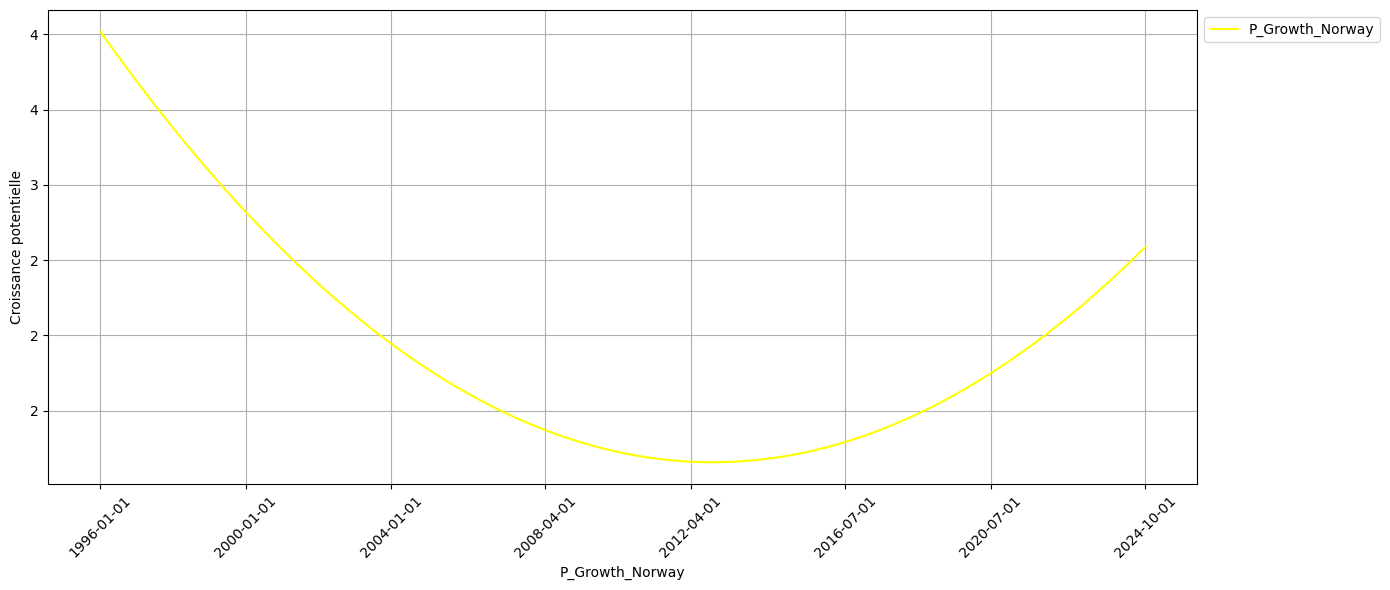

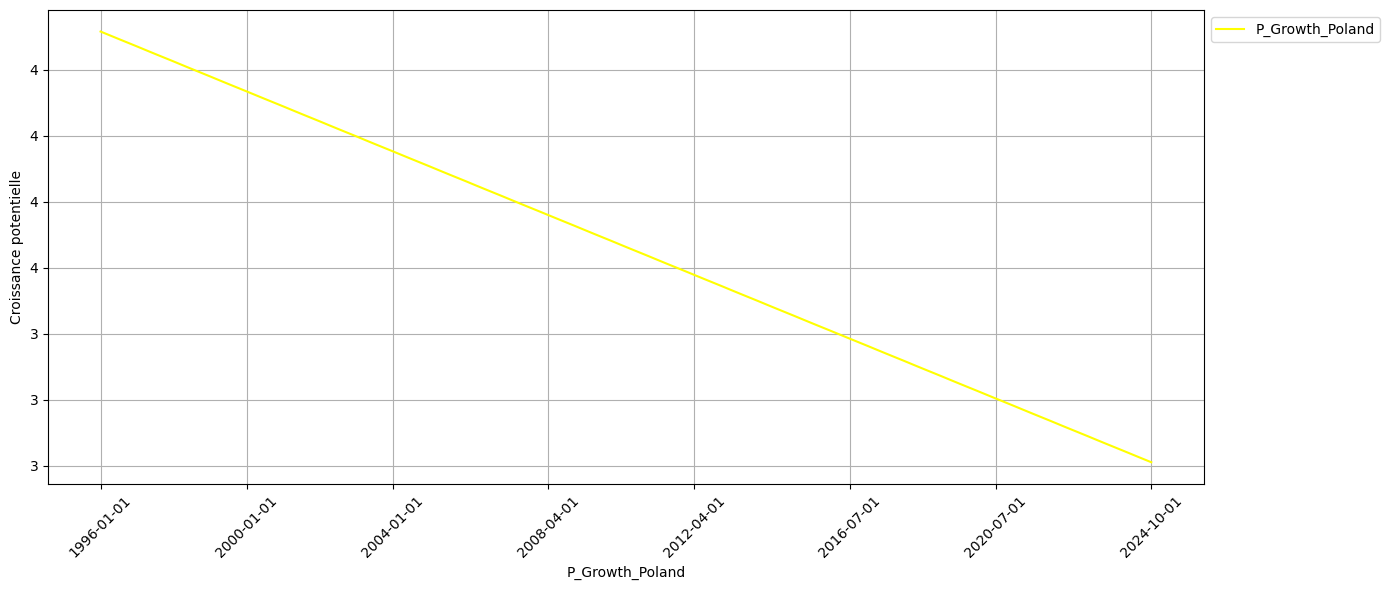

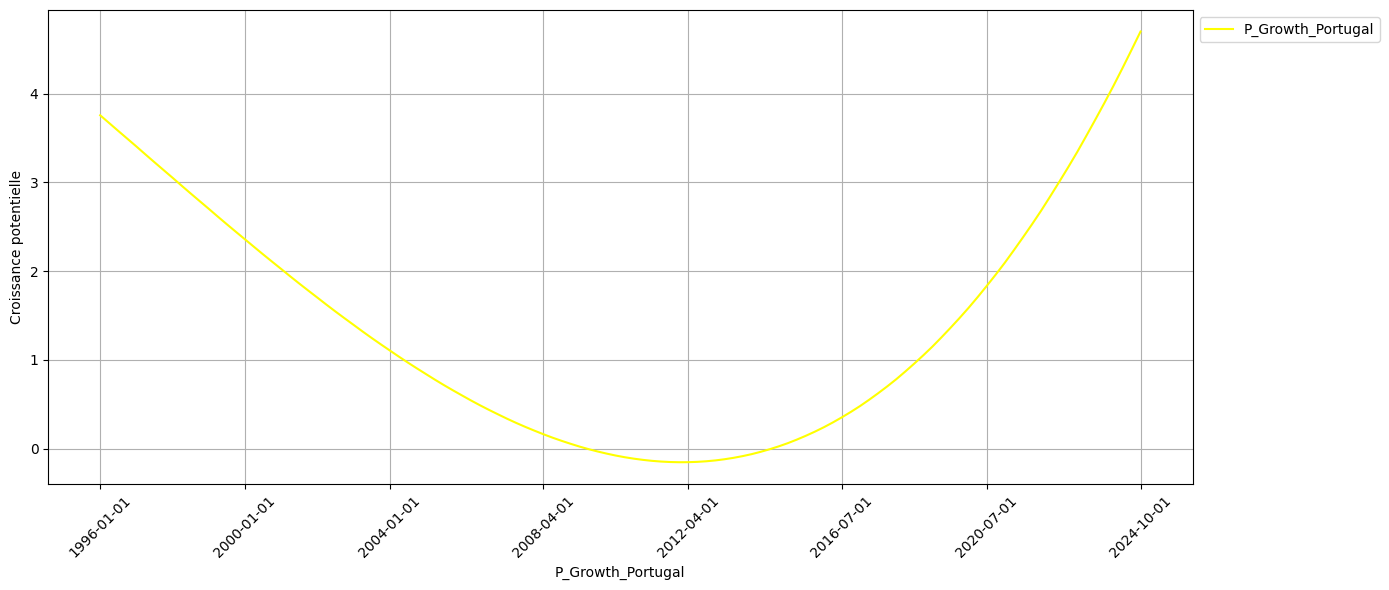

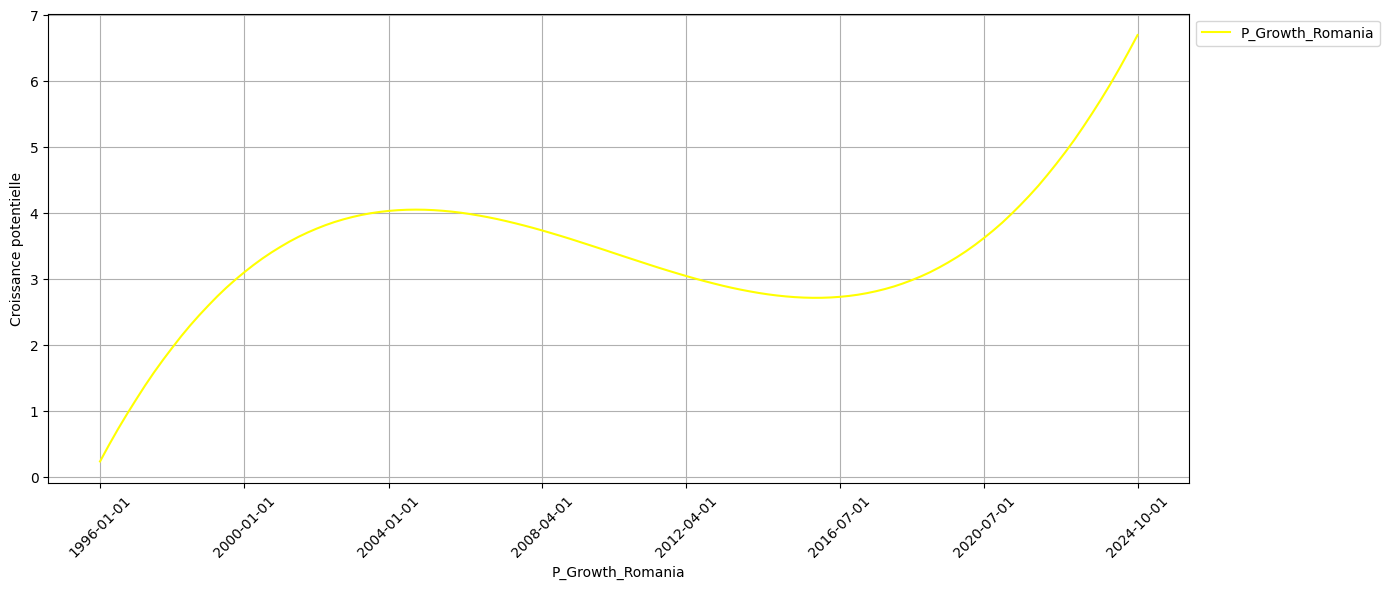

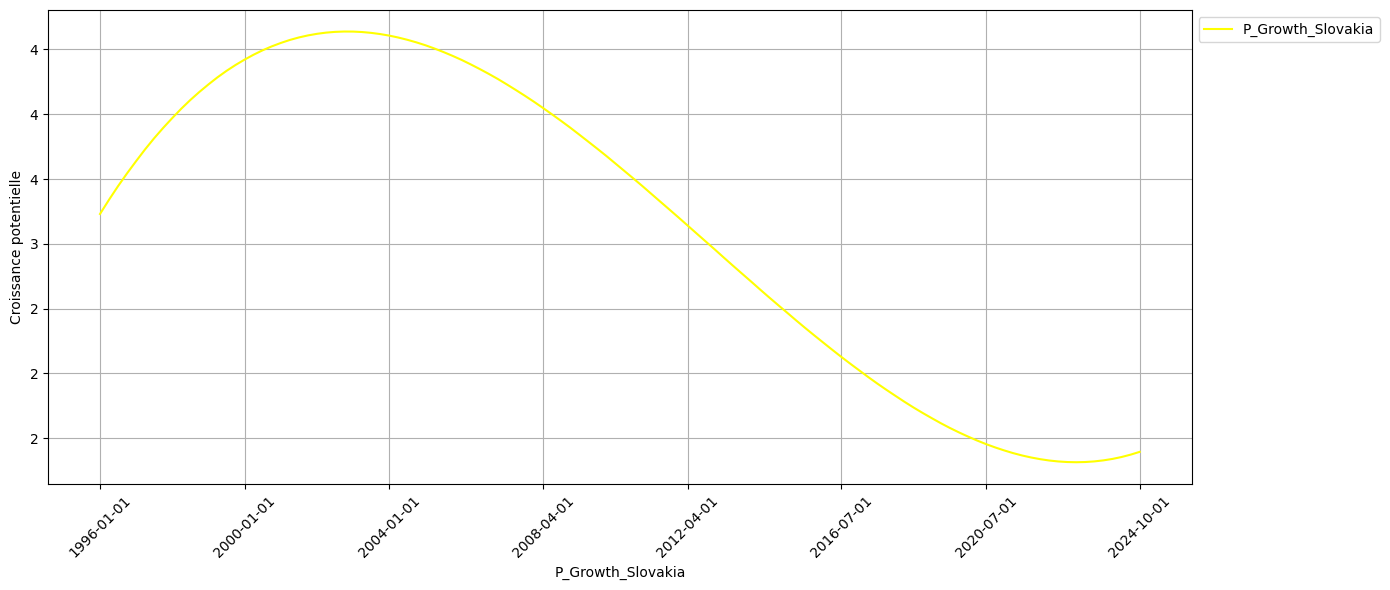

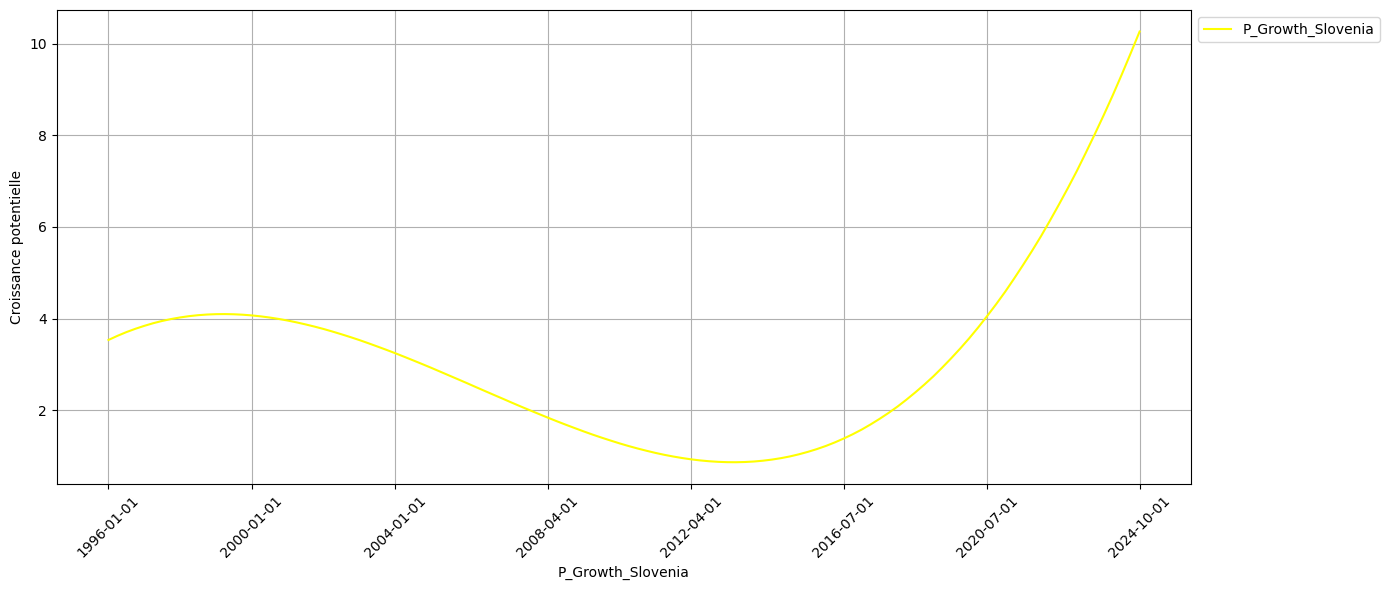

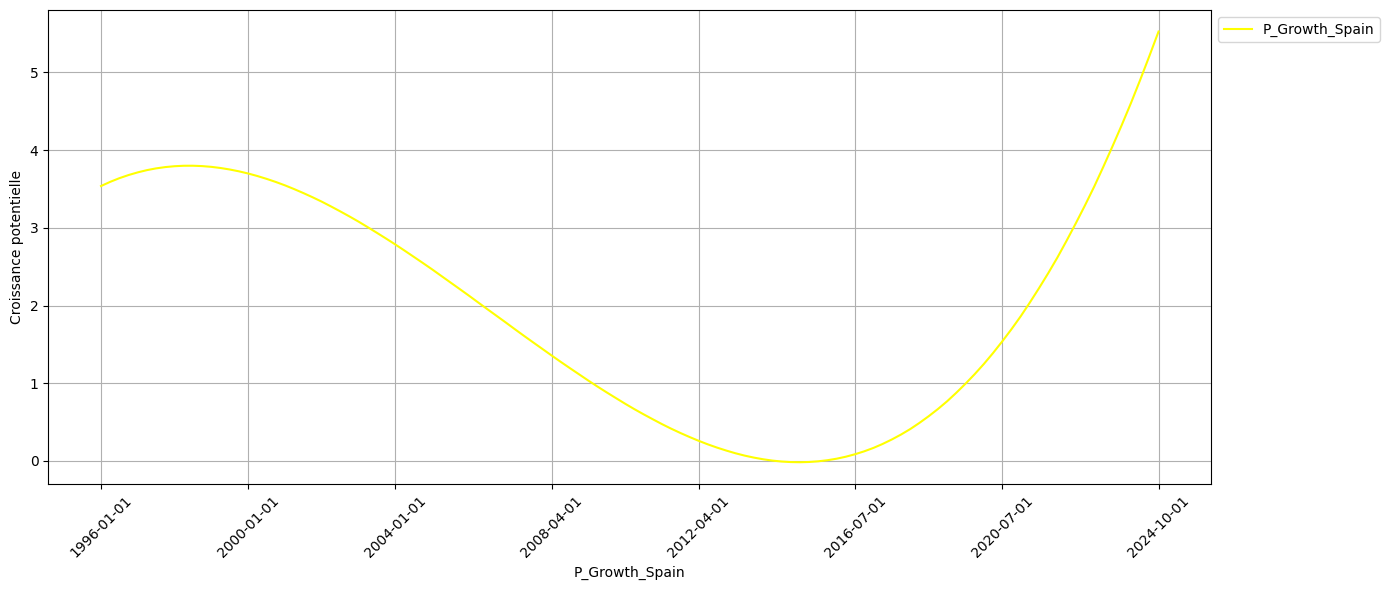

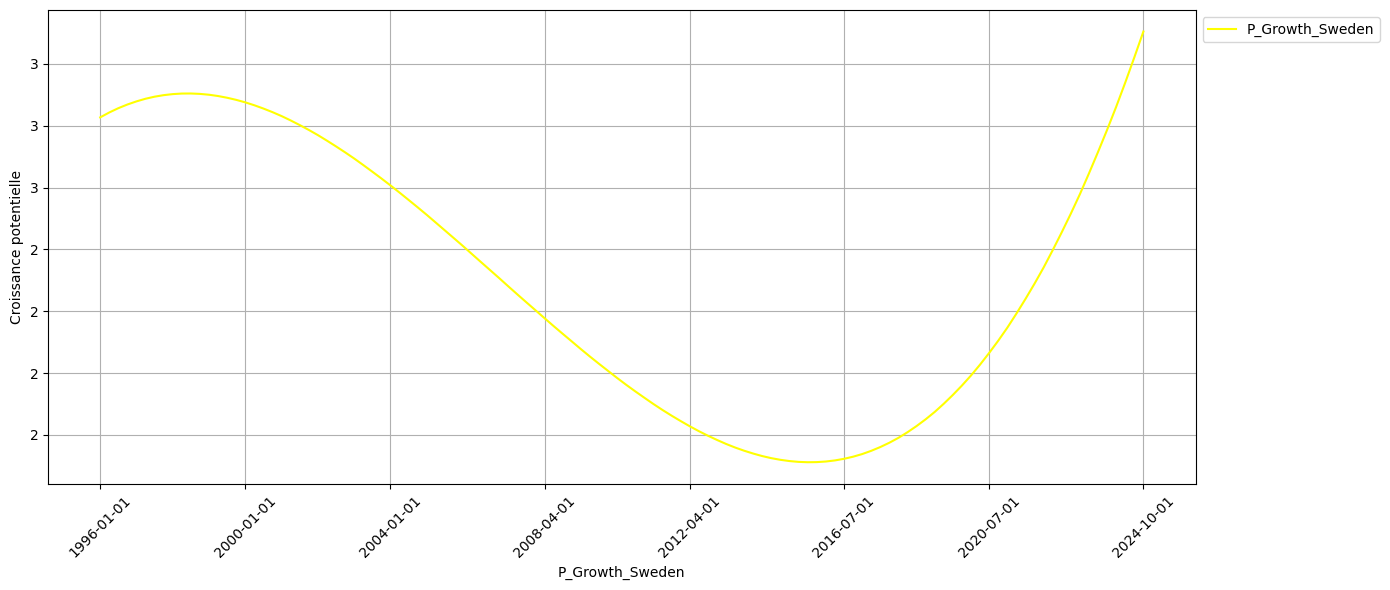

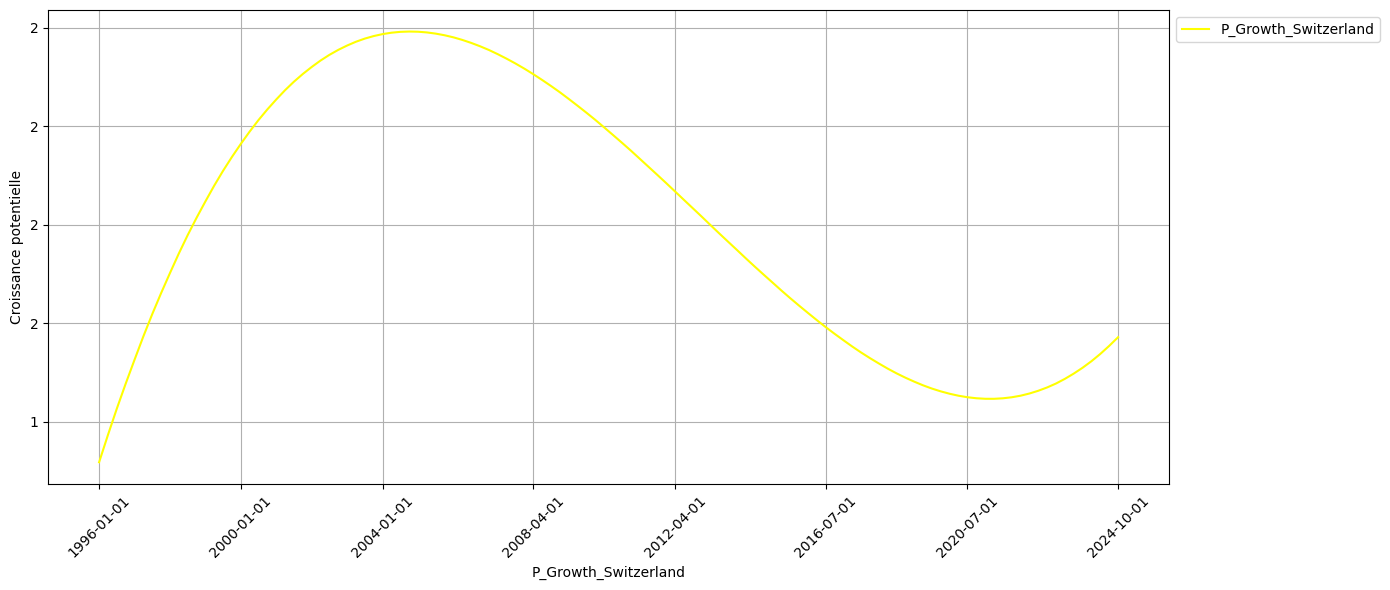

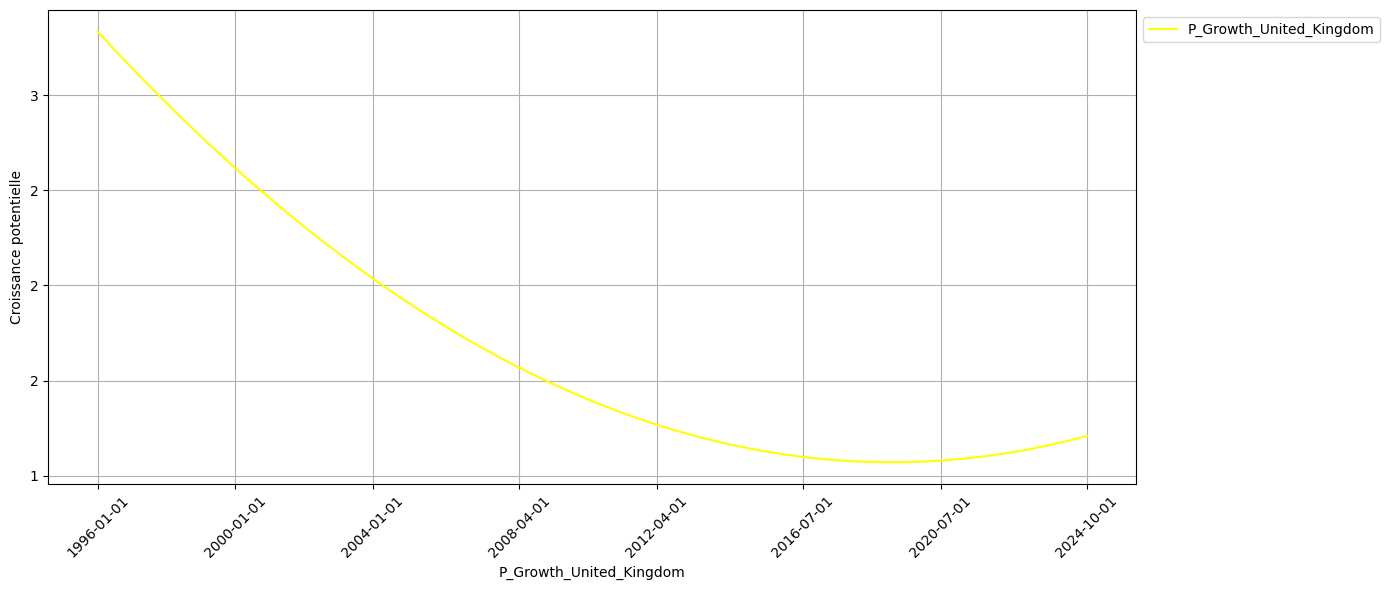

In [214]:
def graph_representation_automation(df):
    noms=list(df.columns)
    for column_name in noms:
        tracer_evolution(df,[column_name],xlabel=f'{column_name}', ylabel="Croissance potentielle" )
        
graph_representation_automation(P_Growth_forecasts)
#tracer_evolution(df_clean_TS, ["P_Growth_Italy"], xlabel="Période", ylabel="Croissance potentielle"


In [215]:
def tracer_series(series):
    plt.figure(figsize=(10, 4))
    plt.plot(series.index, 
         series.values, 
         marker='o', linestyle='-')
    plt.xlabel("Mois")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [216]:
def tracer_series(series):
    plt.figure(figsize=(10, 4))

    # Tracer toutes les valeurs sauf les 13 dernières
    plt.plot(series.index[:-13],
             series.values[:-13],
             marker='o', linestyle='-', label='Données collectées-interpolées')

    # Tracer les 13 dernières valeurs dans une autre couleur
    plt.plot(series.index[-13:],
             series.values[-13:],
             marker='o', linestyle='-', color='red', label='les 13 dernières valeurs-prédites par régression polynomiale')

    plt.xlabel("Mois")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


#### P_Growth_Italy <a class="anchor" id="partie241"></a>

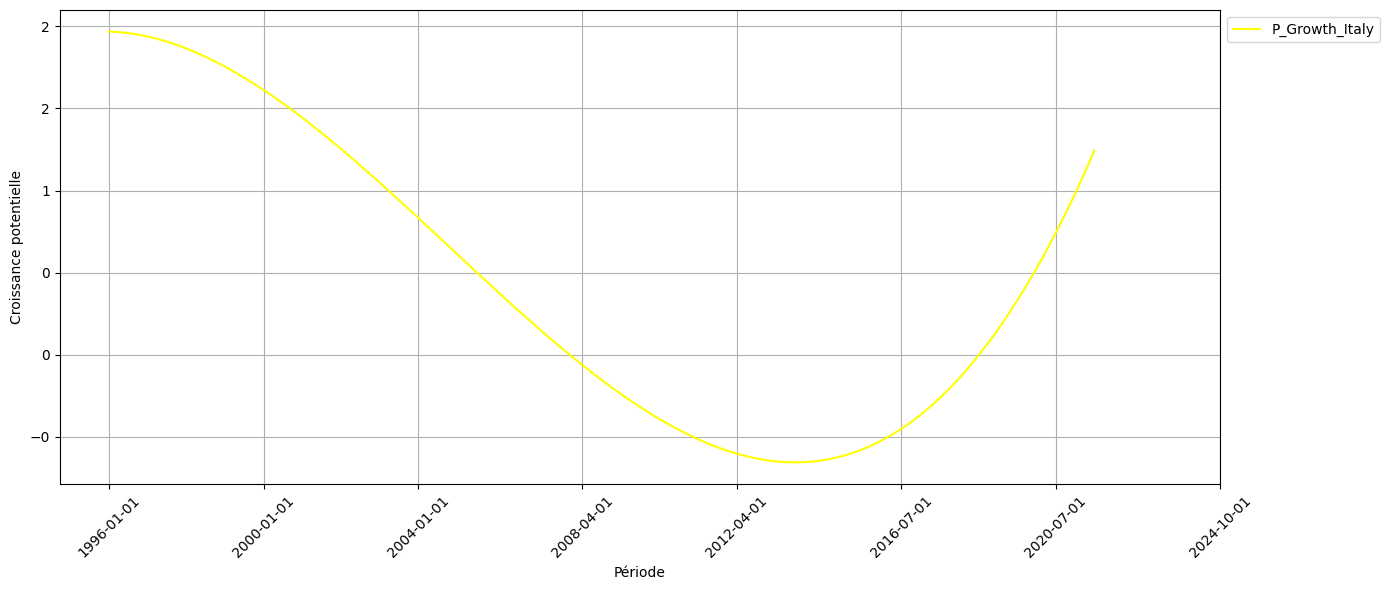

In [217]:
tracer_evolution(df_clean_TS, ["P_Growth_Italy"], xlabel="Période", ylabel="Croissance potentielle")



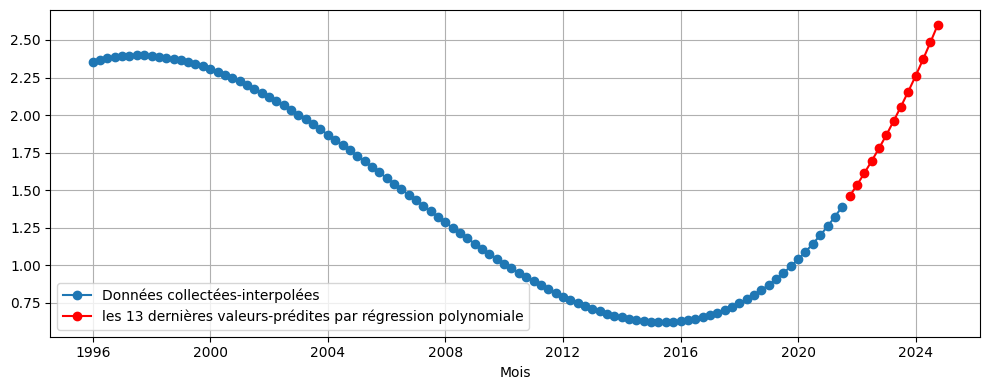

In [218]:
P_Growth_France_forecast= forecast_polynomial(df_clean_TS, "P_Growth_France")
tracer_series(P_Growth_France_forecast)




#### P_Growth_Bulgaria <a class="anchor" id="partie242"></a>

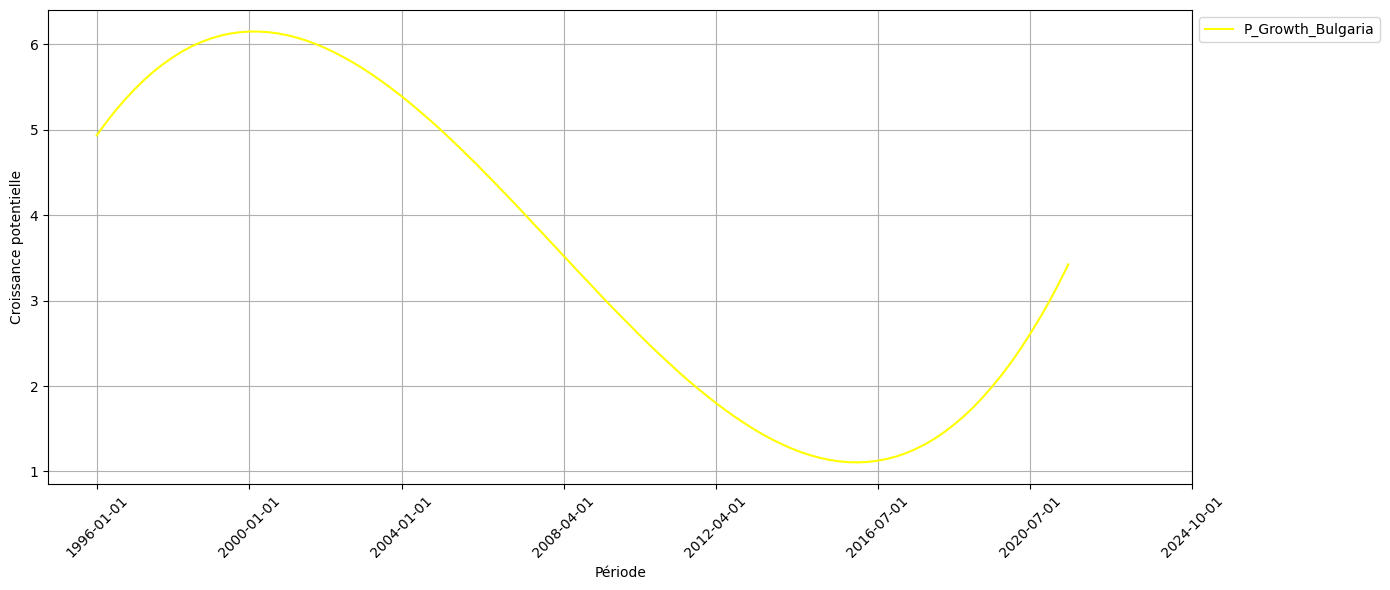

In [219]:
tracer_evolution(df_clean_TS, ["P_Growth_Bulgaria"], xlabel="Période", ylabel="Croissance potentielle")


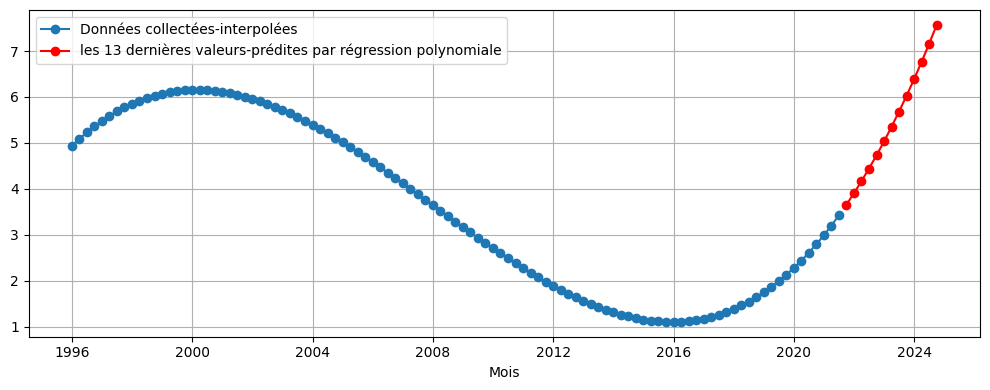

Unnamed: 0
1996-01-01    4.935537
1996-04-01    5.087906
1996-07-01    5.228971
1996-10-01    5.358971
1997-01-01    5.478146
                ...   
2023-10-01    6.030074
2024-01-01    6.391745
2024-04-01    6.768731
2024-07-01    7.161273
2024-10-01    7.569609
Freq: QS-OCT, Name: P_Growth_Bulgaria, Length: 116, dtype: float64


In [220]:
P_Growth_Bulgaria_forecast= forecast_polynomial(df_clean_TS, "P_Growth_Bulgaria")
tracer_series(P_Growth_Bulgaria_forecast)
print(P_Growth_Bulgaria_forecast
      )


## Etape 3: Reconstitution de la base de données reconstruite <a class="anchor" id="partie3"></a>


Nous allons générer le data_frame reconstruit. Celui-ci a pour but d'être utilisé pour les analyses globales (notamment analyse des corrélations intra-pays ou inter-pays étant donné qu'on n'utilise que des données annuelles)

In [244]:
# On commence par les taux d'intérêt à long terme
countries = ['Latvia', 'Lithuania', 'Poland', 'Slovakia', 'Czechia', 'Hungary', 'Iceland', 'Greece']

for country in countries:
    original_col = f'LT_IR_{country}'
    predicted_col = f'LT_IR_{country}_pred_final'
    
    if original_col in df_clean_TS.columns:
        if predicted_col in globals(): # pour s'assurer que la colonne prédite se trouve bien dans notre enviuronnement
            reconstructed_series = globals()[predicted_col]
            # On remplace uniquement les valeurs manquantes
            df_clean_TS[original_col] = df_clean_TS[original_col].combine_first(reconstructed_series)



In [ ]:
#CHECK
# Liste des pays
countries = ['Latvia', 'Lithuania', 'Poland', 'Slovakia', 'Czechia', 'Hungary', 'Iceland', 'Greece']

# Générer les noms de colonnes sans "_pred_final"
columns_to_print = [f'LT_IR_{country}' for country in countries]

# Afficher les colonnes si elles existent dans df_clean_TS
new_df=df_clean_TS[columns_to_print]


LT_IR_Latvia  LT_IR_Lithuania  LT_IR_Poland  LT_IR_Slovakia  \
Unnamed: 0                                                                
1996-01-01      8.332187        10.337128     11.071866        9.351080   
1996-04-01      8.287079        10.274607     11.025739        9.298318   
1996-07-01      8.241712        10.212087     10.979612        9.245556   
1996-10-01      8.199737        10.149566     10.933486        9.192794   
1997-01-01      8.154520        10.087046     10.887359        9.140032   
...                  ...              ...           ...             ...   
2023-10-01      3.870000         2.880000      5.530000        3.766608   
2024-01-01      3.396667         2.880000      5.333333        3.470253   
2024-04-01      3.446667         2.880000      5.690000        3.687122   
2024-07-01      3.230000         2.880000      5.413333        3.444584   
2024-10-01      3.076667         2.880000      5.663333        3.291885   

            LT_IR_Czechia  LT_IR_Hungary  LT_IR_Iceland  LT_IR_Greece  
Unnamed: 0                                                             
1996-01-01       6.598714       9.846734      10.103330      8.415883  
1996-04-01       6.578437       9.818961       8.756667      8.420156  
1996-07-01       6.560922       9.791189       8.713333      8.431223  
1996-10-01       6.539648       9.763420       9.386666      8.440904  
1997-01-01       6.521467       9.735662       9.553333      8.491149  
...                   ...            ...            ...           ...  
2023-10-01       4.371921       6.903333       4.823432      3.820000  
2024-01-01       3.821404       6.226666       4.412271      3.370000  
2024-04-01       4.190742       6.853333       4.001431      3.563333  
2024-07-01       3.834368       6.376667       3.636707      3.333333  
2024-10-01       4.073143       6.546667       3.350028      3.133333  

[116 rows x 8 columns]

In [246]:
# pour les taux d'intérêt à court terme
countries = ['Switzerland','Lithuania','Luxembourg','Latvia']

for country in countries:
    original_col = f'ST_IR_{country}'
    predicted_col = f'ST_IR_{country}_pred_final'
    
    if original_col in df_clean_TS.columns:
        if predicted_col in globals(): # pour s'assurer que la colonne prédite se trouve bien dans notre enviuronnement
            reconstructed_series = globals()[predicted_col]
            # On remplace uniquement les valeurs manquantes
            df_clean_TS[original_col] = df_clean_TS[original_col].combine_first(reconstructed_series)



In [ ]:
#CHECK
# Liste des pays
countries = ['Switzerland','Lithuania','Luxembourg','Latvia']

# Générer les noms de colonnes sans "_pred_final"
columns_to_print = [f'ST_IR_{country}' for country in countries]

# Afficher les colonnes si elles existent dans df_clean_TS
new_df=df_clean_TS[columns_to_print]
new_df

In [ ]:
#Et maintenant on fait exactement la même chose avec la croissance potentielle
for col in P_Growth_forecasts.columns:
    if col in df_clean_TS.columns:
        df_clean_TS[col] = df_clean_TS[col].combine_first(P_Growth_forecasts[col])



In [ ]:
df_clean_TS= df_clean_TS[[col for col in df_clean_TS.columns if not col.startswith("inflation")]]

df_clean_TS

## Etape 4: Visualisation des données manquantes  <a class="anchor" id="partie4"></a>

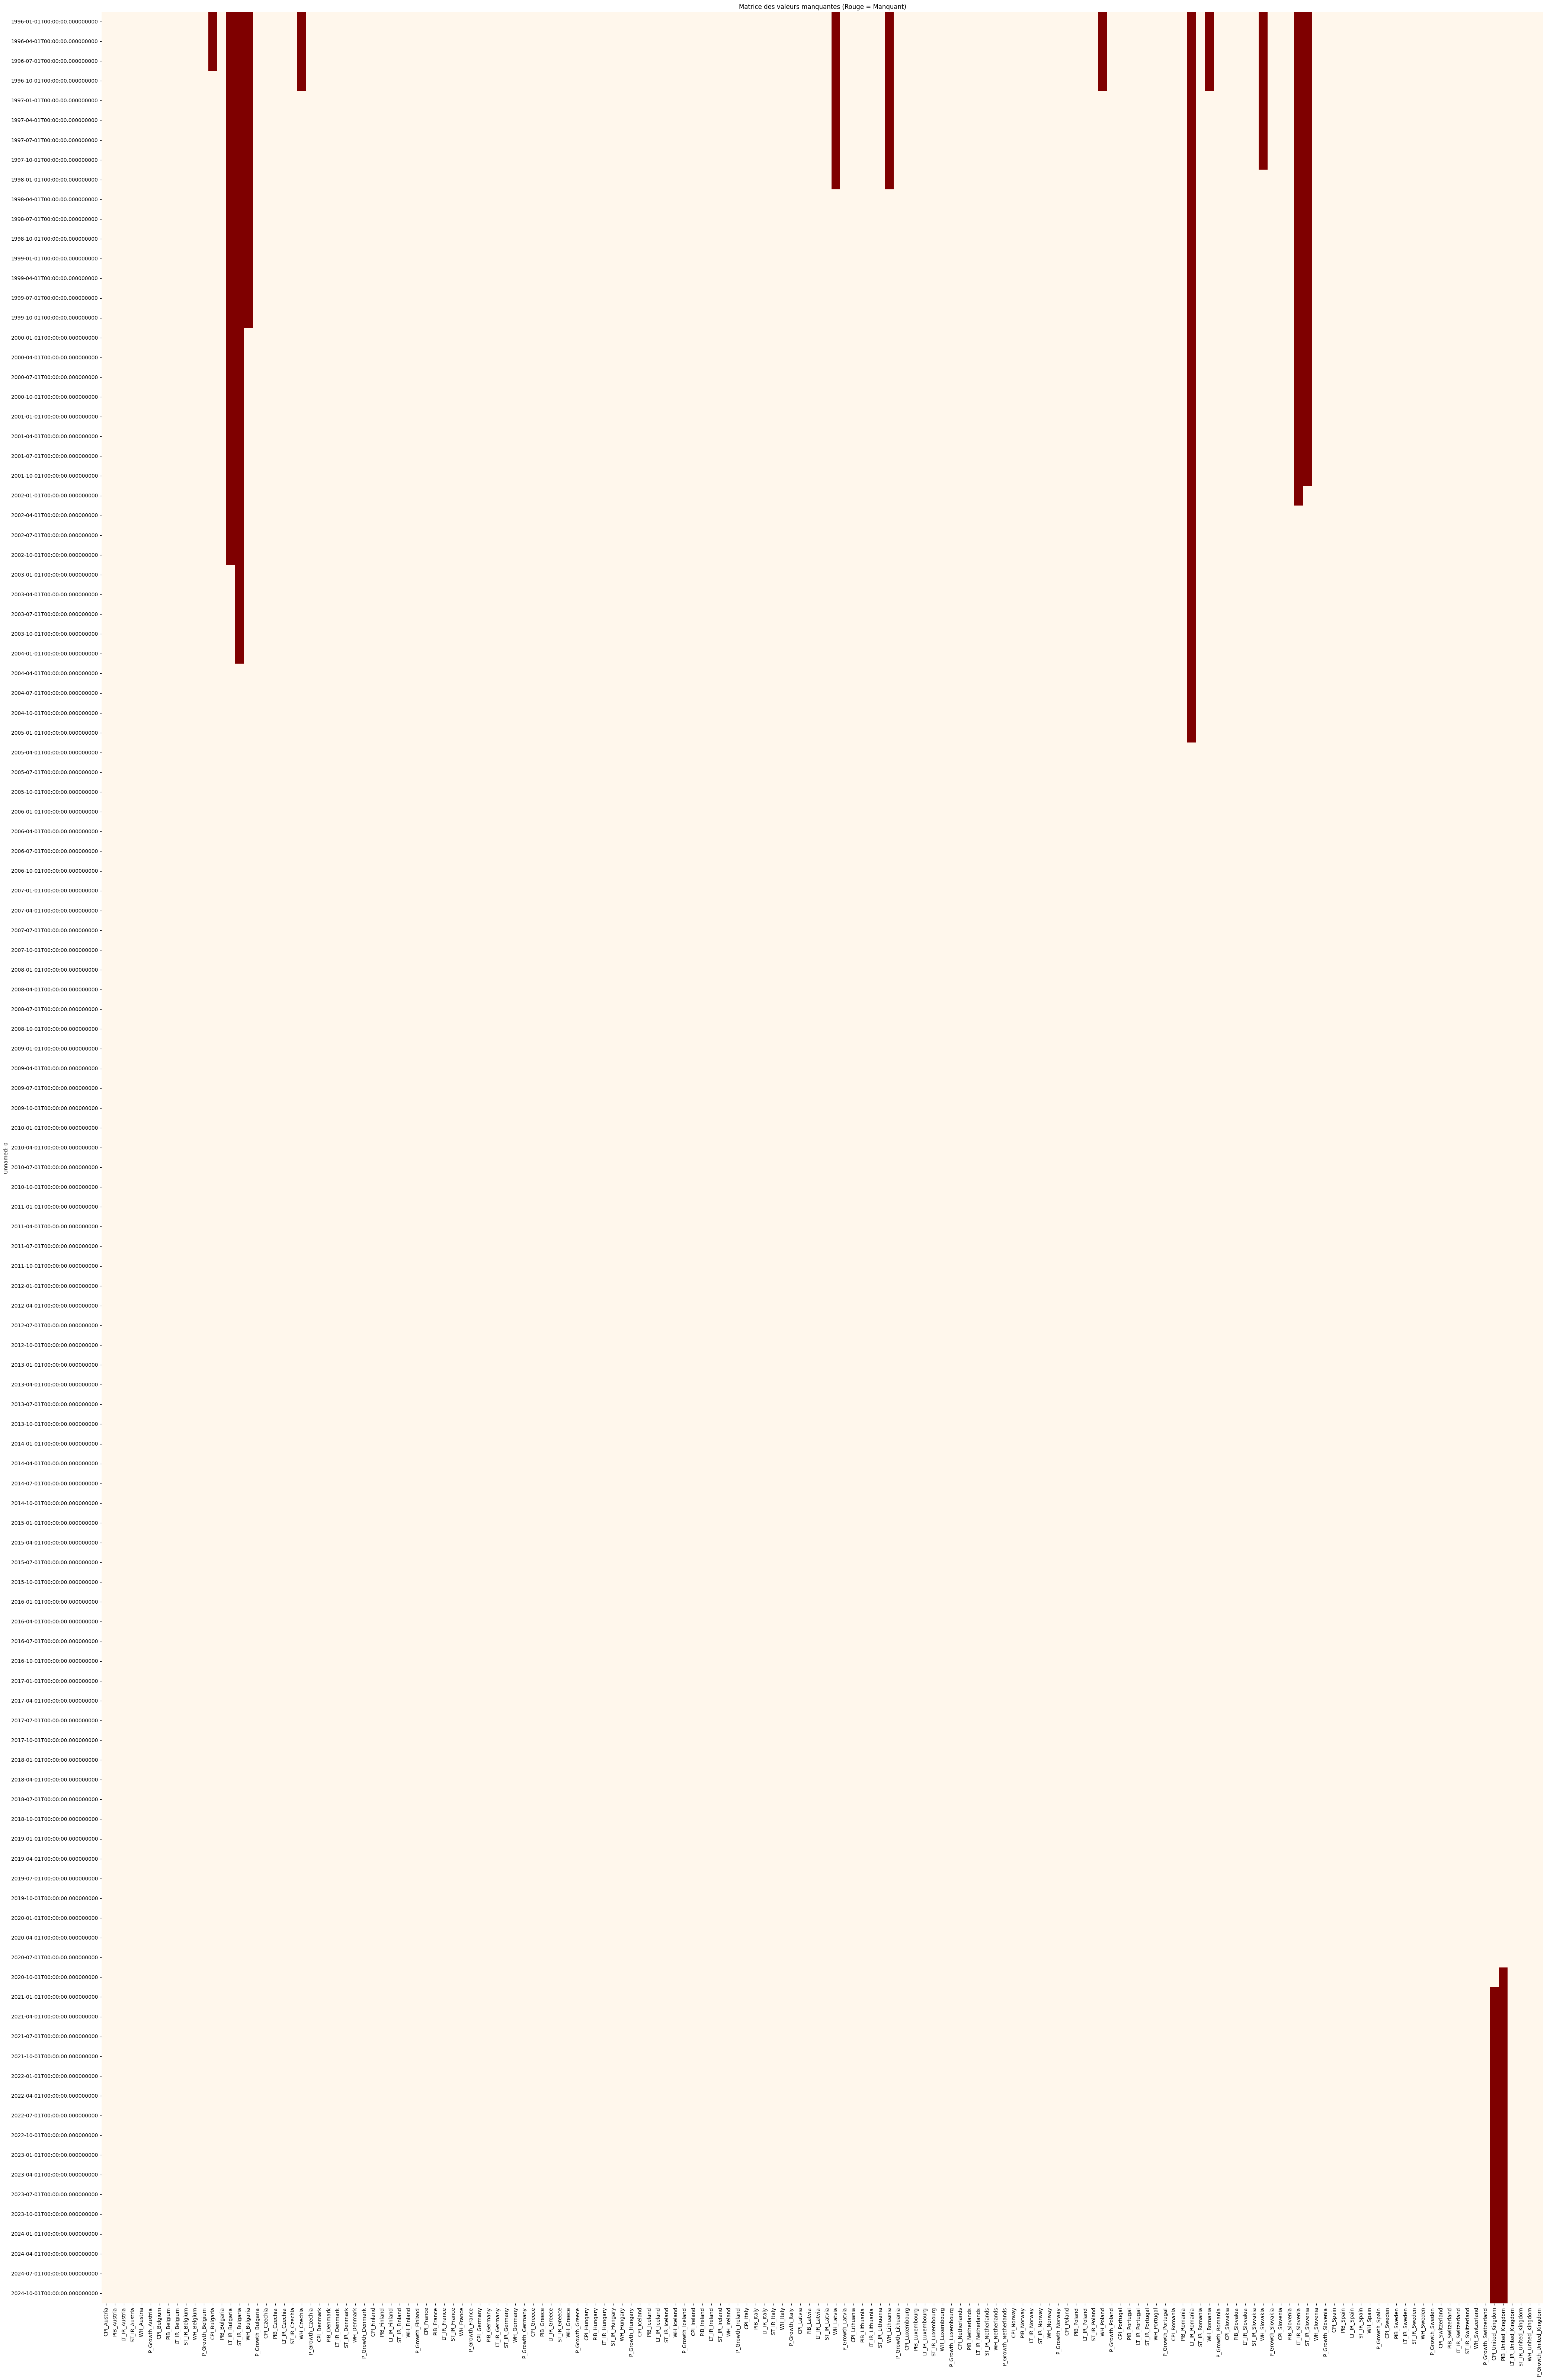

In [250]:
#Pour visualiser le nettoyage progressif des données
df_clean_missing_binary = df_clean_TS.isnull().astype(int)

# Définir la figure avec un affichage interactif
fig, ax = plt.subplots(figsize=(50, 80))

# Utiliser seaborn pour une meilleure visualisation sans grille
sns.heatmap(df_clean_missing_binary, cmap="OrRd", cbar=False, linewidths=0, ax=ax, square=False)

# Ajouter un titre
ax.set_title("Matrice des valeurs manquantes (Rouge = Manquant)")

# Rotation des labels pour une meilleure lisibilité
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Afficher la figure
plt.show()

In [251]:
#Pourcentage de données manquantes par variable
percentage_missing_clean=((df_clean_missing_binary.sum())/df_clean_missing_binary.shape[0])*100

#On ne garde que les colonnes ayant des missing values
percentage_missing_clean=percentage_missing_clean[percentage_missing_clean>0]
percentage_missing_clean = percentage_missing_clean.sort_values(ascending=False)
percentage_missing_clean

LT_IR_Romania         31.896552
ST_IR_Bulgaria        28.448276
LT_IR_Bulgaria        24.137931
LT_IR_Slovenia        21.551724
ST_IR_Slovenia        20.689655
PIB_United_Kingdom    14.655172
WH_Bulgaria           13.793103
CPI_United_Kingdom    13.793103
WH_Lithuania           7.758621
WH_Latvia              7.758621
WH_Slovakia            6.896552
WH_Romania             3.448276
WH_Czechia             3.448276
WH_Poland              3.448276
CPI_Bulgaria           2.586207
dtype: float64

Nous avons établit un seuil de 20%, au delà de ce seuil, nous n'avons pas cherché à prédire/faire du backcast pour les données manquantes). D'autre part, le nombre d'heures travaillées a été finalement exclu de notre analyse parce que ces variables n'ont pas été intégrées dans la partie modélisation du projet. 

Il reste: le royaume uni (potentiellement exclu puisqu'il ne fait plus partie de l'UE depuis 2020, et c'est pourquoi les données manquantes pour le PIB n'y figurent pas depuis cette date dans le site de l'OCDE)

In [252]:
df_clean_TS.to_excel("Données_produites/base_de_données_reconstruite.xlsx", index=True)
